In [1]:
import numpy as np
import pandas as pd
import numpy as np

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

# Gera dados aleatórios ao invés de um grid regular
def GetRandomSamples(n_samples):
    x = np.random.uniform(0, 1, n_samples)
    y = np.random.uniform(0, 1, n_samples)
    z = benchmark(x, y)
    return x, y, z

# Cria um DataFrame a partir dos pontos aleatórios
def create_random_dataframe(n_samples):
    x, y, z = GetRandomSamples(n_samples)
    data = {'x1': x, 'x2': y, 'f(x1,x2)': z}
    df = pd.DataFrame(data)
    return df

def GetGrid(grid):
    x = np.linspace(0, 1, grid)
    y = np.linspace(0, 1, grid)
    x, y = np.meshgrid(x, y)
    z = benchmark(x, y)
    return x, y, z

def create_dataframe(grid):
   x, y, z = GetGrid(grid)
   data = {'x1': x.flatten(), 'x2': y.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_training = create_random_dataframe(n_samples=30)   
df_test = create_random_dataframe(n_samples=20)       
df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="HoleEffect")

/tmp/ipykernel_11884/1808877763.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


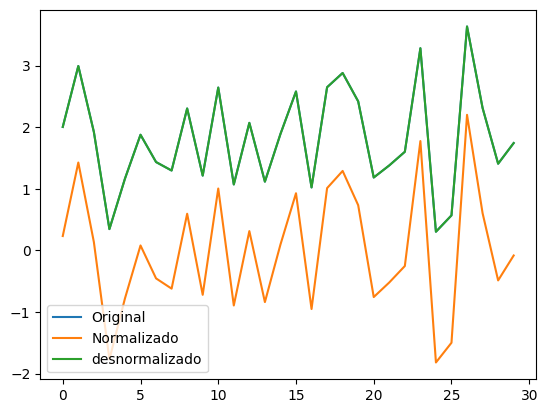

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 3.67 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-10-14 14:23:17.275648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 14:23:17.275742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 14:23:17.277159: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 14:23:17.289370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 14:23:20.626925: W tensorflow/compiler/tf2

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [ ]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36],
                            [4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_9,0.525893,0.426585,0.485508,0.568587,0.191584,0.340404,0.492641,0.221384,0.264257,0.437704,0.457006,0.440982,37.304854,86.694525
model_1_0_8,0.522120,0.423382,0.481814,0.565266,0.193109,0.342305,0.496178,0.223088,0.265814,0.439442,0.452684,0.442734,37.289000,86.678671
model_1_0_7,0.473415,0.381255,0.441269,0.519829,0.212790,0.367314,0.535001,0.246405,0.280391,0.461292,0.396903,0.464747,37.094896,86.484567
model_1_0_6,0.416871,0.332706,0.396748,0.466082,0.235639,0.396135,0.577632,0.273985,0.295111,0.485427,0.332143,0.489063,36.890904,86.280576
model_1_0_5,0.407044,0.324336,0.389048,0.456732,0.239611,0.401103,0.585004,0.278783,0.297607,0.489501,0.320888,0.493167,36.857479,86.247150
model_1_0_4,0.280108,0.217761,0.290193,0.336335,0.290905,0.464371,0.679661,0.340566,0.328795,0.539356,0.175508,0.543396,36.469517,85.859189
model_1_0_3,0.224734,0.172239,0.243213,0.285469,0.313281,0.491394,0.724646,0.366669,0.344381,0.559715,0.112089,0.563908,36.321308,85.710979
model_1_0_2,0.097730,0.068488,0.148665,0.164394,0.364603,0.552986,0.815179,0.428800,0.371250,0.603824,-0.033369,0.608347,36.017892,85.407563
model_1_0_1,-0.082258,-0.080894,0.012314,-0.005488,0.437335,0.641665,0.945739,0.515976,0.406456,0.661313,-0.239509,0.666267,35.654111,85.043782
model_1_0_0,-0.234364,-0.195496,-0.148430,-0.126048,0.498801,0.709698,1.099655,0.577843,0.440735,0.706258,-0.413716,0.711549,35.391098,84.780769


DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_1] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_1] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_9,0.734159,0.610573,0.668598,0.753455,0.107425,0.231181,0.317328,0.101020,0.192156,0.327758,0.695532,0.330213,38.461920,87.851592
model_1_1_8,0.715626,0.593221,0.651241,0.739392,0.114914,0.241482,0.333947,0.106782,0.199352,0.338990,0.674307,0.341529,38.327140,87.716811
model_1_1_7,0.709598,0.587654,0.645510,0.734740,0.117350,0.244786,0.339435,0.108688,0.201699,0.342564,0.667403,0.345130,38.285191,87.674862
model_1_1_6,0.705011,0.583394,0.641573,0.731159,0.119204,0.247316,0.343204,0.110156,0.203233,0.345259,0.662149,0.347845,38.253842,87.643513
model_1_1_5,0.700675,0.579389,0.637803,0.727759,0.120956,0.249693,0.346814,0.111549,0.204702,0.347787,0.657184,0.350392,38.224663,87.614335
model_1_1_4,0.656383,0.539610,0.597290,0.692693,0.138854,0.273307,0.385607,0.125917,0.221342,0.372631,0.606456,0.375422,37.948664,87.338336
model_1_1_3,0.651207,0.534979,0.592884,0.688480,0.140945,0.276057,0.389826,0.127643,0.223037,0.375427,0.600528,0.378239,37.918764,87.308435
model_1_1_2,0.627243,0.514018,0.571029,0.668704,0.150629,0.288500,0.410753,0.135746,0.231988,0.388110,0.573082,0.391017,37.785866,87.175537
model_1_1_1,0.550837,0.447711,0.506568,0.604450,0.181505,0.327862,0.472476,0.162074,0.256330,0.426034,0.485574,0.429225,37.412949,86.802620
model_1_1_0,0.538943,0.437676,0.496433,0.594169,0.186311,0.333820,0.482180,0.166286,0.260177,0.431637,0.471952,0.434871,37.360677,86.750348


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_2] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_2] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_2] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_9,0.842627,0.721179,0.771724,0.838517,0.063594,0.165520,0.218581,0.080071,0.145866,0.252178,0.819761,0.254067,39.510487,88.900158
model_1_2_8,0.841089,0.719475,0.770214,0.836988,0.064215,0.166532,0.220027,0.080829,0.146524,0.253407,0.818000,0.255305,39.491034,88.880705
model_1_2_7,0.839401,0.717614,0.768594,0.835314,0.064897,0.167636,0.221578,0.081659,0.147226,0.254749,0.816066,0.256657,39.469903,88.859574
model_1_2_6,0.836157,0.714055,0.765452,0.832098,0.066208,0.169749,0.224587,0.083253,0.148586,0.257310,0.812351,0.259237,39.429901,88.819572
model_1_2_5,0.831165,0.708404,0.758944,0.827160,0.068226,0.173104,0.230818,0.085702,0.151570,0.261200,0.806633,0.263157,39.369872,88.759543
model_1_2_4,0.813982,0.689978,0.741375,0.810303,0.075169,0.184043,0.247641,0.094061,0.159721,0.274170,0.786953,0.276224,39.176030,88.565701
model_1_2_3,0.812716,0.688648,0.740024,0.809072,0.075681,0.184832,0.248934,0.094671,0.160387,0.275101,0.785504,0.277162,39.162467,88.552138
model_1_2_2,0.802132,0.677585,0.729226,0.798802,0.079957,0.191399,0.259274,0.099763,0.165502,0.282768,0.773382,0.284886,39.052521,88.442192
model_1_2_1,0.775957,0.651181,0.707500,0.773205,0.090535,0.207074,0.280077,0.112455,0.174895,0.300890,0.743404,0.303144,38.804043,88.193714
model_1_2_0,0.750092,0.625733,0.684594,0.748317,0.100987,0.222181,0.302010,0.124796,0.185114,0.317784,0.713781,0.320164,38.585537,87.975208


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_3] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.883867,0.767575,0.815241,0.864526,0.046929,0.137978,0.176913,0.053020,0.126267,0.216630,0.866993,0.218253,40.118254,89.507925
model_1_3_8,0.882918,0.766440,0.814230,0.863598,0.047312,0.138651,0.177880,0.053383,0.126693,0.217514,0.865906,0.219143,40.101972,89.491643
model_1_3_7,0.881946,0.765283,0.813202,0.862650,0.047705,0.139338,0.178864,0.053754,0.127125,0.218415,0.864793,0.220051,40.085442,89.475114
model_1_3_6,0.881159,0.764351,0.812317,0.861873,0.048023,0.139891,0.179712,0.054058,0.127507,0.219142,0.863891,0.220783,40.072142,89.461814
model_1_3_5,0.880215,0.763237,0.811309,0.860951,0.048405,0.140553,0.180677,0.054419,0.127961,0.220011,0.862810,0.221659,40.056318,89.445990
model_1_3_4,0.879204,0.762047,0.810248,0.859966,0.048813,0.141259,0.181693,0.054804,0.128444,0.220937,0.861653,0.222592,40.039515,89.429187
model_1_3_3,0.871875,0.753600,0.802012,0.852760,0.051775,0.146274,0.189580,0.057625,0.132133,0.227540,0.853259,0.229245,39.921709,89.311380
model_1_3_2,0.870808,0.752383,0.800895,0.851720,0.052206,0.146996,0.190649,0.058032,0.132643,0.228486,0.852036,0.230198,39.905117,89.294788
model_1_3_1,0.860311,0.740659,0.789817,0.841483,0.056448,0.153956,0.201257,0.062038,0.137692,0.237587,0.840014,0.239367,39.748883,89.138554
model_1_3_0,0.859854,0.740172,0.789140,0.840998,0.056632,0.154245,0.201904,0.062228,0.138001,0.237976,0.839490,0.239758,39.742345,89.132016


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_4] | 9 +++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.912302,0.804090,0.858695,0.879713,0.035438,0.116301,0.135304,0.047435,0.108740,0.188251,0.899560,0.189661,40.679921,90.069593
model_1_4_8,0.911912,0.803524,0.858092,0.879587,0.035596,0.116636,0.135881,0.047485,0.109009,0.188669,0.899113,0.190082,40.671047,90.060718
model_1_4_7,0.911516,0.802942,0.857473,0.879447,0.035756,0.116982,0.136474,0.047540,0.109279,0.189092,0.898659,0.190509,40.662077,90.051748
model_1_4_6,0.909208,0.799537,0.853432,0.879216,0.036688,0.119004,0.140343,0.047631,0.110936,0.191542,0.896016,0.192977,40.610584,90.000256
model_1_4_5,0.905022,0.793817,0.847087,0.877880,0.038380,0.122399,0.146419,0.048158,0.113587,0.195908,0.891222,0.197376,40.520437,89.910108
model_1_4_4,0.902985,0.791220,0.842684,0.879417,0.039203,0.123941,0.150634,0.047552,0.115242,0.197998,0.888889,0.199481,40.477995,89.867666
model_1_4_3,0.902490,0.790565,0.841907,0.879301,0.039403,0.124329,0.151378,0.047597,0.115553,0.198503,0.888322,0.199989,40.467814,89.857485
model_1_4_2,0.901420,0.789164,0.840281,0.879001,0.039836,0.125161,0.152935,0.047716,0.116220,0.199588,0.887097,0.201083,40.445993,89.835665
model_1_4_1,0.900366,0.787794,0.838653,0.878748,0.040262,0.125975,0.154495,0.047815,0.116879,0.200653,0.885889,0.202156,40.424711,89.814382
model_1_4_0,0.892775,0.778249,0.827081,0.876994,0.043329,0.131641,0.165575,0.048507,0.121492,0.208157,0.877195,0.209716,40.277860,89.667531


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_5] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.922044,0.817142,0.873120,0.917981,0.031502,0.108552,0.121491,0.039339,0.104079,0.177487,0.910717,0.178817,40.915427,90.305098
model_1_5_8,0.921975,0.817004,0.872939,0.917916,0.031530,0.108635,0.121664,0.039370,0.104115,0.177566,0.910638,0.178896,40.913658,90.303329
model_1_5_7,0.920696,0.814726,0.870777,0.916393,0.032046,0.109987,0.123735,0.040100,0.104742,0.179015,0.909173,0.180356,40.881143,90.270814
model_1_5_6,0.918970,0.811795,0.868022,0.914349,0.032744,0.111727,0.126373,0.041081,0.105560,0.180952,0.907197,0.182308,40.838087,90.227758
model_1_5_5,0.918833,0.811557,0.867760,0.914201,0.032799,0.111868,0.126624,0.041152,0.105629,0.181106,0.907039,0.182462,40.834698,90.224369
model_1_5_4,0.917589,0.809518,0.865924,0.912688,0.033302,0.113078,0.128382,0.041878,0.106240,0.182488,0.905615,0.183855,40.804288,90.193959
model_1_5_3,0.916912,0.808398,0.864726,0.911950,0.033575,0.113743,0.129529,0.042232,0.106575,0.183236,0.904839,0.184609,40.787920,90.177591
model_1_5_2,0.916623,0.807940,0.864317,0.911598,0.033692,0.114015,0.129920,0.042400,0.106717,0.183554,0.904509,0.184929,40.780982,90.170654
model_1_5_1,0.915863,0.806741,0.863182,0.910705,0.034000,0.114727,0.131008,0.042829,0.107086,0.184390,0.903637,0.185771,40.762816,90.152487
model_1_5_0,0.913577,0.803261,0.859898,0.908048,0.034923,0.116793,0.134152,0.044103,0.108143,0.186877,0.901020,0.188277,40.709222,90.098893


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_6] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.924422,0.820869,0.876208,0.896946,0.030541,0.106340,0.118534,0.062982,0.102766,0.174760,0.913440,0.176069,40.977378,90.367049
model_1_6_8,0.924323,0.820700,0.876073,0.896934,0.030581,0.106440,0.118664,0.062989,0.102814,0.174874,0.913327,0.176184,40.974761,90.364432
model_1_6_7,0.924226,0.820538,0.875941,0.896930,0.030620,0.106537,0.118790,0.062992,0.102861,0.174985,0.913217,0.176296,40.972223,90.361894
model_1_6_6,0.924126,0.820369,0.875805,0.896923,0.030660,0.106637,0.118920,0.062996,0.102910,0.175100,0.913102,0.176412,40.969583,90.359254
model_1_6_5,0.924021,0.820194,0.875665,0.896911,0.030703,0.106741,0.119054,0.063004,0.102962,0.175222,0.912982,0.176534,40.966817,90.356488
model_1_6_4,0.923699,0.819663,0.875241,0.896883,0.030833,0.107056,0.119460,0.063021,0.103123,0.175593,0.912612,0.176909,40.958337,90.348009
model_1_6_3,0.923593,0.819509,0.875069,0.897043,0.030876,0.107147,0.119625,0.062923,0.103190,0.175714,0.912491,0.177031,40.955579,90.345251
model_1_6_2,0.922959,0.818520,0.874241,0.897129,0.031132,0.107734,0.120418,0.062871,0.103571,0.176443,0.911764,0.177765,40.939033,90.328704
model_1_6_1,0.922848,0.818352,0.874099,0.897148,0.031177,0.107834,0.120554,0.062858,0.103635,0.176570,0.911638,0.177892,40.936161,90.325832
model_1_6_0,0.922458,0.817760,0.873620,0.897147,0.031334,0.108185,0.121013,0.062859,0.103853,0.177015,0.911192,0.178341,40.926089,90.315760


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.928915,0.832827,0.883865,0.914179,0.028725,0.099241,0.111203,0.023145,0.100764,0.169485,0.918587,0.170754,41.099971,90.489643
model_1_7_8,0.928808,0.832512,0.883664,0.914265,0.028768,0.099428,0.111395,0.023121,0.100815,0.169613,0.918464,0.170883,41.096952,90.486623
model_1_7_7,0.928447,0.831406,0.882943,0.914625,0.028914,0.100085,0.112085,0.023024,0.100978,0.170042,0.918050,0.171316,41.086842,90.476513
model_1_7_6,0.927666,0.829188,0.881523,0.915206,0.029230,0.101401,0.113445,0.022867,0.101330,0.170967,0.917156,0.172248,41.065139,90.454810
model_1_7_5,0.927459,0.828597,0.881137,0.915374,0.029313,0.101752,0.113815,0.022822,0.101419,0.171211,0.916919,0.172494,41.059423,90.449094
model_1_7_4,0.927109,0.827639,0.880520,0.915606,0.029455,0.102321,0.114406,0.022759,0.101566,0.171624,0.916518,0.172910,41.049791,90.439463
model_1_7_3,0.926803,0.826859,0.880032,0.915737,0.029579,0.102784,0.114873,0.022724,0.101696,0.171984,0.916167,0.173273,41.041410,90.431081
model_1_7_2,0.926651,0.826475,0.879789,0.915803,0.029640,0.103012,0.115106,0.022706,0.101759,0.172162,0.915994,0.173452,41.037268,90.426939
model_1_7_1,0.926506,0.826106,0.879555,0.915870,0.029698,0.103231,0.115330,0.022688,0.101818,0.172332,0.915828,0.173623,41.033326,90.422997
model_1_7_0,0.925461,0.823417,0.877830,0.916410,0.030121,0.104827,0.116982,0.022543,0.102279,0.173553,0.914631,0.174853,41.005085,90.394757


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_8] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_9,0.930796,0.834753,0.885736,0.913040,0.027965,0.098098,0.109411,0.050696,0.100486,0.167227,0.920741,0.168480,41.153605,90.543276
model_1_8_8,0.930734,0.834652,0.885657,0.913039,0.027990,0.098158,0.109487,0.050696,0.100495,0.167302,0.920670,0.168555,41.151819,90.541490
model_1_8_7,0.930534,0.834394,0.885431,0.913089,0.028071,0.098311,0.109704,0.050667,0.100508,0.167543,0.920441,0.168798,41.146058,90.535729
model_1_8_3,0.929751,0.833760,0.884666,0.913525,0.028387,0.098687,0.110436,0.050413,0.100541,0.168485,0.919544,0.169748,41.123623,90.513294
model_1_8_2,0.929648,0.833641,0.884562,0.913533,0.028429,0.098758,0.110535,0.050408,0.100563,0.168608,0.919426,0.169871,41.120706,90.510377
model_1_8_1,0.929592,0.833571,0.884505,0.913534,0.028452,0.098799,0.110590,0.050408,0.100575,0.168676,0.919361,0.169940,41.119097,90.508769
model_1_8_0,0.929538,0.833510,0.884451,0.913538,0.028473,0.098836,0.110641,0.050405,0.100589,0.168741,0.919300,0.170005,41.117572,90.507243
model_1_8_6,0.929858,0.833400,0.884648,0.913052,0.028344,0.098901,0.110453,0.050689,0.100611,0.168357,0.919667,0.169618,41.126682,90.516353
model_1_8_5,0.929808,0.833331,0.884593,0.913047,0.028364,0.098942,0.110506,0.050691,0.100624,0.168417,0.919609,0.169679,41.125250,90.514922
model_1_8_4,0.929757,0.833261,0.884537,0.913043,0.028385,0.098984,0.110559,0.050694,0.100637,0.168478,0.919551,0.169740,41.123803,90.513475


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_9] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_7,0.931646,0.837271,0.887453,0.957139,0.027622,0.096603,0.107767,0.019164,0.100345,0.166197,0.921714,0.167442,41.178319,90.567991
model_1_9_9,0.931286,0.836452,0.887175,0.954293,0.027767,0.097089,0.108034,0.020436,0.100483,0.166634,0.921302,0.167882,41.167825,90.557496
model_1_9_8,0.931228,0.836130,0.886914,0.955171,0.027791,0.097280,0.108284,0.020044,0.100496,0.166705,0.921235,0.167954,41.166115,90.555786
model_1_9_6,0.931255,0.835884,0.886413,0.961432,0.027780,0.097426,0.108762,0.017244,0.100404,0.166672,0.921266,0.167921,41.166903,90.556575
model_1_9_5,0.931222,0.835798,0.886359,0.961591,0.027793,0.097477,0.108815,0.017173,0.100410,0.166712,0.921229,0.167961,41.165954,90.555625
model_1_9_4,0.931145,0.835597,0.886236,0.961892,0.027824,0.097597,0.108933,0.017039,0.100426,0.166805,0.921141,0.168054,41.163720,90.553392
model_1_9_3,0.931076,0.835427,0.886130,0.962224,0.027852,0.097698,0.109034,0.016890,0.100437,0.166888,0.921062,0.168138,41.161721,90.551393
model_1_9_2,0.930989,0.835211,0.886002,0.962528,0.027887,0.097826,0.109157,0.016754,0.100453,0.166994,0.920962,0.168245,41.159187,90.548858
model_1_9_1,0.930943,0.835099,0.885936,0.962681,0.027906,0.097892,0.109220,0.016686,0.100461,0.167050,0.920909,0.168301,41.157848,90.547519
model_1_9_0,0.930895,0.834984,0.885869,0.962833,0.027925,0.097961,0.109284,0.016618,0.100470,0.167108,0.920854,0.168360,41.156456,90.546127


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_10] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_10] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_10] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_9,0.932310,0.848607,0.895303,0.928520,0.027353,0.089873,0.100251,0.025638,0.100073,0.165388,0.922475,0.166627,41.197853,90.587524
model_1_10_8,0.932305,0.848460,0.895206,0.928658,0.027355,0.089961,0.100343,0.025588,0.100072,0.165394,0.922469,0.166633,41.197696,90.587367
model_1_10_7,0.932306,0.847374,0.894463,0.929858,0.027355,0.090605,0.101054,0.025157,0.100060,0.165393,0.922470,0.166632,41.197724,90.587395
model_1_10_6,0.932303,0.847245,0.894375,0.929993,0.027356,0.090682,0.101139,0.025109,0.100060,0.165396,0.922467,0.166635,41.197649,90.587320
model_1_10_5,0.932246,0.845243,0.893022,0.932030,0.027379,0.091871,0.102435,0.024379,0.100045,0.165467,0.922401,0.166706,41.195944,90.585616
model_1_10_4,0.932198,0.844276,0.892372,0.932960,0.027399,0.092445,0.103057,0.024045,0.100070,0.165525,0.922346,0.166765,41.194524,90.584196
model_1_10_3,0.932050,0.842803,0.891414,0.934138,0.027458,0.093319,0.103975,0.023622,0.100131,0.165705,0.922177,0.166946,41.190181,90.579852
model_1_10_2,0.932036,0.841859,0.890730,0.935252,0.027464,0.093879,0.104629,0.023223,0.100187,0.165723,0.922161,0.166964,41.189759,90.579430
model_1_10_1,0.931538,0.838040,0.888223,0.938068,0.027665,0.096146,0.107030,0.022213,0.100388,0.166329,0.921590,0.167575,41.175154,90.564826
model_1_10_0,0.931342,0.836757,0.887372,0.938976,0.027744,0.096908,0.107845,0.021887,0.100461,0.166566,0.921366,0.167814,41.169451,90.559122


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_11] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_11] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_0,0.932330,0.848476,0.895252,0.915797,0.027345,0.089951,0.100299,0.034136,0.100063,0.165364,0.922498,0.166602,41.198432,90.588103
model_1_11_1,0.932347,0.848339,0.895199,0.915599,0.027338,0.090032,0.100350,0.034216,0.100055,0.165342,0.922517,0.166581,41.198946,90.588617
model_1_11_2,0.931870,0.844614,0.893208,0.913205,0.027531,0.092244,0.102257,0.035186,0.100194,0.165924,0.921971,0.167167,41.184899,90.574571
model_1_11_3,0.932051,0.843092,0.892714,0.910426,0.027458,0.093147,0.102730,0.036313,0.100076,0.165704,0.922178,0.166946,41.190200,90.579872
model_1_11_4,0.932060,0.843027,0.892699,0.910278,0.027454,0.093186,0.102744,0.036373,0.100071,0.165693,0.922188,0.166934,41.190471,90.580142
model_1_11_5,0.932075,0.842893,0.892662,0.909988,0.027448,0.093266,0.102779,0.036491,0.100068,0.165674,0.922206,0.166915,41.190923,90.580595
model_1_11_6,0.932081,0.842822,0.892644,0.909840,0.027446,0.093308,0.102797,0.036551,0.100068,0.165667,0.922213,0.166908,41.191100,90.580771
model_1_11_7,0.932089,0.842758,0.892625,0.909701,0.027443,0.093346,0.102815,0.036607,0.100068,0.165658,0.922221,0.166899,41.191313,90.580985
model_1_11_8,0.932056,0.842530,0.892525,0.909476,0.027456,0.093481,0.102911,0.036698,0.100076,0.165698,0.922184,0.166939,41.190348,90.580019
model_1_11_9,0.932039,0.842289,0.892435,0.909136,0.027463,0.093624,0.102997,0.036836,0.100082,0.165719,0.922164,0.166960,41.189849,90.579520


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_12] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_8,0.932239,0.842383,0.892167,0.925242,0.027382,0.093568,0.103253,0.037068,0.099886,0.165475,0.922393,0.166715,41.195734,90.585405
model_1_12_7,0.932228,0.842370,0.892178,0.925385,0.027386,0.093576,0.103243,0.036997,0.099895,0.165488,0.922381,0.166727,41.195434,90.585105
model_1_12_6,0.932218,0.842358,0.892191,0.925530,0.027390,0.093583,0.103231,0.036925,0.099906,0.165500,0.922370,0.166740,41.195141,90.584812
model_1_12_5,0.932207,0.842342,0.892200,0.925674,0.027395,0.093592,0.103222,0.036854,0.099918,0.165514,0.922357,0.166754,41.194798,90.584469
model_1_12_1,0.932096,0.842336,0.892396,0.927259,0.027440,0.093596,0.103034,0.036068,0.100036,0.165649,0.922230,0.166890,41.191536,90.581207
model_1_12_4,0.932194,0.842326,0.892210,0.925819,0.027400,0.093602,0.103212,0.036782,0.099930,0.165529,0.922342,0.166769,41.194431,90.584103
model_1_12_9,0.932260,0.842319,0.891997,0.924057,0.027373,0.093606,0.103416,0.037655,0.099855,0.165449,0.922418,0.166688,41.196370,90.586041
model_1_12_3,0.932182,0.842310,0.892221,0.925966,0.027405,0.093612,0.103202,0.036709,0.099941,0.165545,0.922328,0.166785,41.194059,90.583730
model_1_12_2,0.932169,0.842297,0.892233,0.926115,0.027410,0.093619,0.103190,0.036635,0.099953,0.165560,0.922313,0.166800,41.193685,90.583357
model_1_12_0,0.932057,0.842297,0.892417,0.927572,0.027456,0.093619,0.103014,0.035913,0.100067,0.165697,0.922184,0.166939,41.190368,90.580039


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_13] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_13] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_13] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_9,0.932683,0.846295,0.893749,0.915801,0.027203,0.091246,0.101738,0.024577,0.099069,0.164932,0.922902,0.166167,41.208891,90.598562
model_1_13_8,0.932673,0.846203,0.893703,0.915882,0.027207,0.091301,0.101783,0.024554,0.099082,0.164944,0.922890,0.166180,41.208596,90.598267
model_1_13_7,0.932657,0.845942,0.893576,0.916258,0.027213,0.091455,0.101904,0.024444,0.099126,0.164963,0.922872,0.166199,41.208127,90.597798
model_1_13_6,0.932682,0.845411,0.893344,0.917828,0.027203,0.091771,0.102126,0.023986,0.099290,0.164933,0.922900,0.166169,41.208853,90.598525
model_1_13_5,0.932669,0.845309,0.893295,0.917922,0.027208,0.091831,0.102173,0.023958,0.099308,0.164949,0.922886,0.166184,41.208480,90.598151
model_1_13_4,0.932560,0.844424,0.892882,0.918831,0.027252,0.092357,0.102568,0.023693,0.099462,0.165082,0.922761,0.166318,41.205256,90.594927
model_1_13_3,0.932545,0.844314,0.892831,0.918933,0.027258,0.092422,0.102617,0.023663,0.099480,0.165101,0.922743,0.166338,41.204788,90.594460
model_1_13_2,0.932472,0.843766,0.892586,0.919605,0.027288,0.092747,0.102852,0.023467,0.099583,0.165189,0.922661,0.166427,41.202648,90.592319
model_1_13_1,0.932360,0.842894,0.892237,0.921002,0.027333,0.093265,0.103186,0.023059,0.099763,0.165327,0.922532,0.166566,41.199312,90.588983
model_1_13_0,0.932341,0.842783,0.892191,0.921124,0.027341,0.093331,0.103230,0.023023,0.099781,0.165351,0.922510,0.166589,41.198750,90.588421


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_14] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_14] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_9,0.932793,0.850288,0.899116,0.943177,0.027158,0.088875,0.096600,0.026085,0.099124,0.164797,0.923028,0.166031,41.212170,90.601841
model_1_14_7,0.932803,0.848603,0.897138,0.945077,0.027154,0.089876,0.098493,0.025213,0.099142,0.164784,0.923040,0.166019,41.212473,90.602144
model_1_14_8,0.932775,0.848596,0.897225,0.944867,0.027165,0.089880,0.098410,0.025309,0.099151,0.164818,0.923008,0.166053,41.211644,90.601316
model_1_14_6,0.932796,0.848445,0.896962,0.945220,0.027157,0.089970,0.098662,0.025147,0.099147,0.164793,0.923031,0.166028,41.212255,90.601926
model_1_14_5,0.932801,0.848109,0.896500,0.945713,0.027155,0.090169,0.099104,0.024921,0.099147,0.164787,0.923037,0.166021,41.212409,90.602080
model_1_14_4,0.932822,0.848097,0.896396,0.945920,0.027146,0.090176,0.099204,0.024826,0.099139,0.164761,0.923061,0.165995,41.213036,90.602707
model_1_14_3,0.932813,0.847941,0.896215,0.946068,0.027150,0.090269,0.099377,0.024758,0.099141,0.164772,0.923051,0.166007,41.212763,90.602434
model_1_14_2,0.932794,0.847633,0.895852,0.946367,0.027158,0.090452,0.099725,0.024621,0.099145,0.164795,0.923029,0.166030,41.212204,90.601875
model_1_14_1,0.932728,0.846605,0.894462,0.947632,0.027184,0.091062,0.101056,0.024040,0.099123,0.164877,0.922953,0.166112,41.210219,90.599890
model_1_14_0,0.932717,0.846502,0.894296,0.947791,0.027189,0.091123,0.101214,0.023967,0.099115,0.164890,0.922941,0.166125,41.209914,90.599586


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 25ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_15] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_15] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_1,0.933013,0.850322,0.898844,0.918605,0.027069,0.088855,0.096860,0.025543,0.099530,0.164527,0.923280,0.165759,41.218732,90.608403
model_1_15_2,0.933021,0.850312,0.898823,0.918449,0.027066,0.088861,0.096879,0.025592,0.099555,0.164517,0.923290,0.165749,41.218975,90.608647
model_1_15_3,0.933022,0.850256,0.898779,0.918309,0.027066,0.088894,0.096922,0.025635,0.099580,0.164516,0.923290,0.165749,41.218984,90.608656
model_1_15_0,0.932866,0.850220,0.898982,0.920317,0.027129,0.088916,0.096727,0.025005,0.099275,0.164707,0.923111,0.165941,41.214339,90.604010
model_1_15_4,0.933056,0.850189,0.898658,0.917403,0.027052,0.088934,0.097038,0.025920,0.099722,0.164474,0.923329,0.165706,41.220014,90.609685
model_1_15_5,0.933067,0.850184,0.898628,0.917104,0.027047,0.088937,0.097066,0.026014,0.099766,0.164460,0.923342,0.165692,41.220347,90.610018
model_1_15_6,0.933075,0.850001,0.898425,0.916075,0.027044,0.089046,0.097261,0.026337,0.099935,0.164450,0.923351,0.165682,41.220586,90.610257
model_1_15_7,0.933006,0.849312,0.897749,0.912647,0.027072,0.089455,0.097908,0.027413,0.100514,0.164535,0.923272,0.165768,41.218525,90.608196
model_1_15_8,0.933004,0.849294,0.897731,0.912536,0.027073,0.089466,0.097925,0.027447,0.100531,0.164538,0.923269,0.165771,41.218448,90.608120
model_1_15_9,0.932985,0.849217,0.897637,0.911873,0.027080,0.089511,0.098015,0.027655,0.100633,0.164561,0.923248,0.165794,41.217898,90.607569


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_16] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_16] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_16] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_16] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_8,0.933143,0.851057,0.896484,0.927387,0.027017,0.088419,0.099120,0.025825,0.100179,0.164368,0.923428,0.165599,41.222595,90.612266
model_1_16_7,0.933163,0.850988,0.896571,0.927887,0.027008,0.088460,0.099036,0.025647,0.100198,0.164343,0.923452,0.165574,41.223210,90.612881
model_1_16_9,0.933108,0.850955,0.896347,0.927026,0.027031,0.088480,0.099250,0.025953,0.100169,0.164411,0.923388,0.165642,41.221551,90.611222
model_1_16_6,0.933164,0.850856,0.896586,0.928209,0.027008,0.088539,0.099022,0.025533,0.100215,0.164341,0.923453,0.165572,41.223245,90.612917
model_1_16_5,0.933149,0.850149,0.896662,0.929877,0.027014,0.088958,0.098949,0.024939,0.100297,0.164360,0.923435,0.165591,41.222781,90.612452
model_1_16_4,0.933149,0.849885,0.896920,0.931376,0.027014,0.089115,0.098702,0.024406,0.100387,0.164360,0.923435,0.165591,41.222784,90.612455
model_1_16_3,0.933143,0.849831,0.896943,0.931565,0.027017,0.089147,0.098681,0.024339,0.100400,0.164367,0.923429,0.165598,41.222608,90.612279
model_1_16_2,0.933102,0.849510,0.897148,0.932929,0.027033,0.089338,0.098484,0.023854,0.100487,0.164418,0.923381,0.165650,41.221374,90.611045
model_1_16_1,0.933089,0.849440,0.897167,0.933125,0.027038,0.089379,0.098466,0.023784,0.100501,0.164433,0.923367,0.165665,41.221002,90.610674
model_1_16_0,0.933026,0.849382,0.897604,0.934846,0.027064,0.089413,0.098047,0.023172,0.100605,0.164511,0.923294,0.165744,41.219102,90.608774


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_17] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_17] | 6 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_17] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_17] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_17] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_0,0.933056,0.850050,0.895782,0.911400,0.027052,0.089017,0.099792,0.038536,0.100060,0.164474,0.923329,0.165706,41.220015,90.609686
model_1_17_1,0.932934,0.849233,0.895324,0.910817,0.027101,0.089502,0.100230,0.038789,0.100058,0.164623,0.923190,0.165857,41.216378,90.606049
model_1_17_2,0.932998,0.849142,0.895206,0.910126,0.027075,0.089556,0.100344,0.039090,0.099977,0.164546,0.923262,0.165778,41.218263,90.607934
model_1_17_3,0.933013,0.849128,0.895181,0.909961,0.027069,0.089564,0.100367,0.039161,0.099958,0.164527,0.923280,0.165759,41.218722,90.608394
model_1_17_4,0.933021,0.849077,0.895136,0.909779,0.027066,0.089594,0.100410,0.039240,0.099942,0.164517,0.923289,0.165750,41.218962,90.608633
model_1_17_5,0.933109,0.848598,0.894549,0.906773,0.027030,0.089879,0.100972,0.040548,0.099668,0.164409,0.923390,0.165640,41.221602,90.611274
model_1_17_6,0.933108,0.848555,0.894493,0.906488,0.027031,0.089905,0.101026,0.040672,0.099647,0.164410,0.923389,0.165642,41.221560,90.611231
model_1_17_7,0.932950,0.847683,0.893753,0.904244,0.027095,0.090422,0.101735,0.041648,0.099617,0.164605,0.923207,0.165838,41.216837,90.606509
model_1_17_8,0.932894,0.847403,0.893599,0.903985,0.027117,0.090588,0.101882,0.041761,0.099627,0.164673,0.923144,0.165906,41.215181,90.604852
model_1_17_9,0.932832,0.847212,0.893414,0.903125,0.027142,0.090701,0.102059,0.042134,0.099635,0.164750,0.923072,0.165984,41.213314,90.602985


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_18] | 4 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_18] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_18] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_18] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_9,0.933278,0.855360,0.895618,0.867946,0.026962,0.085864,0.099949,0.041692,0.099259,0.164201,0.923583,0.165431,41.226654,90.616325
model_1_18_8,0.933281,0.854841,0.895429,0.868950,0.026961,0.086173,0.100129,0.041375,0.099280,0.164198,0.923586,0.165428,41.226732,90.616404
model_1_18_7,0.933265,0.853723,0.895044,0.871026,0.026967,0.086836,0.100499,0.040720,0.099321,0.164217,0.923569,0.165447,41.226268,90.615939
model_1_18_6,0.933262,0.853550,0.894990,0.871353,0.026968,0.086939,0.100550,0.040616,0.099328,0.164221,0.923565,0.165451,41.226178,90.615849
model_1_18_5,0.933242,0.852816,0.894757,0.872700,0.026977,0.087375,0.100773,0.040191,0.099352,0.164245,0.923542,0.165476,41.225573,90.615245
model_1_18_4,0.933184,0.851751,0.894401,0.874511,0.027000,0.088007,0.101114,0.039619,0.099388,0.164317,0.923476,0.165548,41.223835,90.613506
model_1_18_3,0.933168,0.851523,0.894326,0.874884,0.027007,0.088142,0.101186,0.039502,0.099397,0.164337,0.923457,0.165568,41.223355,90.613026
model_1_18_2,0.932906,0.848544,0.893426,0.879609,0.027112,0.089911,0.102048,0.038010,0.099576,0.164658,0.923158,0.165891,41.215540,90.605212
model_1_18_1,0.932948,0.848075,0.893654,0.881148,0.027095,0.090189,0.101829,0.037524,0.099589,0.164606,0.923206,0.165839,41.216795,90.606466
model_1_18_0,0.932873,0.847505,0.893495,0.881940,0.027126,0.090528,0.101981,0.037274,0.099620,0.164699,0.923119,0.165933,41.214536,90.604207


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_19] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_19] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_19] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_19] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_0,0.933265,0.854871,0.895526,0.914203,0.026967,0.086155,0.100036,0.032892,0.099250,0.164217,0.923568,0.165448,41.226256,90.615928
model_1_19_1,0.933219,0.854151,0.895848,0.911654,0.026986,0.086582,0.099728,0.033869,0.099166,0.164274,0.923515,0.165505,41.224870,90.614541
model_1_19_2,0.933135,0.853707,0.896138,0.909427,0.027020,0.086846,0.099451,0.034723,0.099129,0.164377,0.923419,0.165609,41.222364,90.612036
model_1_19_3,0.933119,0.853638,0.896188,0.909055,0.027026,0.086887,0.099403,0.034865,0.099123,0.164397,0.923401,0.165628,41.221886,90.611557
model_1_19_4,0.933111,0.853635,0.896269,0.908756,0.027029,0.086889,0.099326,0.034980,0.099113,0.164406,0.923392,0.165638,41.221661,90.611332
model_1_19_6,0.933085,0.853628,0.896511,0.907859,0.027040,0.086893,0.099094,0.035324,0.099081,0.164439,0.923362,0.165671,41.220862,90.610533
model_1_19_5,0.933093,0.853625,0.896429,0.908152,0.027037,0.086894,0.099173,0.035212,0.099092,0.164428,0.923372,0.165660,41.221125,90.610796
model_1_19_7,0.933072,0.853612,0.896585,0.907544,0.027045,0.086902,0.099023,0.035445,0.099071,0.164454,0.923348,0.165686,41.220497,90.610168
model_1_19_8,0.932279,0.851706,0.897228,0.898924,0.027366,0.088033,0.098408,0.038749,0.099177,0.165426,0.922439,0.166666,41.196915,90.586586
model_1_19_9,0.932215,0.851533,0.897206,0.898444,0.027392,0.088137,0.098428,0.038933,0.099191,0.165504,0.922366,0.166744,41.195032,90.584703


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_20] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_20] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_20] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_0,0.932260,0.851449,0.897185,0.892005,0.027374,0.088186,0.098448,0.038822,0.099148,0.165450,0.922417,0.166689,41.196354,90.586025
model_1_20_1,0.932264,0.851338,0.897140,0.891660,0.027372,0.088252,0.098491,0.038946,0.099134,0.165444,0.922422,0.166683,41.196494,90.586165
model_1_20_2,0.932375,0.850914,0.897007,0.889132,0.027327,0.088504,0.098618,0.039855,0.098977,0.165309,0.922549,0.166547,41.199756,90.589427
model_1_20_3,0.932389,0.850884,0.897004,0.888825,0.027321,0.088522,0.098622,0.039965,0.098956,0.165292,0.922565,0.166530,41.200167,90.589839
model_1_20_4,0.932406,0.850872,0.897010,0.888528,0.027314,0.088529,0.098616,0.040072,0.098932,0.165271,0.922585,0.166509,41.200680,90.590351
model_1_20_5,0.932438,0.850354,0.896863,0.885214,0.027301,0.088836,0.098756,0.041263,0.098770,0.165231,0.922622,0.166469,41.201636,90.591307
model_1_20_6,0.932444,0.850339,0.896866,0.884929,0.027299,0.088845,0.098753,0.041365,0.098754,0.165224,0.922628,0.166462,41.201804,90.591476
model_1_20_7,0.932449,0.850324,0.896870,0.884648,0.027297,0.088854,0.098750,0.041467,0.098738,0.165218,0.922634,0.166456,41.201951,90.591622
model_1_20_8,0.932452,0.850192,0.896867,0.882978,0.027296,0.088932,0.098753,0.042067,0.098651,0.165214,0.922638,0.166451,41.202057,90.591728
model_1_20_9,0.932226,0.849223,0.896520,0.878866,0.027387,0.089508,0.099086,0.043545,0.098623,0.165490,0.922379,0.166730,41.195372,90.585043


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_21] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_21] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_21] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_21] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_9,0.932509,0.853746,0.896997,0.925031,0.027273,0.086822,0.098629,0.026887,0.098960,0.165144,0.922703,0.166381,41.203740,90.593411
model_1_21_8,0.932507,0.853431,0.896933,0.925564,0.027274,0.087010,0.098690,0.026696,0.098921,0.165147,0.922700,0.166384,41.203676,90.593347
model_1_21_7,0.932504,0.853316,0.896907,0.925748,0.027275,0.087078,0.098715,0.026630,0.098909,0.165150,0.922697,0.166388,41.203595,90.593266
model_1_21_6,0.932511,0.853270,0.896917,0.925889,0.027272,0.087105,0.098705,0.026579,0.098897,0.165143,0.922705,0.166380,41.203781,90.593452
model_1_21_5,0.932459,0.851838,0.896678,0.928254,0.027293,0.087955,0.098934,0.025731,0.098808,0.165206,0.922645,0.166443,41.202252,90.591924
model_1_21_4,0.932410,0.850975,0.896567,0.929717,0.027313,0.088468,0.099040,0.025207,0.098741,0.165266,0.922589,0.166504,41.200790,90.590461
model_1_21_3,0.932396,0.850838,0.896540,0.929914,0.027319,0.088549,0.099066,0.025136,0.098738,0.165283,0.922573,0.166522,41.200373,90.590045
model_1_21_2,0.932336,0.850216,0.896447,0.930874,0.027343,0.088918,0.099155,0.024791,0.098710,0.165357,0.922504,0.166595,41.198605,90.588276
model_1_21_1,0.932319,0.849834,0.896626,0.932009,0.027350,0.089145,0.098984,0.024385,0.098620,0.165378,0.922485,0.166616,41.198098,90.587769
model_1_21_0,0.932293,0.849666,0.896590,0.932222,0.027360,0.089245,0.099018,0.024308,0.098623,0.165409,0.922455,0.166648,41.197332,90.587003


DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_22] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_22] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_22] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_22] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_22] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_22] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_0,0.932522,0.853659,0.896951,0.916482,0.027268,0.086874,0.098672,0.020629,0.098981,0.165129,0.922717,0.166366,41.204112,90.593783
model_1_22_1,0.932747,0.853466,0.896914,0.910780,0.027177,0.086989,0.098708,0.022038,0.099254,0.164853,0.922975,0.166088,41.210796,90.600467
model_1_22_2,0.932730,0.853117,0.896756,0.909568,0.027183,0.087196,0.098859,0.022337,0.099300,0.164874,0.922956,0.166109,41.210303,90.599974
model_1_22_3,0.932749,0.852903,0.896712,0.906889,0.027176,0.087323,0.098902,0.022999,0.099412,0.164851,0.922977,0.166086,41.210855,90.600527
model_1_22_4,0.932753,0.852900,0.896721,0.906519,0.027174,0.087325,0.098893,0.023090,0.099427,0.164846,0.922982,0.166080,41.210983,90.600655
model_1_22_5,0.932721,0.852507,0.896599,0.903552,0.027187,0.087559,0.099010,0.023823,0.099543,0.164885,0.922945,0.166120,41.210019,90.599690
model_1_22_6,0.932660,0.852168,0.896509,0.901111,0.027212,0.087760,0.099096,0.024426,0.099634,0.164959,0.922876,0.166195,41.208222,90.597894
model_1_22_7,0.932655,0.852141,0.896509,0.900776,0.027214,0.087775,0.099096,0.024509,0.099646,0.164966,0.922870,0.166202,41.208056,90.597727
model_1_22_8,0.932539,0.851663,0.896391,0.897509,0.027261,0.088059,0.099209,0.025315,0.099763,0.165108,0.922737,0.166345,41.204613,90.594284
model_1_22_9,0.932520,0.851609,0.896391,0.896892,0.027268,0.088091,0.099208,0.025468,0.099784,0.165131,0.922715,0.166368,41.204060,90.593731


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_23] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_23] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_23] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_23] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_23] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_23] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_9,0.932870,0.854046,0.898735,0.933414,0.027127,0.086644,0.096964,0.028868,0.100030,0.164702,0.923116,0.165936,41.214467,90.604139
model_1_23_8,0.932860,0.853768,0.898495,0.933702,0.027131,0.086810,0.097194,0.028743,0.100000,0.164714,0.923105,0.165948,41.214173,90.603844
model_1_23_7,0.932838,0.853395,0.898167,0.934088,0.027140,0.087031,0.097509,0.028576,0.099959,0.164741,0.923080,0.165975,41.213516,90.603187
model_1_23_6,0.932769,0.852693,0.897582,0.934710,0.027168,0.087448,0.098069,0.028306,0.099893,0.164826,0.923000,0.166061,41.211454,90.601125
model_1_23_5,0.932759,0.852614,0.897467,0.934885,0.027172,0.087495,0.098179,0.028230,0.099875,0.164838,0.922989,0.166073,41.211168,90.600839
model_1_23_4,0.932712,0.852359,0.897198,0.935210,0.027191,0.087646,0.098436,0.028089,0.099838,0.164896,0.922936,0.166131,41.209768,90.599440
model_1_23_3,0.932691,0.852238,0.897092,0.935310,0.027199,0.087718,0.098537,0.028046,0.099828,0.164922,0.922911,0.166157,41.209143,90.598814
model_1_23_1,0.932655,0.852076,0.896919,0.935498,0.027214,0.087814,0.098703,0.027964,0.099808,0.164966,0.922870,0.166202,41.208068,90.597740
model_1_23_2,0.932657,0.852054,0.896930,0.935462,0.027213,0.087827,0.098693,0.027980,0.099811,0.164963,0.922872,0.166199,41.208132,90.597803
model_1_23_0,0.932551,0.851736,0.896509,0.935977,0.027256,0.088016,0.099096,0.027757,0.099784,0.165093,0.922751,0.166330,41.204976,90.594647


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_24] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_24] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_24] | 5 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_24] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_24] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_24] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_9,0.933322,0.860935,0.902675,0.913821,0.026944,0.082555,0.093192,0.035231,0.099703,0.164147,0.923634,0.165376,41.227983,90.617654
model_1_24_8,0.933326,0.860872,0.902640,0.913973,0.026942,0.082592,0.093225,0.035169,0.099699,0.164142,0.923639,0.165371,41.228102,90.617773
model_1_24_7,0.933337,0.860764,0.902581,0.914274,0.026938,0.082657,0.093282,0.035046,0.099690,0.164129,0.923650,0.165359,41.228407,90.618079
model_1_24_6,0.933340,0.860475,0.902428,0.914683,0.026937,0.082828,0.093428,0.034879,0.099676,0.164125,0.923655,0.165354,41.228517,90.618188
model_1_24_5,0.933343,0.860443,0.902409,0.914819,0.026936,0.082847,0.093446,0.034823,0.099677,0.164122,0.923657,0.165351,41.228589,90.618260
model_1_24_4,0.933344,0.860165,0.902260,0.915221,0.026935,0.083012,0.093589,0.034659,0.099665,0.164120,0.923659,0.165350,41.228625,90.618296
model_1_24_3,0.933187,0.856732,0.900329,0.920033,0.026999,0.085050,0.095438,0.032691,0.099798,0.164313,0.923480,0.165543,41.223938,90.613609
model_1_24_2,0.933150,0.856328,0.900094,0.920503,0.027014,0.085290,0.095662,0.032499,0.099830,0.164359,0.923436,0.165590,41.222809,90.612480
model_1_24_1,0.933129,0.856119,0.899973,0.920741,0.027022,0.085414,0.095779,0.032402,0.099847,0.164385,0.923413,0.165616,41.222188,90.611859
model_1_24_0,0.933085,0.855718,0.899737,0.921207,0.027040,0.085652,0.096005,0.032212,0.099882,0.164438,0.923363,0.165670,41.220882,90.610553


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_25] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_25] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_0,0.933417,0.859680,0.902005,0.941955,0.026906,0.083300,0.093833,0.028902,0.099594,0.164030,0.923743,0.165259,41.230825,90.620496
model_1_25_1,0.933423,0.859593,0.901958,0.941829,0.026903,0.083352,0.093878,0.028964,0.099586,0.164023,0.923749,0.165251,41.231002,90.620674
model_1_25_2,0.933428,0.859509,0.901913,0.941705,0.026901,0.083402,0.093921,0.029026,0.099578,0.164016,0.923755,0.165245,41.231162,90.620833
model_1_25_3,0.933433,0.859419,0.901866,0.941580,0.026899,0.083455,0.093967,0.029089,0.099570,0.164011,0.923761,0.165239,41.231299,90.620970
model_1_25_4,0.933432,0.858693,0.901484,0.940747,0.026900,0.083886,0.094332,0.029504,0.099525,0.164012,0.923759,0.165240,41.231265,90.620937
model_1_25_5,0.933433,0.858617,0.901443,0.940628,0.026900,0.083931,0.094371,0.029562,0.099518,0.164011,0.923761,0.165239,41.231295,90.620966
model_1_25_6,0.933433,0.858540,0.901402,0.940511,0.026899,0.083977,0.094411,0.029621,0.099511,0.164010,0.923761,0.165239,41.231308,90.620979
model_1_25_7,0.933433,0.858464,0.901361,0.940394,0.026899,0.084022,0.094450,0.029679,0.099504,0.164010,0.923761,0.165239,41.231307,90.620979
model_1_25_8,0.933407,0.857714,0.900962,0.939248,0.026910,0.084467,0.094832,0.030250,0.099446,0.164043,0.923731,0.165271,41.230518,90.620189
model_1_25_9,0.933402,0.857637,0.900921,0.939136,0.026912,0.084513,0.094871,0.030305,0.099441,0.164048,0.923726,0.165277,41.230384,90.620056


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_26] | 3 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_26] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_26] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_26] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_9,0.932373,0.864492,0.908122,0.905695,0.027328,0.080444,0.087976,0.028259,0.100844,0.165311,0.922547,0.166549,41.199714,90.589386
model_1_26_8,0.932479,0.863957,0.907600,0.906883,0.027285,0.080761,0.088475,0.027903,0.100757,0.165182,0.922668,0.166419,41.202830,90.592501
model_1_26_7,0.932496,0.863851,0.907503,0.907101,0.027278,0.080824,0.088569,0.027838,0.100742,0.165161,0.922688,0.166398,41.203342,90.593013
model_1_26_6,0.932733,0.862766,0.906350,0.909715,0.027182,0.081468,0.089673,0.027055,0.100514,0.164870,0.922960,0.166105,41.210391,90.600062
model_1_26_5,0.932856,0.861998,0.905589,0.911336,0.027133,0.081924,0.090402,0.026569,0.100381,0.164720,0.923100,0.165954,41.214036,90.603708
model_1_26_4,0.932872,0.861899,0.905483,0.911556,0.027126,0.081982,0.090503,0.026503,0.100361,0.164699,0.923119,0.165933,41.214532,90.604203
model_1_26_3,0.933125,0.860593,0.903995,0.914849,0.027024,0.082758,0.091928,0.025516,0.100024,0.164390,0.923408,0.165621,41.222063,90.611734
model_1_26_2,0.933140,0.860448,0.903854,0.915133,0.027018,0.082844,0.092062,0.025431,0.100000,0.164371,0.923425,0.165603,41.222511,90.612182
model_1_26_1,0.933358,0.858160,0.901514,0.919889,0.026930,0.084202,0.094303,0.024006,0.099562,0.164102,0.923675,0.165332,41.229058,90.618729
model_1_26_0,0.933372,0.858068,0.901386,0.920166,0.026924,0.084257,0.094425,0.023923,0.099533,0.164086,0.923690,0.165315,41.229457,90.619128


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_27] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_27] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_27] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_0,0.932661,0.862607,0.906829,0.948561,0.027212,0.081563,0.089214,0.016870,0.100581,0.164959,0.922876,0.166195,41.208227,90.597898
model_1_27_1,0.932688,0.862558,0.906777,0.948447,0.027201,0.081591,0.089264,0.016908,0.100551,0.164926,0.922907,0.166161,41.209033,90.598705
model_1_27_2,0.932888,0.860934,0.905568,0.947014,0.027120,0.082555,0.090422,0.017378,0.100238,0.164680,0.923137,0.165914,41.215000,90.604671
model_1_27_3,0.932905,0.860890,0.905524,0.946902,0.027113,0.082582,0.090464,0.017415,0.100212,0.164660,0.923156,0.165893,41.215498,90.605170
model_1_27_4,0.932921,0.860846,0.905481,0.946789,0.027106,0.082608,0.090505,0.017451,0.100187,0.164640,0.923175,0.165873,41.215980,90.605652
model_1_27_5,0.932935,0.860780,0.905427,0.946679,0.027101,0.082647,0.090557,0.017487,0.100162,0.164623,0.923191,0.165856,41.216398,90.606070
model_1_27_6,0.932951,0.860753,0.905393,0.946566,0.027094,0.082663,0.090589,0.017525,0.100137,0.164603,0.923208,0.165836,41.216863,90.606534
model_1_27_7,0.932948,0.858582,0.903944,0.944869,0.027096,0.083952,0.091976,0.018081,0.099995,0.164607,0.923205,0.165840,41.216769,90.606440
model_1_27_8,0.932954,0.858536,0.903907,0.944764,0.027093,0.083979,0.092012,0.018116,0.099984,0.164600,0.923212,0.165833,41.216951,90.606623
model_1_27_9,0.932960,0.858493,0.903872,0.944659,0.027091,0.084005,0.092045,0.018150,0.099973,0.164592,0.923219,0.165825,41.217132,90.606803


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_28] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_28] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_28] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_28] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_9,0.933032,0.862225,0.907149,0.942910,0.027062,0.081789,0.088907,0.020210,0.099682,0.164504,0.923301,0.165736,41.219277,90.608948
model_1_28_8,0.933034,0.861497,0.906588,0.943970,0.027061,0.082221,0.089444,0.019835,0.099737,0.164501,0.923304,0.165734,41.219344,90.609016
model_1_28_7,0.933033,0.861385,0.906502,0.944127,0.027061,0.082288,0.089527,0.019779,0.099746,0.164503,0.923302,0.165735,41.219307,90.608978
model_1_28_6,0.933018,0.860606,0.905888,0.945232,0.027067,0.082750,0.090115,0.019388,0.099809,0.164521,0.923285,0.165754,41.218859,90.608531
model_1_28_5,0.933010,0.860368,0.905700,0.945561,0.027070,0.082892,0.090295,0.019271,0.099829,0.164531,0.923276,0.165763,41.218625,90.608296
model_1_28_4,0.933008,0.860277,0.905620,0.945706,0.027071,0.082945,0.090372,0.019220,0.099836,0.164533,0.923274,0.165766,41.218572,90.608243
model_1_28_3,0.933050,0.860039,0.905222,0.946605,0.027054,0.083087,0.090753,0.018902,0.099862,0.164482,0.923322,0.165714,41.219827,90.609498
model_1_28_2,0.933043,0.859903,0.905113,0.946786,0.027057,0.083168,0.090857,0.018838,0.099872,0.164491,0.923314,0.165723,41.219604,90.609276
model_1_28_1,0.933036,0.859775,0.905008,0.946962,0.027060,0.083244,0.090958,0.018775,0.099881,0.164499,0.923306,0.165731,41.219398,90.609069
model_1_28_0,0.932974,0.858648,0.903999,0.948652,0.027085,0.083913,0.091923,0.018177,0.099962,0.164575,0.923235,0.165808,41.217553,90.607225


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_29] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_29] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_29] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_29] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_29] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_29] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_0,0.933058,0.862085,0.906821,0.933395,0.027051,0.081872,0.089222,0.029782,0.099678,0.164472,0.923331,0.165704,41.220065,90.609736
model_1_29_1,0.933084,0.861983,0.906518,0.933124,0.027040,0.081933,0.089512,0.029903,0.099674,0.164439,0.923362,0.165671,41.220854,90.610525
model_1_29_2,0.933132,0.861382,0.905372,0.932283,0.027021,0.082290,0.090609,0.030279,0.099682,0.164381,0.923416,0.165613,41.222267,90.611938
model_1_29_3,0.933157,0.860908,0.904234,0.931287,0.027011,0.082571,0.091699,0.030724,0.099714,0.164350,0.923444,0.165582,41.223018,90.612689
model_1_29_4,0.933147,0.860507,0.903422,0.930615,0.027015,0.082809,0.092476,0.031025,0.099755,0.164363,0.923433,0.165594,41.222720,90.612392
model_1_29_5,0.933137,0.860366,0.903148,0.930384,0.027019,0.082893,0.092738,0.031128,0.099773,0.164375,0.923422,0.165606,41.222421,90.612092
model_1_29_6,0.933133,0.860310,0.903025,0.930273,0.027021,0.082926,0.092856,0.031178,0.099780,0.164380,0.923417,0.165611,41.222300,90.611972
model_1_29_7,0.932979,0.859106,0.901669,0.929489,0.027083,0.083641,0.094155,0.031528,0.099946,0.164569,0.923240,0.165802,41.217694,90.607365
model_1_29_8,0.932963,0.858925,0.901421,0.929336,0.027090,0.083748,0.094392,0.031597,0.099962,0.164589,0.923222,0.165822,41.217217,90.606888
model_1_29_9,0.932885,0.858449,0.900651,0.928686,0.027121,0.084031,0.095130,0.031887,0.100033,0.164684,0.923133,0.165917,41.214910,90.604581


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_30] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_30] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_0,0.932904,0.858170,0.900448,0.935876,0.027113,0.084197,0.095324,0.025670,0.099989,0.164661,0.923155,0.165894,41.215477,90.605148
model_1_30_1,0.932913,0.858152,0.900416,0.935776,0.027109,0.084207,0.095354,0.025710,0.099973,0.164650,0.923165,0.165883,41.215744,90.605415
model_1_30_2,0.932922,0.858134,0.900385,0.935677,0.027106,0.084218,0.095384,0.025749,0.099957,0.164639,0.923175,0.165872,41.215995,90.605667
model_1_30_3,0.932930,0.858116,0.900354,0.935579,0.027103,0.084228,0.095414,0.025788,0.099942,0.164629,0.923184,0.165863,41.216233,90.605904
model_1_30_4,0.932968,0.857681,0.899835,0.934124,0.027087,0.084487,0.095911,0.026371,0.099811,0.164582,0.923228,0.165815,41.217375,90.607047
model_1_30_5,0.932971,0.857653,0.899805,0.934039,0.027086,0.084503,0.095939,0.026405,0.099808,0.164579,0.923231,0.165812,41.217460,90.607131
model_1_30_6,0.932973,0.857621,0.899773,0.933957,0.027085,0.084523,0.095970,0.026438,0.099805,0.164576,0.923234,0.165809,41.217534,90.607205
model_1_30_7,0.932952,0.856745,0.899251,0.933605,0.027094,0.085042,0.096470,0.026579,0.099838,0.164601,0.923210,0.165834,41.216915,90.606586
model_1_30_8,0.932954,0.856727,0.899228,0.933522,0.027093,0.085053,0.096492,0.026612,0.099834,0.164600,0.923212,0.165833,41.216952,90.606623
model_1_30_9,0.932955,0.856707,0.899204,0.933441,0.027093,0.085065,0.096515,0.026644,0.099830,0.164598,0.923214,0.165831,41.216997,90.606668


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_31] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_31] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_31] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_31] | 7 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_31] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_0,0.932520,0.853766,0.897687,0.935587,0.027268,0.086811,0.097968,0.022486,0.100072,0.165131,0.922716,0.166368,41.204067,90.593739
model_1_31_1,0.932071,0.850343,0.896544,0.930597,0.027450,0.088843,0.099063,0.024228,0.100263,0.165680,0.922201,0.166921,41.190785,90.580456
model_1_31_2,0.932036,0.849914,0.896504,0.929799,0.027464,0.089098,0.099101,0.024507,0.100248,0.165722,0.922161,0.166963,41.189776,90.579447
model_1_31_3,0.932036,0.849841,0.896525,0.929588,0.027464,0.089141,0.099080,0.024580,0.100233,0.165723,0.922160,0.166964,41.189753,90.579424
model_1_31_4,0.932035,0.849708,0.896574,0.929184,0.027464,0.089220,0.099033,0.024721,0.100201,0.165723,0.922160,0.166965,41.189744,90.579415
model_1_31_5,0.932032,0.849621,0.896590,0.928974,0.027465,0.089271,0.099018,0.024795,0.100189,0.165727,0.922157,0.166968,41.189661,90.579332
model_1_31_6,0.932027,0.848736,0.897256,0.925717,0.027468,0.089797,0.098381,0.025932,0.099948,0.165734,0.922150,0.166975,41.189485,90.579156
model_1_31_7,0.932021,0.848669,0.897275,0.925554,0.027470,0.089837,0.098362,0.025988,0.099944,0.165741,0.922143,0.166983,41.189315,90.578986
model_1_31_8,0.932021,0.848647,0.897315,0.925424,0.027470,0.089850,0.098323,0.026034,0.099935,0.165741,0.922144,0.166982,41.189325,90.578996
model_1_31_9,0.932020,0.848597,0.897392,0.925162,0.027470,0.089879,0.098251,0.026125,0.099921,0.165742,0.922142,0.166984,41.189288,90.578959


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_32] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_32] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_32] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_9,0.932569,0.856413,0.899871,0.947795,0.027249,0.085239,0.095877,0.021175,0.100076,0.165072,0.922771,0.166308,41.205501,90.595172
model_1_32_8,0.932564,0.856229,0.899803,0.947893,0.027251,0.085349,0.095941,0.021135,0.100068,0.165078,0.922765,0.166315,41.205350,90.595021
model_1_32_7,0.932542,0.855172,0.899448,0.948520,0.027259,0.085976,0.096282,0.020881,0.100014,0.165104,0.922741,0.166341,41.204724,90.594396
model_1_32_6,0.932535,0.854914,0.899362,0.948672,0.027262,0.086129,0.096364,0.020819,0.100004,0.165113,0.922732,0.166350,41.204489,90.594160
model_1_32_5,0.932543,0.854571,0.899294,0.948973,0.027259,0.086333,0.096429,0.020697,0.099962,0.165103,0.922742,0.166340,41.204744,90.594415
model_1_32_4,0.932505,0.853815,0.899034,0.949382,0.027274,0.086782,0.096678,0.020531,0.099959,0.165150,0.922698,0.166387,41.203613,90.593285
model_1_32_3,0.932497,0.853696,0.898992,0.949442,0.027278,0.086852,0.096718,0.020507,0.099960,0.165159,0.922689,0.166396,41.203383,90.593054
model_1_32_2,0.932489,0.853575,0.898949,0.949503,0.027281,0.086924,0.096759,0.020482,0.099961,0.165169,0.922680,0.166407,41.203138,90.592809
model_1_32_1,0.932457,0.852852,0.898748,0.949985,0.027294,0.087354,0.096952,0.020287,0.099938,0.165209,0.922643,0.166446,41.202180,90.591851
model_1_32_0,0.932418,0.852236,0.898575,0.950381,0.027310,0.087719,0.097117,0.020126,0.099918,0.165257,0.922598,0.166494,41.201026,90.590697


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_33] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_33] | 3 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_33] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_33] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_33] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_9,0.933105,0.859462,0.901001,0.921291,0.027032,0.083430,0.094794,0.024427,0.099383,0.164414,0.923385,0.165646,41.221461,90.611132
model_1_33_8,0.933101,0.859384,0.900964,0.921401,0.027034,0.083476,0.094830,0.024393,0.099388,0.164419,0.923380,0.165651,41.221346,90.611017
model_1_33_7,0.933097,0.859306,0.900926,0.921511,0.027035,0.083522,0.094866,0.024358,0.099394,0.164424,0.923376,0.165656,41.221222,90.610893
model_1_33_6,0.933081,0.859049,0.900806,0.921902,0.027042,0.083675,0.094981,0.024237,0.099421,0.164444,0.923357,0.165676,41.220746,90.610417
model_1_33_5,0.933075,0.858971,0.900769,0.922012,0.027044,0.083721,0.095017,0.024203,0.099429,0.164451,0.923351,0.165682,41.220581,90.610252
model_1_33_4,0.933070,0.858917,0.900744,0.922100,0.027046,0.083753,0.095040,0.024176,0.099436,0.164456,0.923346,0.165688,41.220438,90.610109
model_1_33_3,0.933064,0.858839,0.900707,0.922211,0.027048,0.083799,0.095076,0.024141,0.099444,0.164464,0.923339,0.165696,41.220259,90.609930
model_1_33_2,0.933002,0.858165,0.900403,0.923183,0.027074,0.084200,0.095367,0.023840,0.099517,0.164540,0.923267,0.165773,41.218399,90.608070
model_1_33_1,0.932755,0.856803,0.899903,0.925395,0.027173,0.085008,0.095846,0.023153,0.099850,0.164843,0.922985,0.166078,41.211040,90.600711
model_1_33_0,0.932594,0.856522,0.899911,0.926164,0.027238,0.085175,0.095838,0.022914,0.100053,0.165040,0.922800,0.166277,41.206258,90.595929


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_34] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_34] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_34] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_34] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_34] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_34] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_9,0.932978,0.862754,0.902556,0.932626,0.027083,0.081475,0.093306,0.023166,0.099340,0.164570,0.923240,0.165802,41.217688,90.607359
model_1_34_8,0.932988,0.862653,0.902507,0.932845,0.027079,0.081535,0.093353,0.023090,0.099339,0.164558,0.923251,0.165790,41.217979,90.607650
model_1_34_7,0.932998,0.862551,0.902457,0.933067,0.027075,0.081596,0.093400,0.023014,0.099337,0.164546,0.923262,0.165778,41.218268,90.607939
model_1_34_6,0.933016,0.862341,0.902355,0.933514,0.027068,0.081721,0.093498,0.022860,0.099335,0.164523,0.923283,0.165756,41.218812,90.608484
model_1_34_5,0.933025,0.862233,0.902304,0.933739,0.027064,0.081784,0.093547,0.022783,0.099334,0.164513,0.923293,0.165745,41.219067,90.608738
model_1_34_4,0.933032,0.862127,0.902252,0.933963,0.027061,0.081847,0.093597,0.022706,0.099333,0.164503,0.923302,0.165735,41.219304,90.608975
model_1_34_3,0.933048,0.861905,0.902145,0.934421,0.027055,0.081979,0.093699,0.022548,0.099330,0.164484,0.923320,0.165716,41.219770,90.609442
model_1_34_2,0.933068,0.861562,0.901980,0.935117,0.027047,0.082183,0.093857,0.022309,0.099326,0.164460,0.923343,0.165692,41.220359,90.610030
model_1_34_1,0.933108,0.860725,0.901590,0.936920,0.027031,0.082679,0.094231,0.021689,0.099332,0.164411,0.923388,0.165642,41.221549,90.611221
model_1_34_0,0.933112,0.860323,0.901401,0.937662,0.027029,0.082918,0.094412,0.021434,0.099349,0.164405,0.923393,0.165637,41.221688,90.611359


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 11ms/step
+++++++++++ [1_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_35] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_35] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_35] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_35] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_35] | 8 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_35] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_3,0.933139,0.862873,0.903304,0.869187,0.027018,0.081404,0.092590,0.040323,0.098930,0.164372,0.923424,0.165603,41.222489,90.612160
model_1_35_2,0.933142,0.862858,0.903225,0.870135,0.027017,0.081414,0.092665,0.040031,0.098964,0.164368,0.923428,0.165599,41.222591,90.612262
model_1_35_1,0.933116,0.862803,0.902938,0.873486,0.027028,0.081446,0.092939,0.038998,0.099119,0.164401,0.923398,0.165632,41.221793,90.611464
model_1_35_0,0.933106,0.862786,0.902891,0.873973,0.027031,0.081456,0.092984,0.038848,0.099142,0.164412,0.923387,0.165644,41.221515,90.611187
model_1_35_5,0.933039,0.862476,0.903503,0.863914,0.027059,0.081640,0.092399,0.041949,0.098755,0.164495,0.923310,0.165727,41.219503,90.609174
model_1_35_6,0.933026,0.862472,0.903533,0.863472,0.027064,0.081642,0.092370,0.042085,0.098743,0.164511,0.923295,0.165743,41.219107,90.608779
model_1_35_4,0.933086,0.862469,0.903371,0.865723,0.027039,0.081644,0.092525,0.041391,0.098807,0.164437,0.923364,0.165669,41.220913,90.610584
model_1_35_7,0.932673,0.861873,0.903750,0.856107,0.027207,0.081998,0.092162,0.044355,0.098622,0.164944,0.922890,0.166180,41.208592,90.598263
model_1_35_8,0.932650,0.861786,0.903735,0.855754,0.027216,0.082050,0.092177,0.044464,0.098617,0.164972,0.922864,0.166208,41.207915,90.597587
model_1_35_9,0.932028,0.861464,0.904126,0.847198,0.027467,0.082241,0.091802,0.047101,0.098606,0.165732,0.922152,0.166974,41.189530,90.579201


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_36] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_36] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_36] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_36] | 5 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_36] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_0,0.931877,0.861445,0.904335,0.904365,0.027528,0.082252,0.091602,0.027760,0.098606,0.165916,0.921979,0.167159,41.185098,90.574769
model_1_36_2,0.931725,0.857476,0.903876,0.896265,0.027589,0.084608,0.092042,0.030112,0.098976,0.166101,0.921805,0.167345,41.180645,90.570316
model_1_36_3,0.931713,0.857423,0.904101,0.894970,0.027595,0.084640,0.091826,0.030487,0.098975,0.166116,0.921791,0.167360,41.180273,90.569945
model_1_36_1,0.931563,0.856934,0.902642,0.900855,0.027655,0.084930,0.093223,0.028779,0.099067,0.166298,0.921619,0.167544,41.175888,90.565559
model_1_36_5,0.931009,0.854931,0.905112,0.882757,0.027879,0.086119,0.090858,0.034033,0.099105,0.166970,0.920985,0.168221,41.159768,90.549440
model_1_36_4,0.931018,0.854928,0.905037,0.883108,0.027875,0.086121,0.090930,0.033931,0.099109,0.166959,0.920995,0.168210,41.160024,90.549695
model_1_36_6,0.930992,0.854896,0.905166,0.882403,0.027886,0.086140,0.090807,0.034135,0.099105,0.166990,0.920965,0.168241,41.159275,90.548946
model_1_36_8,0.930964,0.854860,0.905290,0.881709,0.027897,0.086162,0.090687,0.034337,0.099101,0.167024,0.920933,0.168275,41.158471,90.548142
model_1_36_7,0.930973,0.854852,0.905214,0.882051,0.027893,0.086166,0.090760,0.034238,0.099106,0.167013,0.920944,0.168264,41.158728,90.548400
model_1_36_9,0.930919,0.854805,0.905471,0.880691,0.027915,0.086194,0.090515,0.034632,0.099097,0.167079,0.920881,0.168331,41.157153,90.546824


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_37] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_37] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_37] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_37] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_37] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_37] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.930995,0.854261,0.904985,0.904833,0.027885,0.086517,0.090980,0.041208,0.099073,0.166987,0.920968,0.168238,41.159349,90.549020
model_1_37_1,0.930661,0.847541,0.899861,0.897723,0.028020,0.090506,0.095886,0.044287,0.099564,0.167390,0.920586,0.168644,41.149704,90.539376
model_1_37_2,0.930674,0.847301,0.899650,0.897442,0.028014,0.090649,0.096089,0.044409,0.099581,0.167375,0.920601,0.168629,41.150079,90.539750
model_1_37_3,0.930629,0.846097,0.898669,0.896083,0.028033,0.091363,0.097028,0.044997,0.099695,0.167429,0.920549,0.168683,41.148779,90.538450
model_1_37_4,0.930491,0.844450,0.897377,0.894250,0.028088,0.092341,0.098265,0.045791,0.099868,0.167595,0.920392,0.168851,41.144815,90.534486
model_1_37_5,0.930243,0.842139,0.895591,0.891693,0.028188,0.093713,0.099975,0.046898,0.100114,0.167894,0.920108,0.169152,41.137690,90.527361
model_1_37_6,0.930045,0.840780,0.894562,0.890182,0.028269,0.094520,0.100960,0.047553,0.100263,0.168133,0.919880,0.169392,41.132010,90.521681
model_1_37_7,0.930061,0.839727,0.893584,0.888883,0.028262,0.095145,0.101896,0.048115,0.100313,0.168113,0.919899,0.169373,41.132470,90.522141
model_1_37_8,0.930486,0.838691,0.892077,0.887251,0.028090,0.095760,0.103340,0.048822,0.100192,0.167602,0.920386,0.168857,41.144664,90.534335
model_1_37_9,0.930396,0.838002,0.891526,0.886478,0.028127,0.096169,0.103867,0.049156,0.100255,0.167710,0.920283,0.168966,41.142081,90.531752


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_38] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_38] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_38] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_38] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_9,0.930603,0.842888,0.898689,0.887724,0.028043,0.093268,0.097009,0.047177,0.100102,0.167460,0.920520,0.168715,41.148040,90.537711
model_1_38_8,0.930604,0.842591,0.898289,0.888220,0.028043,0.093445,0.097391,0.046969,0.100119,0.167459,0.920521,0.168714,41.148059,90.537730
model_1_38_7,0.930594,0.842411,0.898070,0.888457,0.028046,0.093551,0.097601,0.046869,0.100133,0.167471,0.920510,0.168725,41.147783,90.537454
model_1_38_6,0.930583,0.842225,0.897845,0.888695,0.028051,0.093662,0.097816,0.046769,0.100147,0.167485,0.920496,0.168740,41.147446,90.537117
model_1_38_5,0.930557,0.841843,0.897386,0.889175,0.028062,0.093889,0.098256,0.046567,0.100177,0.167516,0.920467,0.168771,41.146711,90.536382
model_1_38_4,0.930501,0.840649,0.895801,0.890949,0.028084,0.094598,0.099774,0.045822,0.100243,0.167584,0.920403,0.168839,41.145092,90.534763
model_1_38_3,0.930478,0.840437,0.895544,0.891190,0.028093,0.094724,0.100020,0.045720,0.100258,0.167611,0.920377,0.168866,41.144442,90.534113
model_1_38_2,0.930490,0.839561,0.894035,0.893187,0.028089,0.095244,0.101465,0.044881,0.100251,0.167596,0.920391,0.168852,41.144786,90.534458
model_1_38_1,0.930462,0.839342,0.893759,0.893436,0.028100,0.095374,0.101729,0.044777,0.100265,0.167630,0.920358,0.168886,41.143979,90.533650
model_1_38_0,0.930406,0.838282,0.892026,0.895435,0.028123,0.096003,0.103389,0.043937,0.100265,0.167698,0.920294,0.168954,41.142367,90.532038


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_39] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_39] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_39] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_9,0.931103,0.851785,0.906599,0.922424,0.027841,0.087987,0.089434,0.032149,0.099293,0.166856,0.921093,0.168105,41.162506,90.552177
model_1_39_8,0.931084,0.851447,0.906326,0.922620,0.027849,0.088187,0.089696,0.032068,0.099322,0.166879,0.921071,0.168129,41.161947,90.551619
model_1_39_7,0.931151,0.850850,0.905677,0.923364,0.027822,0.088542,0.090317,0.031760,0.099344,0.166798,0.921147,0.168048,41.163879,90.553550
model_1_39_6,0.931144,0.850699,0.905547,0.923467,0.027824,0.088631,0.090441,0.031717,0.099361,0.166806,0.921139,0.168056,41.163686,90.553358
model_1_39_5,0.930894,0.848887,0.904207,0.924037,0.027926,0.089707,0.091725,0.031481,0.099609,0.167109,0.920853,0.168361,41.156430,90.546101
model_1_39_4,0.930873,0.847296,0.902721,0.925324,0.027934,0.090651,0.093148,0.030947,0.099745,0.167135,0.920829,0.168387,41.155822,90.545493
model_1_39_3,0.930808,0.845141,0.900711,0.927009,0.027960,0.091931,0.095073,0.030249,0.099914,0.167213,0.920755,0.168465,41.153955,90.543626
model_1_39_2,0.930769,0.844861,0.900489,0.927118,0.027976,0.092097,0.095284,0.030204,0.099946,0.167260,0.920710,0.168513,41.152831,90.542502
model_1_39_1,0.930742,0.844627,0.900292,0.927235,0.027987,0.092236,0.095473,0.030156,0.099970,0.167293,0.920679,0.168546,41.152043,90.541714
model_1_39_0,0.930614,0.843230,0.899028,0.928091,0.028038,0.093066,0.096684,0.029801,0.100085,0.167447,0.920533,0.168701,41.148360,90.538031


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_40] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_40] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_40] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_0,0.931477,0.852645,0.906531,0.875470,0.027690,0.087476,0.089500,0.029467,0.098958,0.166403,0.921520,0.167650,41.173369,90.563040
model_1_40_1,0.931517,0.852622,0.906408,0.875179,0.027674,0.087490,0.089617,0.029536,0.098934,0.166354,0.921567,0.167600,41.174551,90.564222
model_1_40_2,0.931510,0.852404,0.906182,0.874889,0.027677,0.087619,0.089834,0.029605,0.098938,0.166363,0.921558,0.167609,41.174337,90.564008
model_1_40_3,0.931510,0.852226,0.905977,0.874598,0.027676,0.087725,0.090029,0.029674,0.098936,0.166362,0.921559,0.167609,41.174347,90.564018
model_1_40_4,0.931552,0.852221,0.905868,0.874311,0.027660,0.087728,0.090134,0.029742,0.098910,0.166312,0.921606,0.167558,41.175564,90.565236
model_1_40_5,0.931593,0.852221,0.905762,0.874023,0.027643,0.087728,0.090235,0.029810,0.098884,0.166262,0.921654,0.167507,41.176772,90.566443
model_1_40_6,0.931664,0.852188,0.905536,0.873451,0.027614,0.087747,0.090452,0.029945,0.098837,0.166176,0.921735,0.167420,41.178843,90.568514
model_1_40_7,0.931715,0.851949,0.905103,0.872600,0.027594,0.087889,0.090867,0.030147,0.098795,0.166114,0.921793,0.167358,41.180330,90.570001
model_1_40_8,0.931746,0.851934,0.904995,0.872319,0.027581,0.087898,0.090970,0.030213,0.098772,0.166075,0.921829,0.167319,41.181259,90.570930
model_1_40_9,0.931965,0.851628,0.903886,0.869553,0.027493,0.088080,0.092032,0.030868,0.098598,0.165809,0.922080,0.167051,41.187684,90.577355


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_41] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_41] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_41] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_41] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_0,0.932044,0.851228,0.903045,0.945669,0.027461,0.088317,0.092838,0.013684,0.098553,0.165713,0.922170,0.166954,41.189989,90.579661
model_1_41_1,0.932119,0.851105,0.902521,0.945035,0.027430,0.088391,0.093339,0.013844,0.098647,0.165621,0.922256,0.166862,41.192207,90.581878
model_1_41_3,0.932353,0.850790,0.900770,0.942895,0.027336,0.088577,0.095016,0.014383,0.098998,0.165336,0.922524,0.166574,41.199104,90.588775
model_1_41_2,0.932336,0.850775,0.900838,0.942970,0.027343,0.088587,0.094951,0.014364,0.098984,0.165356,0.922505,0.166595,41.198620,90.588292
model_1_41_4,0.932359,0.850763,0.900679,0.942776,0.027333,0.088594,0.095102,0.014413,0.099017,0.165328,0.922531,0.166566,41.199303,90.588975
model_1_41_5,0.932273,0.850109,0.899808,0.941540,0.027368,0.088982,0.095937,0.014724,0.099218,0.165433,0.922433,0.166672,41.196760,90.586431
model_1_41_6,0.932275,0.850072,0.899717,0.941416,0.027367,0.089004,0.096024,0.014756,0.099238,0.165430,0.922435,0.166670,41.196821,90.586492
model_1_41_7,0.932293,0.850061,0.899572,0.941241,0.027360,0.089010,0.096163,0.014800,0.099269,0.165409,0.922455,0.166648,41.197336,90.587007
model_1_41_9,0.932307,0.850037,0.899421,0.941051,0.027354,0.089025,0.096307,0.014848,0.099300,0.165392,0.922471,0.166631,41.197755,90.587426
model_1_41_8,0.932296,0.850031,0.899486,0.941126,0.027359,0.089028,0.096245,0.014829,0.099287,0.165405,0.922459,0.166644,41.197426,90.587097


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_42] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_42] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_42] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_42] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_42] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_9,0.932240,0.853798,0.903762,0.936534,0.027382,0.086792,0.092150,0.024025,0.098858,0.165474,0.922394,0.166713,41.195767,90.585439
model_1_42_8,0.932264,0.853409,0.903389,0.937297,0.027372,0.087023,0.092508,0.023736,0.098904,0.165444,0.922423,0.166683,41.196499,90.586170
model_1_42_6,0.932462,0.853202,0.902881,0.939307,0.027292,0.087146,0.092994,0.022976,0.098908,0.165202,0.922649,0.166440,41.202344,90.592015
model_1_42_7,0.932265,0.852982,0.903004,0.937988,0.027372,0.087276,0.092877,0.023475,0.098955,0.165443,0.922423,0.166683,41.196505,90.586177
model_1_42_5,0.932460,0.852633,0.902340,0.940349,0.027292,0.087483,0.093513,0.022581,0.098968,0.165204,0.922647,0.166442,41.202287,90.591958
model_1_42_4,0.932108,0.850759,0.901070,0.941067,0.027435,0.088596,0.094728,0.022309,0.099211,0.165635,0.922243,0.166875,41.191881,90.581553
model_1_42_0,0.932484,0.850601,0.899468,0.948344,0.027283,0.088690,0.096262,0.019554,0.099276,0.165176,0.922673,0.166413,41.202977,90.592648
model_1_42_3,0.932299,0.850582,0.900390,0.943911,0.027358,0.088701,0.095379,0.021233,0.099179,0.165402,0.922462,0.166641,41.197505,90.587176
model_1_42_2,0.932337,0.850395,0.899997,0.945262,0.027342,0.088812,0.095755,0.020721,0.099200,0.165355,0.922506,0.166593,41.198646,90.588318
model_1_42_1,0.932212,0.849639,0.899229,0.946710,0.027393,0.089261,0.096491,0.020173,0.099374,0.165508,0.922362,0.166748,41.194941,90.584613


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_43] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_43] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_43] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_43] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_43] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_43] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_43] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_0,0.932330,0.853642,0.903529,0.914123,0.027345,0.086885,0.092374,0.046928,0.098843,0.165363,0.922498,0.166602,41.198442,90.588113
model_1_43_1,0.932447,0.853382,0.903168,0.913378,0.027298,0.087039,0.092720,0.047336,0.098825,0.165220,0.922632,0.166458,41.201900,90.591571
model_1_43_2,0.932529,0.851907,0.901758,0.910885,0.027265,0.087914,0.094070,0.048698,0.098954,0.165121,0.922725,0.166358,41.204312,90.593983
model_1_43_3,0.932542,0.851625,0.901475,0.910367,0.027260,0.088082,0.094341,0.048981,0.098989,0.165105,0.922740,0.166341,41.204704,90.594375
model_1_43_4,0.932584,0.851485,0.901271,0.909920,0.027242,0.088165,0.094536,0.049225,0.099004,0.165053,0.922789,0.166289,41.205962,90.595633
model_1_43_5,0.931836,0.847387,0.898373,0.905721,0.027545,0.090598,0.097311,0.051520,0.099659,0.165966,0.921932,0.167210,41.183880,90.573551
model_1_43_6,0.931815,0.846814,0.897754,0.904432,0.027553,0.090938,0.097904,0.052224,0.099786,0.165991,0.921908,0.167235,41.183282,90.572953
model_1_43_7,0.931557,0.845515,0.896720,0.902653,0.027657,0.091709,0.098894,0.053197,0.100083,0.166305,0.921612,0.167551,41.175717,90.565388
model_1_43_8,0.931576,0.845504,0.896666,0.902497,0.027650,0.091715,0.098945,0.053282,0.100089,0.166282,0.921634,0.167528,41.176272,90.565943
model_1_43_9,0.931522,0.845278,0.896503,0.902235,0.027672,0.091850,0.099101,0.053425,0.100137,0.166348,0.921572,0.167594,41.174691,90.564363


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_44] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_44] | 3 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [1_44] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_44] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_44] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_4,0.931965,0.846032,0.896607,0.912978,0.027493,0.091402,0.099002,0.038757,0.100030,0.165810,0.922079,0.167052,41.187663,90.577334
model_1_44_6,0.931963,0.846000,0.896577,0.912752,0.027494,0.091421,0.099031,0.038858,0.100036,0.165812,0.922077,0.167054,41.187610,90.577281
model_1_44_9,0.931987,0.845974,0.896503,0.911971,0.027484,0.091437,0.099101,0.039206,0.100040,0.165782,0.922105,0.167024,41.188323,90.577994
model_1_44_7,0.931961,0.845969,0.896548,0.912532,0.027494,0.091440,0.099059,0.038956,0.100042,0.165814,0.922075,0.167056,41.187552,90.577223
model_1_44_5,0.931941,0.845938,0.896550,0.912828,0.027502,0.091458,0.099056,0.038824,0.100049,0.165839,0.922052,0.167081,41.186961,90.576632
model_1_44_3,0.931923,0.845934,0.896580,0.913248,0.027510,0.091460,0.099028,0.038637,0.100048,0.165861,0.922031,0.167103,41.186427,90.576098
model_1_44_8,0.931971,0.845927,0.896485,0.912047,0.027490,0.091464,0.099118,0.039172,0.100050,0.165802,0.922086,0.167044,41.187846,90.577517
model_1_44_2,0.931911,0.845918,0.896584,0.913346,0.027515,0.091470,0.099024,0.038593,0.100050,0.165875,0.922017,0.167118,41.186075,90.575746
model_1_44_1,0.931690,0.845577,0.896568,0.914895,0.027604,0.091672,0.099039,0.037903,0.100096,0.166144,0.921765,0.167388,41.179609,90.569281
model_1_44_0,0.931630,0.845462,0.896537,0.915081,0.027628,0.091740,0.099069,0.037820,0.100114,0.166216,0.921696,0.167461,41.177860,90.567532


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_45] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_45] | 4 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_45] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_45] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_45] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_9,0.931752,0.844209,0.892768,0.909219,0.027579,0.092484,0.102678,0.030556,0.100233,0.166068,0.921836,0.167312,41.181426,90.571097
model_1_45_0,0.931939,0.844208,0.894889,0.918676,0.027503,0.092485,0.100647,0.027373,0.100299,0.165840,0.922050,0.167083,41.186921,90.576592
model_1_45_1,0.931928,0.844107,0.894699,0.918041,0.027508,0.092545,0.100829,0.027587,0.100312,0.165854,0.922037,0.167097,41.186583,90.576254
model_1_45_8,0.931763,0.844040,0.892878,0.910027,0.027574,0.092585,0.102573,0.030284,0.100267,0.166055,0.921848,0.167299,41.181749,90.571420
model_1_45_7,0.931759,0.844005,0.892884,0.910115,0.027576,0.092606,0.102567,0.030254,0.100273,0.166059,0.921844,0.167303,41.181643,90.571314
model_1_45_6,0.931803,0.843895,0.893154,0.911583,0.027558,0.092671,0.102308,0.029761,0.100297,0.166006,0.921894,0.167250,41.182919,90.572590
model_1_45_5,0.931849,0.843834,0.893536,0.913415,0.027540,0.092707,0.101942,0.029144,0.100319,0.165951,0.921946,0.167194,41.184258,90.573930
model_1_45_4,0.931838,0.843788,0.893546,0.913523,0.027544,0.092734,0.101933,0.029107,0.100329,0.165963,0.921935,0.167206,41.183957,90.573628
model_1_45_3,0.931830,0.843749,0.893560,0.913639,0.027547,0.092757,0.101919,0.029068,0.100337,0.165973,0.921925,0.167217,41.183710,90.573381
model_1_45_2,0.931719,0.843343,0.893989,0.916038,0.027592,0.092998,0.101509,0.028261,0.100444,0.166108,0.921798,0.167353,41.180461,90.570132


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_46] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_46] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_46] | 6 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_46] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_46] | 8 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_46] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_9,0.932548,0.850749,0.898176,0.931409,0.027257,0.088602,0.097499,0.030945,0.100118,0.165096,0.922748,0.166333,41.204901,90.594572
model_1_46_8,0.932536,0.850645,0.898106,0.931433,0.027262,0.088663,0.097566,0.030935,0.100122,0.165111,0.922734,0.166348,41.204541,90.594212
model_1_46_7,0.932543,0.850572,0.898035,0.931518,0.027259,0.088707,0.097634,0.030896,0.100115,0.165103,0.922742,0.166340,41.204739,90.594410
model_1_46_6,0.932427,0.849389,0.897174,0.931925,0.027306,0.089409,0.098459,0.030713,0.100148,0.165246,0.922608,0.166483,41.201292,90.590963
model_1_46_5,0.932381,0.849042,0.896928,0.932008,0.027324,0.089615,0.098694,0.030675,0.100165,0.165301,0.922556,0.166539,41.199948,90.589619
model_1_46_4,0.932004,0.845939,0.894405,0.933172,0.027477,0.091458,0.101110,0.030150,0.100244,0.165761,0.922124,0.167003,41.188822,90.578494
model_1_46_3,0.931982,0.845807,0.894295,0.933207,0.027486,0.091536,0.101216,0.030134,0.100249,0.165789,0.922099,0.167030,41.188169,90.577840
model_1_46_2,0.931942,0.845558,0.894082,0.933285,0.027502,0.091683,0.101420,0.030099,0.100255,0.165837,0.922054,0.167079,41.187010,90.576681
model_1_46_1,0.931824,0.844560,0.893058,0.933851,0.027550,0.092276,0.102400,0.029844,0.100217,0.165981,0.921918,0.167225,41.183521,90.573192
model_1_46_0,0.931788,0.844383,0.892913,0.933879,0.027564,0.092381,0.102539,0.029831,0.100225,0.166025,0.921877,0.167268,41.182472,90.572143


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_47] | 2 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_47] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_47] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_47] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_47] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_47] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_6,0.932770,0.851594,0.898120,0.868228,0.027167,0.088100,0.097553,0.035444,0.100088,0.164825,0.923002,0.166059,41.211494,90.601165
model_1_47_2,0.932796,0.851590,0.898274,0.870162,0.027157,0.088103,0.097406,0.034924,0.100005,0.164794,0.923031,0.166028,41.212246,90.601917
model_1_47_7,0.932763,0.851554,0.898098,0.868165,0.027170,0.088124,0.097574,0.035461,0.100099,0.164834,0.922993,0.166069,41.211263,90.600935
model_1_47_1,0.932787,0.851547,0.898267,0.870313,0.027160,0.088128,0.097413,0.034884,0.100007,0.164804,0.923021,0.166039,41.211988,90.601659
model_1_47_5,0.932759,0.851441,0.898091,0.868866,0.027172,0.088191,0.097581,0.035273,0.100072,0.164839,0.922989,0.166074,41.211144,90.600816
model_1_47_8,0.932729,0.851419,0.898012,0.867726,0.027184,0.088204,0.097657,0.035579,0.100147,0.164876,0.922954,0.166111,41.210252,90.599924
model_1_47_9,0.932712,0.851399,0.897986,0.867285,0.027191,0.088216,0.097681,0.035698,0.100179,0.164897,0.922935,0.166132,41.209749,90.599420
model_1_47_4,0.932738,0.851302,0.898073,0.869419,0.027180,0.088274,0.097598,0.035124,0.100070,0.164864,0.922965,0.166099,41.210542,90.600213
model_1_47_3,0.932732,0.851269,0.898062,0.869483,0.027183,0.088293,0.097609,0.035107,0.100073,0.164872,0.922958,0.166107,41.210348,90.600020
model_1_47_0,0.932599,0.850887,0.898193,0.872521,0.027236,0.088520,0.097483,0.034290,0.100087,0.165035,0.922806,0.166271,41.206402,90.596073


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_48] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_48] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_48] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_9,0.933237,0.853246,0.897511,0.951926,0.026979,0.087120,0.098136,0.014922,0.099660,0.164252,0.923536,0.165482,41.225418,90.615089
model_1_48_8,0.933194,0.852979,0.897488,0.952068,0.026996,0.087278,0.098158,0.014877,0.099691,0.164304,0.923488,0.165535,41.224149,90.613820
model_1_48_7,0.933170,0.852838,0.897467,0.952121,0.027006,0.087362,0.098179,0.014861,0.099706,0.164334,0.923460,0.165565,41.223414,90.613085
model_1_48_4,0.933108,0.852523,0.897503,0.952393,0.027031,0.087549,0.098144,0.014777,0.099755,0.164410,0.923388,0.165642,41.221556,90.611227
model_1_48_6,0.933106,0.852496,0.897450,0.952299,0.027031,0.087564,0.098195,0.014806,0.099749,0.164412,0.923387,0.165644,41.221510,90.611181
model_1_48_5,0.933098,0.852461,0.897451,0.952324,0.027035,0.087585,0.098194,0.014798,0.099756,0.164422,0.923377,0.165654,41.221268,90.610939
model_1_48_3,0.932987,0.851975,0.897506,0.952684,0.027080,0.087874,0.098141,0.014686,0.099884,0.164559,0.923250,0.165792,41.217941,90.607612
model_1_48_2,0.932938,0.851894,0.897660,0.952981,0.027100,0.087922,0.097993,0.014594,0.099936,0.164620,0.923193,0.165853,41.216472,90.606144
model_1_48_1,0.932919,0.851829,0.897655,0.952999,0.027107,0.087961,0.097998,0.014588,0.099953,0.164642,0.923172,0.165875,41.215923,90.605594
model_1_48_0,0.932900,0.851759,0.897650,0.953017,0.027115,0.088002,0.098003,0.014583,0.099971,0.164666,0.923150,0.165899,41.215349,90.605020


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_49] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_49] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_49] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_49] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_9,0.933186,0.862108,0.905484,0.901334,0.026999,0.081859,0.090502,0.035801,0.099166,0.164314,0.923478,0.165545,41.223893,90.613565
model_1_49_8,0.933197,0.861824,0.905244,0.901744,0.026995,0.082027,0.090732,0.035652,0.099176,0.164301,0.923490,0.165532,41.224213,90.613884
model_1_49_7,0.933230,0.861367,0.904819,0.902528,0.026981,0.082299,0.091139,0.035368,0.099190,0.164260,0.923529,0.165490,41.225227,90.614898
model_1_49_6,0.933298,0.859567,0.903223,0.905161,0.026954,0.083367,0.092666,0.034413,0.099228,0.164176,0.923607,0.165406,41.227265,90.616937
model_1_49_5,0.933302,0.858313,0.902151,0.906824,0.026952,0.084112,0.093693,0.033809,0.099274,0.164171,0.923611,0.165401,41.227381,90.617053
model_1_49_4,0.933301,0.857999,0.901880,0.907233,0.026953,0.084298,0.093953,0.033661,0.099286,0.164173,0.923610,0.165403,41.227337,90.617008
model_1_49_3,0.933298,0.857678,0.901604,0.907643,0.026954,0.084489,0.094217,0.033512,0.099299,0.164177,0.923606,0.165407,41.227245,90.616917
model_1_49_2,0.933294,0.857354,0.901325,0.908051,0.026956,0.084681,0.094484,0.033364,0.099315,0.164182,0.923601,0.165412,41.227121,90.616792
model_1_49_1,0.933283,0.856711,0.900766,0.908858,0.026960,0.085063,0.095019,0.033071,0.099368,0.164194,0.923590,0.165424,41.226815,90.616486
model_1_49_0,0.933264,0.855772,0.899935,0.910006,0.026968,0.085620,0.095816,0.032655,0.099444,0.164218,0.923567,0.165448,41.226235,90.615906


DataFrame salvo em ../results/metrics_1_49
Testando combinacao2: Hidden Size=[8], regularizer=0.02, learning_rate=0.01
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_0_3,-0.101783,-0.144831,-0.013583,-0.054621,0.445225,0.679621,0.970536,0.376138,0.385501,0.667252,-0.461772,0.672250,67.618350,163.492418
model_2_0_2,-0.140549,-0.179356,-0.033914,-0.082726,0.460890,0.700117,0.990003,0.386161,0.390138,0.678889,-0.513204,0.683975,67.549190,163.423257
model_2_0_1,-0.176741,-0.211148,-0.052588,-0.102880,0.475515,0.718990,1.007884,0.393349,0.393613,0.689576,-0.561220,0.694742,67.486713,163.360780
model_2_0_0,-0.229721,-0.262952,-0.066300,-0.172987,0.496924,0.749743,1.021014,0.418353,0.401392,0.704928,-0.631511,0.710209,67.398636,163.272704


DataFrame salvo em ../results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_1] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_7,0.188568,0.158553,0.160178,0.043064,0.327896,0.499519,0.804154,0.384637,0.352296,0.572622,-0.076554,0.576911,68.230118,164.104186
model_2_1_8,0.265331,0.155997,0.282762,0.119071,0.296876,0.501037,0.686777,0.354086,0.302062,0.544864,0.025290,0.548945,68.428880,164.302947
model_2_1_9,0.268048,0.155607,0.289224,0.121849,0.295778,0.501268,0.680589,0.352970,0.299936,0.543855,0.028896,0.547929,68.436291,164.310359
model_2_1_6,0.140051,0.151049,0.113789,0.013151,0.347501,0.503974,0.848573,0.396660,0.377642,0.589492,-0.140923,0.593908,68.113974,163.988041
model_2_1_5,0.069013,0.024986,0.091264,-0.167914,0.376207,0.578810,0.870142,0.469439,0.360307,0.613357,-0.235171,0.617952,67.955230,163.829298
model_2_1_4,0.060303,0.016161,0.086576,-0.180812,0.379727,0.584049,0.874631,0.474623,0.360954,0.616220,-0.246727,0.620836,67.936605,163.810672
model_2_1_3,0.047595,0.005174,0.078932,-0.198166,0.384862,0.590572,0.881950,0.481599,0.362747,0.620373,-0.263586,0.625020,67.909740,163.783808
model_2_1_2,0.028736,-0.010866,0.066652,-0.221920,0.392483,0.600093,0.893708,0.491147,0.365952,0.626485,-0.288608,0.631178,67.870523,163.744591
model_2_1_1,-0.049324,-0.099409,0.021529,-0.291316,0.424027,0.652657,0.936915,0.519040,0.376962,0.651173,-0.392172,0.656051,67.715918,163.589986
model_2_1_0,-0.083252,-0.129792,-0.000323,-0.330592,0.437737,0.670693,0.957839,0.534827,0.382529,0.661617,-0.437186,0.666573,67.652275,163.526342


DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_2] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_9,0.728722,0.596061,0.616300,0.686698,0.109622,0.239795,0.367404,0.083487,0.193778,0.331092,0.640087,0.333572,70.421433,166.295500
model_2_2_8,0.712611,0.580527,0.601206,0.672777,0.116132,0.249017,0.381857,0.087196,0.199314,0.340782,0.618712,0.343335,70.306050,166.180118
model_2_2_7,0.669230,0.528707,0.575623,0.610707,0.133663,0.279780,0.406353,0.103736,0.207617,0.365599,0.561157,0.368337,70.024874,165.898942
model_2_2_6,0.621395,0.477110,0.542883,0.553803,0.152992,0.310410,0.437703,0.118900,0.218908,0.391142,0.497693,0.394072,69.754736,165.628803
model_2_2_5,0.615483,0.471402,0.537848,0.547714,0.155381,0.313799,0.442524,0.120522,0.220627,0.394184,0.489849,0.397137,69.723746,165.597813
model_2_2_4,0.609014,0.465281,0.532349,0.541115,0.157995,0.317432,0.447789,0.122281,0.222502,0.397486,0.481267,0.400464,69.690378,165.564446
model_2_2_3,0.489966,0.353654,0.452806,0.387785,0.206102,0.383699,0.523954,0.163139,0.249688,0.453985,0.323322,0.457385,69.158768,165.032835
model_2_2_2,0.397926,0.266931,0.392733,0.270431,0.243295,0.435181,0.581476,0.194410,0.268204,0.493249,0.201209,0.496944,68.826961,164.701029
model_2_2_1,0.359737,0.232182,0.365780,0.225911,0.258727,0.455810,0.607285,0.206274,0.276139,0.508652,0.150542,0.512462,68.703962,164.578030
model_2_2_0,0.296596,0.172535,0.328624,0.139161,0.284242,0.491219,0.642863,0.229390,0.287057,0.533144,0.066771,0.537137,68.515858,164.389926


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_3] | 9 +++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_9,0.887618,0.759523,0.788251,0.872611,0.045413,0.142758,0.202756,0.065161,0.123848,0.213103,0.850899,0.214700,72.183912,168.057979
model_2_3_8,0.875628,0.746253,0.772574,0.862348,0.050258,0.150635,0.217767,0.070410,0.130956,0.224183,0.834992,0.225863,71.981166,167.855233
model_2_3_7,0.866952,0.734963,0.762323,0.855608,0.053764,0.157338,0.227583,0.073858,0.135119,0.231870,0.823481,0.233607,71.846305,167.720373
model_2_3_6,0.865783,0.733738,0.761047,0.854282,0.054237,0.158064,0.228804,0.074536,0.135713,0.232887,0.821930,0.234632,71.828801,167.702868
model_2_3_5,0.854806,0.723654,0.749657,0.841235,0.058672,0.164051,0.239711,0.081210,0.141305,0.242224,0.807366,0.244038,71.671574,167.545641
model_2_3_4,0.851192,0.718539,0.744965,0.839703,0.060132,0.167087,0.244204,0.081993,0.143019,0.245219,0.802572,0.247056,71.622411,167.496479
model_2_3_3,0.846705,0.714235,0.740414,0.834343,0.061946,0.169642,0.248561,0.084735,0.145091,0.248889,0.796618,0.250754,71.562990,167.437057
model_2_3_2,0.820039,0.685774,0.706608,0.814885,0.072721,0.186538,0.280932,0.094688,0.159140,0.269669,0.761240,0.271689,71.242243,167.116311
model_2_3_1,0.790700,0.656126,0.674339,0.791877,0.084577,0.204139,0.311830,0.106457,0.171484,0.290821,0.722315,0.293000,70.940185,166.814253
model_2_3_0,0.767331,0.632272,0.652100,0.774108,0.094020,0.218299,0.333124,0.115546,0.179999,0.306627,0.691310,0.308924,70.728487,166.602555


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_4] | 9 +++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_9,0.921284,0.796434,0.842561,0.919398,0.031809,0.120845,0.150752,0.044070,0.103933,0.178350,0.895565,0.179686,72.896033,168.770100
model_2_4_8,0.918301,0.791188,0.834869,0.919340,0.033014,0.123960,0.158118,0.044102,0.105958,0.181698,0.891607,0.183059,72.821639,168.695707
model_2_4_7,0.917832,0.790821,0.834037,0.919280,0.033204,0.124178,0.158915,0.044135,0.106271,0.182219,0.890985,0.183584,72.810185,168.684252
model_2_4_6,0.915197,0.787408,0.829212,0.918140,0.034268,0.126204,0.163535,0.044758,0.107805,0.185117,0.887489,0.186504,72.747064,168.621132
model_2_4_5,0.913600,0.785942,0.826522,0.917750,0.034914,0.127074,0.166110,0.044971,0.108839,0.186853,0.885370,0.188253,72.709735,168.583803
model_2_4_4,0.910200,0.782371,0.820976,0.916485,0.036288,0.129194,0.171421,0.045663,0.110690,0.190493,0.880860,0.191920,72.632556,168.506624
model_2_4_3,0.906358,0.778783,0.814990,0.915181,0.037840,0.131324,0.177153,0.046376,0.112995,0.194526,0.875762,0.195983,72.548767,168.422834
model_2_4_2,0.901617,0.774001,0.807614,0.913303,0.039756,0.134163,0.184216,0.047403,0.116020,0.199389,0.869473,0.200882,72.449994,168.324062
model_2_4_1,0.897235,0.768580,0.801213,0.910976,0.041527,0.137381,0.190344,0.048675,0.118286,0.203782,0.863658,0.205308,72.362826,168.236894
model_2_4_0,0.896477,0.767830,0.800176,0.910594,0.041833,0.137826,0.191337,0.048884,0.118719,0.204531,0.862653,0.206063,72.348138,168.222206


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 15ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_5] | 9 +++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_9,0.935218,0.818562,0.867281,0.942181,0.026178,0.107710,0.127082,0.026290,0.091422,0.161796,0.914052,0.163008,73.285674,169.159742
model_2_5_8,0.934670,0.817856,0.866020,0.942191,0.026400,0.108128,0.128289,0.026286,0.091940,0.162479,0.913324,0.163697,73.268816,169.142883
model_2_5_7,0.934412,0.817455,0.865351,0.942248,0.026504,0.108366,0.128930,0.026260,0.092208,0.162800,0.912982,0.164019,73.260936,169.135004
model_2_5_6,0.931474,0.812586,0.859034,0.941826,0.027691,0.111257,0.134979,0.026451,0.094820,0.166407,0.909084,0.167653,73.173285,169.047352
model_2_5_5,0.930810,0.812431,0.857863,0.941692,0.027959,0.111349,0.136100,0.026512,0.095395,0.167211,0.908203,0.168463,73.153999,169.028066
model_2_5_4,0.928368,0.807525,0.853081,0.940790,0.028946,0.114261,0.140680,0.026923,0.097756,0.170136,0.904963,0.171411,73.084624,168.958692
model_2_5_3,0.925886,0.804262,0.849568,0.940490,0.029949,0.116199,0.144043,0.027059,0.099760,0.173058,0.901670,0.174354,73.016510,168.890578
model_2_5_2,0.924846,0.802909,0.848139,0.940229,0.030369,0.117002,0.145411,0.027178,0.100670,0.174268,0.900291,0.175573,72.988645,168.862712
model_2_5_1,0.922719,0.798711,0.844354,0.939357,0.031229,0.119494,0.149035,0.027574,0.102605,0.176716,0.897469,0.178040,72.932835,168.806902
model_2_5_0,0.922153,0.798505,0.844041,0.939360,0.031458,0.119616,0.149335,0.027573,0.103131,0.177363,0.896717,0.178692,72.918219,168.792287


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_6] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_9,0.938020,0.829949,0.885116,0.935191,0.025046,0.100950,0.110005,0.021790,0.087591,0.158259,0.917769,0.159444,73.374098,169.248166
model_2_6_8,0.937955,0.829784,0.884725,0.935474,0.025072,0.101048,0.110379,0.021695,0.087685,0.158342,0.917682,0.159528,73.371990,169.246057
model_2_6_7,0.937887,0.829594,0.884307,0.935762,0.025099,0.101160,0.110780,0.021598,0.087781,0.158428,0.917593,0.159615,73.369820,169.243888
model_2_6_6,0.937764,0.829169,0.883461,0.936370,0.025149,0.101413,0.111589,0.021394,0.087965,0.158586,0.917429,0.159773,73.365845,169.239913
model_2_6_5,0.937286,0.827357,0.880414,0.938548,0.025342,0.102488,0.114507,0.020662,0.088596,0.159193,0.916795,0.160385,73.350553,169.224621
model_2_6_4,0.937314,0.827289,0.880295,0.938932,0.025331,0.102529,0.114621,0.020532,0.088567,0.159157,0.916833,0.160350,73.351448,169.225516
model_2_6_3,0.937237,0.826989,0.879790,0.939262,0.025362,0.102707,0.115105,0.020422,0.088675,0.159255,0.916730,0.160448,73.348989,169.223057
model_2_6_2,0.936501,0.823771,0.874864,0.942635,0.025660,0.104617,0.119821,0.019287,0.089799,0.160187,0.915754,0.161386,73.325666,169.199733
model_2_6_1,0.936418,0.823432,0.874325,0.942967,0.025693,0.104818,0.120338,0.019176,0.089908,0.160291,0.915644,0.161491,73.323070,169.197137
model_2_6_0,0.936300,0.823097,0.873831,0.943259,0.025741,0.105017,0.120811,0.019078,0.090049,0.160440,0.915487,0.161642,73.319347,169.193414


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_7] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_9,0.939251,0.838391,0.895582,0.914240,0.024549,0.095938,0.099984,0.049600,0.086035,0.156680,0.919402,0.157854,73.414203,169.288270
model_2_7_8,0.939174,0.837155,0.893233,0.916313,0.024579,0.096672,0.102232,0.048401,0.086286,0.156778,0.919300,0.157953,73.411693,169.285761
model_2_7_7,0.939123,0.836844,0.892744,0.916707,0.024600,0.096856,0.102700,0.048173,0.086379,0.156844,0.919233,0.158019,73.410020,169.284088
model_2_7_6,0.939113,0.836631,0.892474,0.916852,0.024604,0.096983,0.102959,0.048090,0.086405,0.156857,0.919219,0.158032,73.409686,169.283754
model_2_7_5,0.939028,0.836310,0.892412,0.916649,0.024638,0.097173,0.103019,0.048207,0.086391,0.156966,0.919107,0.158142,73.406903,169.280971
model_2_7_4,0.938915,0.836294,0.892195,0.916473,0.024684,0.097183,0.103226,0.048309,0.086483,0.157112,0.918956,0.158289,73.403180,169.277248
model_2_7_3,0.938645,0.835144,0.890346,0.917519,0.024793,0.097865,0.104997,0.047704,0.086870,0.157458,0.918599,0.158638,73.394381,169.268449
model_2_7_2,0.938594,0.834468,0.889554,0.918106,0.024814,0.098267,0.105755,0.047364,0.086999,0.157524,0.918530,0.158704,73.392699,169.266767
model_2_7_1,0.938260,0.833405,0.888635,0.918355,0.024949,0.098898,0.106635,0.047220,0.087249,0.157952,0.918088,0.159135,73.381869,169.255937
model_2_7_0,0.938084,0.832059,0.887059,0.919415,0.025020,0.099697,0.108144,0.046607,0.087458,0.158177,0.917854,0.159362,73.376158,169.250226


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_8] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_6,0.940245,0.840528,0.896598,0.919282,0.024147,0.094669,0.099011,0.019906,0.085431,0.155392,0.920721,0.156556,73.447210,169.321278
model_2_8_5,0.940212,0.840495,0.896578,0.920087,0.024160,0.094689,0.099030,0.019707,0.085457,0.155435,0.920677,0.156600,73.446104,169.320172
model_2_8_3,0.940101,0.840322,0.897011,0.923202,0.024205,0.094792,0.098615,0.018939,0.085451,0.155579,0.920531,0.156744,73.442413,169.316481
model_2_8_4,0.940149,0.840319,0.897067,0.922790,0.024186,0.094793,0.098561,0.019041,0.085403,0.155517,0.920594,0.156682,73.444003,169.318070
model_2_8_2,0.940062,0.840310,0.896975,0.923608,0.024221,0.094799,0.098650,0.018839,0.085484,0.155630,0.920478,0.156796,73.441090,169.315158
model_2_8_7,0.940488,0.840067,0.896561,0.916649,0.024049,0.094943,0.099046,0.020555,0.085017,0.155076,0.921043,0.156238,73.455348,169.329416
model_2_8_1,0.939847,0.839937,0.896811,0.926724,0.024308,0.095020,0.098807,0.018071,0.085588,0.155909,0.920193,0.157077,73.433932,169.307999
model_2_8_0,0.939722,0.839724,0.896555,0.927998,0.024358,0.095147,0.099052,0.017756,0.085665,0.156071,0.920027,0.157240,73.429789,169.303857
model_2_8_8,0.940864,0.839511,0.896655,0.910335,0.023896,0.095273,0.098956,0.022112,0.084532,0.154585,0.921543,0.155743,73.468050,169.342118
model_2_8_9,0.940898,0.839445,0.896678,0.909948,0.023883,0.095312,0.098934,0.022208,0.084488,0.154541,0.921587,0.155699,73.469185,169.343252


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_9] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_9,0.938484,0.846935,0.901780,0.899832,0.024858,0.090866,0.094048,0.040415,0.087286,0.157665,0.918385,0.158846,73.389126,169.263194
model_2_9_8,0.939249,0.846374,0.901270,0.903870,0.024549,0.091199,0.094537,0.038786,0.086817,0.156682,0.919399,0.157856,73.414147,169.288215
model_2_9_7,0.939297,0.846278,0.901143,0.904286,0.024530,0.091256,0.094658,0.038618,0.086794,0.156620,0.919463,0.157793,73.415732,169.289800
model_2_9_6,0.939280,0.846178,0.900936,0.904582,0.024537,0.091315,0.094857,0.038499,0.086812,0.156642,0.919441,0.157815,73.415173,169.289241
model_2_9_5,0.939680,0.845610,0.900047,0.907736,0.024375,0.091653,0.095708,0.037226,0.086646,0.156125,0.919972,0.157294,73.428405,169.302473
model_2_9_4,0.939827,0.844679,0.899042,0.910234,0.024315,0.092205,0.096670,0.036218,0.086510,0.155934,0.920167,0.157102,73.433286,169.307353
model_2_9_3,0.939876,0.844348,0.898772,0.911121,0.024296,0.092402,0.096929,0.035860,0.086418,0.155871,0.920231,0.157039,73.434900,169.308968
model_2_9_2,0.939934,0.844182,0.898785,0.911648,0.024272,0.092500,0.096916,0.035648,0.086337,0.155796,0.920308,0.156963,73.436829,169.310896
model_2_9_1,0.940505,0.841310,0.896655,0.919307,0.024042,0.094205,0.098956,0.032558,0.085444,0.155054,0.921065,0.156216,73.455921,169.329988
model_2_9_0,0.940503,0.841114,0.896508,0.919786,0.024042,0.094322,0.099097,0.032365,0.085400,0.155056,0.921063,0.156218,73.455868,169.329936


DataFrame salvo em ../results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_10] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_10] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_10] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_10] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_0,0.939184,0.847203,0.902271,0.955113,0.024575,0.090707,0.093579,0.016039,0.086831,0.156765,0.919314,0.157940,73.412018,169.286086
model_2_10_1,0.939237,0.847114,0.902130,0.954829,0.024554,0.090759,0.093714,0.016140,0.086813,0.156697,0.919384,0.157871,73.413759,169.287827
model_2_10_2,0.939394,0.846792,0.900654,0.952720,0.024490,0.090951,0.095126,0.016894,0.086917,0.156494,0.919592,0.157667,73.418942,169.293009
model_2_10_3,0.939321,0.846709,0.900377,0.952302,0.024520,0.091000,0.095392,0.017043,0.086979,0.156589,0.919495,0.157762,73.416527,169.290595
model_2_10_4,0.939842,0.845655,0.899192,0.948446,0.024309,0.091626,0.096527,0.018421,0.086618,0.155915,0.920187,0.157083,73.433783,169.307851
model_2_10_5,0.940080,0.844769,0.898661,0.944787,0.024213,0.092152,0.097035,0.019728,0.086240,0.155607,0.920502,0.156772,73.441693,169.315761
model_2_10_6,0.940298,0.844148,0.898521,0.942533,0.024125,0.092521,0.097169,0.020534,0.085884,0.155324,0.920791,0.156487,73.448979,169.323047
model_2_10_7,0.940297,0.843863,0.898375,0.941311,0.024126,0.092689,0.097309,0.020970,0.085773,0.155324,0.920790,0.156488,73.448963,169.323030
model_2_10_8,0.940360,0.843655,0.898407,0.940477,0.024100,0.092813,0.097279,0.021268,0.085652,0.155242,0.920874,0.156405,73.451068,169.325136
model_2_10_9,0.940049,0.843061,0.897782,0.937173,0.024226,0.093166,0.097877,0.022449,0.085488,0.155647,0.920461,0.156813,73.440669,169.314736


DataFrame salvo em ../results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  39
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_11] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_11] | 7 ++++++++++++++++++
Stopped at epoch:  72
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_11] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_11

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_11_0,0.940158,0.842469,0.897736,0.956879,0.024182,0.093517,0.097921,0.015815,0.085277,0.155505,0.920605,0.156670,73.444297,169.318365
model_2_11_1,0.940208,0.838520,0.894429,0.952075,0.024162,0.095861,0.101087,0.017577,0.085761,0.155441,0.920672,0.156605,73.445964,169.320032
model_2_11_2,0.940626,0.833304,0.890647,0.947102,0.023993,0.098958,0.104708,0.019401,0.085884,0.154896,0.921227,0.156056,73.460013,169.334080
model_2_11_3,0.940832,0.831557,0.889549,0.945743,0.023909,0.099995,0.105760,0.019899,0.085852,0.154627,0.921500,0.155785,73.466961,169.341029
model_2_11_4,0.941122,0.827154,0.886301,0.941955,0.023792,0.102609,0.108870,0.021288,0.085914,0.154248,0.921885,0.155403,73.476783,169.350851
model_2_11_5,0.940978,0.826102,0.884834,0.940389,0.023851,0.103233,0.110275,0.021863,0.086068,0.154437,0.921693,0.155593,73.471889,169.345956
model_2_11_9,0.941898,0.824351,0.881819,0.939610,0.023479,0.104273,0.113162,0.022149,0.084609,0.153228,0.922914,0.154376,73.503307,169.377375
model_2_11_7,0.941513,0.824080,0.881927,0.937698,0.023634,0.104434,0.113058,0.022850,0.085756,0.153735,0.922403,0.154886,73.490112,169.364179
model_2_11_8,0.941542,0.824049,0.881874,0.937754,0.023623,0.104452,0.113109,0.022829,0.085730,0.153696,0.922442,0.154848,73.491105,169.365173
model_2_11_6,0.941745,0.823754,0.883352,0.939736,0.023541,0.104627,0.111694,0.022103,0.085692,0.153430,0.922711,0.154579,73.498046,169.372114


DataFrame salvo em ../results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_12] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_12] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_12] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_12_7,0.944539,0.829716,0.885202,0.911842,0.022411,0.101088,0.109922,0.032962,0.083615,0.149704,0.926419,0.150826,73.596376,169.470444
model_2_12_8,0.944539,0.829558,0.885310,0.911736,0.022411,0.101182,0.109819,0.033002,0.083864,0.149705,0.926418,0.150826,73.596365,169.470433
model_2_12_6,0.944087,0.829515,0.884538,0.912278,0.022594,0.101207,0.110558,0.032800,0.083626,0.150314,0.925818,0.151439,73.580128,169.454196
model_2_12_5,0.944036,0.829341,0.884460,0.912250,0.022615,0.101311,0.110633,0.032810,0.083573,0.150382,0.925750,0.151509,73.578296,169.452363
model_2_12_4,0.943894,0.829082,0.884241,0.912359,0.022672,0.101464,0.110843,0.032769,0.083600,0.150572,0.925563,0.151700,73.573252,169.447320
model_2_12_3,0.943797,0.828992,0.884121,0.912457,0.022711,0.101518,0.110958,0.032733,0.083648,0.150703,0.925434,0.151832,73.569784,169.443852
model_2_12_2,0.943506,0.828686,0.883551,0.913182,0.022829,0.101699,0.111503,0.032462,0.083992,0.151092,0.925048,0.152224,73.559459,169.433526
model_2_12_9,0.945340,0.827612,0.887940,0.907156,0.022088,0.102337,0.107301,0.034715,0.082590,0.148619,0.927481,0.149733,73.625468,169.499535
model_2_12_1,0.943298,0.827483,0.883335,0.912624,0.022913,0.102413,0.111710,0.032670,0.084015,0.151370,0.924772,0.152504,73.552104,169.426171
model_2_12_0,0.942582,0.826433,0.882183,0.914365,0.023203,0.103037,0.112813,0.032019,0.084623,0.152324,0.923821,0.153465,73.526988,169.401056


DataFrame salvo em ../results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_13] | 6 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_13] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_13] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_13_8,0.946690,0.829309,0.898414,0.928458,0.021542,0.101330,0.097271,0.030698,0.080046,0.146773,0.929272,0.147873,73.675462,169.549530
model_2_13_9,0.946431,0.828963,0.899391,0.927237,0.021647,0.101535,0.096336,0.031222,0.080181,0.147129,0.928929,0.148231,73.665794,169.539862
model_2_13_0,0.945454,0.827587,0.888155,0.937209,0.022042,0.102352,0.107095,0.026943,0.082519,0.148465,0.927632,0.149577,73.629635,169.503703
model_2_13_1,0.945484,0.827471,0.888245,0.937019,0.022030,0.102420,0.107008,0.027024,0.082524,0.148423,0.927672,0.149535,73.630743,169.504811
model_2_13_2,0.945483,0.827330,0.888339,0.936801,0.022030,0.102504,0.106919,0.027118,0.082567,0.148425,0.927671,0.149537,73.630707,169.504774
model_2_13_6,0.946143,0.826811,0.897010,0.929078,0.021763,0.102812,0.098616,0.030432,0.080049,0.147523,0.928547,0.148628,73.655073,169.529141
model_2_13_5,0.945990,0.826236,0.896931,0.928968,0.021825,0.103154,0.098692,0.030479,0.080048,0.147734,0.928343,0.148840,73.649375,169.523443
model_2_13_7,0.946009,0.826212,0.898329,0.927509,0.021817,0.103168,0.097353,0.031105,0.079998,0.147707,0.928368,0.148814,73.650088,169.524156
model_2_13_3,0.945072,0.824008,0.889811,0.934708,0.022196,0.104476,0.105509,0.028016,0.081562,0.148984,0.927125,0.150100,73.615662,169.489730
model_2_13_4,0.944939,0.822301,0.891300,0.933046,0.022250,0.105490,0.104084,0.028729,0.080675,0.149163,0.926949,0.150281,73.610849,169.484917


DataFrame salvo em ../results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 21ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_14] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_14] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_14] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_14_9,0.949638,0.842709,0.905475,0.952330,0.020351,0.093375,0.090510,0.020092,0.080477,0.142658,0.933183,0.143726,73.789232,169.663300
model_2_14_8,0.949492,0.840985,0.905422,0.953057,0.020410,0.094398,0.090561,0.019785,0.080325,0.142863,0.932990,0.143933,73.783470,169.657537
model_2_14_7,0.949187,0.839460,0.905029,0.953135,0.020533,0.095303,0.090937,0.019752,0.080418,0.143294,0.932585,0.144368,73.771424,169.645491
model_2_14_6,0.948771,0.839073,0.903965,0.952985,0.020702,0.095533,0.091957,0.019816,0.080655,0.143880,0.932032,0.144958,73.755091,169.629159
model_2_14_5,0.948766,0.837859,0.903956,0.953424,0.020703,0.096254,0.091965,0.019630,0.080445,0.143887,0.932026,0.144965,73.754910,169.628977
model_2_14_4,0.948674,0.837780,0.903848,0.953289,0.020741,0.096301,0.092069,0.019687,0.080527,0.144016,0.931904,0.145095,73.751329,169.625397
model_2_14_3,0.948564,0.837559,0.903770,0.953181,0.020785,0.096432,0.092143,0.019733,0.080600,0.144170,0.931759,0.145250,73.747056,169.621124
model_2_14_2,0.948156,0.836392,0.902901,0.952673,0.020950,0.097125,0.092975,0.019947,0.080928,0.144740,0.931217,0.145825,73.731252,169.605319
model_2_14_1,0.946657,0.829436,0.900244,0.953764,0.021556,0.101254,0.095519,0.019487,0.080280,0.146818,0.929229,0.147918,73.674246,169.548314
model_2_14_0,0.946420,0.829014,0.899523,0.953803,0.021651,0.101505,0.096209,0.019471,0.080253,0.147144,0.928914,0.148246,73.665386,169.539454


DataFrame salvo em ../results/metrics_2_14
+++++++++++ [2_15] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_15] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_15] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_15] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_15] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_15] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_15] | 8 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_15] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_15_9,0.953062,0.849969,0.909264,0.957785,0.018967,0.089065,0.086882,0.014345,0.075370,0.137722,0.937726,0.138754,73.930059,169.804127
model_2_15_7,0.952096,0.848431,0.910192,0.957856,0.019358,0.089978,0.085993,0.014321,0.076297,0.139132,0.936445,0.140174,73.889333,169.763400
model_2_15_8,0.952111,0.848169,0.909411,0.956906,0.019352,0.090134,0.086741,0.014644,0.075976,0.139110,0.936465,0.140152,73.889963,169.764031
model_2_15_6,0.951558,0.846146,0.909993,0.960877,0.019575,0.091334,0.086184,0.013295,0.076992,0.139911,0.935731,0.140959,73.867005,169.741072
model_2_15_5,0.951549,0.845969,0.909897,0.961081,0.019579,0.091440,0.086276,0.013225,0.076979,0.139925,0.935718,0.140973,73.866603,169.740670
model_2_15_3,0.951137,0.845529,0.909476,0.963956,0.019745,0.091701,0.086679,0.012248,0.077812,0.140519,0.935171,0.141571,73.849661,169.723729
model_2_15_4,0.951415,0.845230,0.909525,0.961657,0.019633,0.091878,0.086632,0.013030,0.076991,0.140117,0.935541,0.141167,73.861096,169.735163
model_2_15_0,0.949602,0.841748,0.906030,0.971286,0.020365,0.093945,0.089979,0.009757,0.080331,0.142707,0.933136,0.143776,73.787833,169.661901
model_2_15_1,0.949390,0.839581,0.907427,0.968907,0.020451,0.095231,0.088642,0.010566,0.079525,0.143008,0.932854,0.144079,73.779432,169.653500
model_2_15_2,0.949383,0.839429,0.908491,0.965812,0.020454,0.095322,0.087623,0.011617,0.078925,0.143017,0.932845,0.144089,73.779161,169.653229


DataFrame salvo em ../results/metrics_2_15
+++++++++++ [2_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_16] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_16] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_16] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_16] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_16] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_16_9,0.955007,0.858531,0.909967,0.943807,0.018181,0.083982,0.086209,0.025589,0.074635,0.134838,0.940307,0.135848,74.014714,169.888782
model_2_16_8,0.954695,0.856548,0.910218,0.946267,0.018308,0.085159,0.085969,0.024469,0.074817,0.135306,0.939892,0.136320,74.000865,169.874933
model_2_16_7,0.954609,0.856018,0.910106,0.946885,0.018342,0.085474,0.086077,0.024188,0.074775,0.135434,0.939778,0.136448,73.997097,169.871164
model_2_16_6,0.954305,0.854725,0.910085,0.948340,0.018465,0.086241,0.086096,0.023525,0.074845,0.135886,0.939375,0.136904,73.983744,169.857812
model_2_16_5,0.954150,0.854037,0.910174,0.948979,0.018528,0.086650,0.086011,0.023234,0.074924,0.136117,0.939169,0.137136,73.976970,169.851038
model_2_16_4,0.953768,0.852712,0.909980,0.950351,0.018682,0.087437,0.086196,0.022609,0.075253,0.136682,0.938663,0.137706,73.960383,169.834451
model_2_16_3,0.953751,0.852631,0.909941,0.950472,0.018689,0.087485,0.086234,0.022554,0.075231,0.136707,0.938640,0.137731,73.959655,169.833723
model_2_16_2,0.953682,0.852421,0.910105,0.950617,0.018717,0.087609,0.086077,0.022488,0.075461,0.136810,0.938548,0.137834,73.956658,169.830725
model_2_16_1,0.953269,0.850708,0.909533,0.951949,0.018884,0.088626,0.086625,0.021882,0.075373,0.137419,0.938000,0.138448,73.938887,169.812954
model_2_16_0,0.953117,0.850138,0.909275,0.952076,0.018945,0.088965,0.086872,0.021824,0.075330,0.137641,0.937799,0.138672,73.932427,169.806494


DataFrame salvo em ../results/metrics_2_16
+++++++++++ [2_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_17] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_17] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 22ms/step
+++++++++++ [2_17] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_17] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_17_9,0.954967,0.868014,0.911230,0.957330,0.018198,0.078353,0.085000,0.019424,0.074658,0.134899,0.940253,0.135909,74.012925,169.886993
model_2_17_8,0.955272,0.866970,0.910889,0.960694,0.018075,0.078973,0.085326,0.017893,0.074783,0.134442,0.940657,0.135449,74.026499,169.900567
model_2_17_7,0.955282,0.866876,0.910812,0.960871,0.018070,0.079028,0.085400,0.017812,0.074803,0.134425,0.940672,0.135432,74.026982,169.901050
model_2_17_6,0.955264,0.864782,0.909670,0.963975,0.018078,0.080271,0.086494,0.016399,0.075133,0.134453,0.940648,0.135460,74.026174,169.900241
model_2_17_5,0.955233,0.864249,0.909685,0.964144,0.018090,0.080588,0.086479,0.016322,0.075176,0.134500,0.940606,0.135507,74.024767,169.898835
model_2_17_4,0.955001,0.860684,0.911051,0.966252,0.018184,0.082704,0.085171,0.015363,0.075305,0.134848,0.940298,0.135858,74.014438,169.888506
model_2_17_3,0.954863,0.859946,0.910485,0.967400,0.018240,0.083142,0.085713,0.014840,0.075477,0.135055,0.940115,0.136066,74.008303,169.882371
model_2_17_2,0.954788,0.859817,0.910430,0.967444,0.018270,0.083219,0.085766,0.014820,0.075554,0.135167,0.940015,0.136180,74.004977,169.879044
model_2_17_1,0.954697,0.859422,0.910190,0.967413,0.018307,0.083453,0.085996,0.014834,0.075634,0.135303,0.939894,0.136316,74.000955,169.875023
model_2_17_0,0.954646,0.859262,0.910070,0.967528,0.018327,0.083548,0.086110,0.014782,0.075684,0.135379,0.939827,0.136393,73.998706,169.872774


DataFrame salvo em ../results/metrics_2_17
+++++++++++ [2_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_18] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_18] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_18] | 4 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_18] | 7 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_18] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_18] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_18_1,0.954772,0.868885,0.911039,0.951083,0.018277,0.077835,0.085183,0.027645,0.075066,0.135191,0.939994,0.136204,74.004268,169.878336
model_2_18_0,0.954942,0.868337,0.911649,0.952817,0.018208,0.078161,0.084599,0.026665,0.074620,0.134937,0.940220,0.135947,74.011801,169.885868
model_2_18_9,0.954882,0.867216,0.908164,0.941843,0.018232,0.078826,0.087936,0.032867,0.077348,0.135025,0.940141,0.136037,74.009174,169.883242
model_2_18_6,0.954918,0.867043,0.908787,0.943981,0.018218,0.078929,0.087339,0.031659,0.076929,0.134973,0.940188,0.135984,74.010735,169.884802
model_2_18_7,0.954841,0.867031,0.908638,0.943103,0.018249,0.078936,0.087482,0.032155,0.077150,0.135087,0.940086,0.136099,74.007334,169.881401
model_2_18_4,0.955245,0.866815,0.909825,0.947448,0.018085,0.079064,0.086345,0.029699,0.076139,0.134482,0.940622,0.135489,74.025309,169.899377
model_2_18_2,0.955090,0.866811,0.910537,0.949481,0.018148,0.079067,0.085664,0.028550,0.075728,0.134715,0.940416,0.135724,74.018383,169.892451
model_2_18_3,0.955281,0.866772,0.909859,0.947639,0.018071,0.079090,0.086313,0.029592,0.076092,0.134427,0.940670,0.135434,74.026925,169.900993
model_2_18_8,0.954761,0.866627,0.908540,0.942014,0.018281,0.079176,0.087575,0.032770,0.077389,0.135207,0.939979,0.136220,74.003780,169.877847
model_2_18_5,0.955246,0.866591,0.909907,0.947401,0.018085,0.079197,0.086267,0.029726,0.076182,0.134480,0.940624,0.135487,74.025368,169.899436


DataFrame salvo em ../results/metrics_2_18
+++++++++++ [2_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_19] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_19] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_19] | 7 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_19] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_19] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_19_9,0.954633,0.873313,0.907903,0.931594,0.018333,0.075207,0.088186,0.016694,0.076766,0.135398,0.939810,0.136412,73.998156,169.872224
model_2_19_8,0.954712,0.872881,0.908192,0.933561,0.018301,0.075463,0.087909,0.016214,0.076708,0.135280,0.939915,0.136294,74.001622,169.875690
model_2_19_6,0.954985,0.871979,0.908201,0.938257,0.018190,0.075999,0.087901,0.015068,0.076609,0.134871,0.940278,0.135881,74.013750,169.887818
model_2_19_7,0.954936,0.871922,0.908332,0.937080,0.018210,0.076032,0.087775,0.015355,0.076599,0.134945,0.940212,0.135956,74.011538,169.885606
model_2_19_5,0.954998,0.870617,0.907914,0.946856,0.018185,0.076807,0.088175,0.012969,0.077039,0.134852,0.940294,0.135863,74.014298,169.888366
model_2_19_4,0.954897,0.869623,0.908372,0.949571,0.018226,0.077397,0.087736,0.012307,0.077192,0.135003,0.940161,0.136014,74.009833,169.883901
model_2_19_3,0.954893,0.868092,0.908163,0.953375,0.018227,0.078306,0.087936,0.011378,0.077310,0.135009,0.940155,0.136020,74.009652,169.883720
model_2_19_2,0.954848,0.867960,0.908164,0.953684,0.018246,0.078385,0.087936,0.011303,0.077359,0.135077,0.940095,0.136089,74.007646,169.881714
model_2_19_1,0.954872,0.867834,0.908073,0.954074,0.018236,0.078460,0.088023,0.011208,0.077355,0.135041,0.940127,0.136053,74.008708,169.882775
model_2_19_0,0.954907,0.867381,0.908188,0.954582,0.018222,0.078728,0.087913,0.011084,0.077324,0.134988,0.940174,0.135999,74.010283,169.884351


DataFrame salvo em ../results/metrics_2_19
+++++++++++ [2_20] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_20] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_20] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_20] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_20] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_20] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_20] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_20_9,0.955054,0.877262,0.912381,0.936855,0.018162,0.072863,0.083898,0.026356,0.076305,0.134767,0.940369,0.135777,74.016818,169.890885
model_2_20_8,0.955055,0.877221,0.912291,0.936996,0.018162,0.072887,0.083984,0.026297,0.076308,0.134767,0.940370,0.135776,74.016841,169.890908
model_2_20_6,0.955036,0.875918,0.911031,0.939757,0.018170,0.073660,0.085191,0.025144,0.076276,0.134796,0.940344,0.135805,74.015981,169.890049
model_2_20_7,0.955034,0.875911,0.911293,0.939493,0.018170,0.073665,0.084940,0.025254,0.076245,0.134798,0.940343,0.135807,74.015922,169.889990
model_2_20_5,0.955071,0.875869,0.911005,0.940210,0.018156,0.073690,0.085216,0.024955,0.076296,0.134743,0.940391,0.135752,74.017555,169.891623
model_2_20_4,0.954946,0.875567,0.909561,0.941900,0.018206,0.073869,0.086598,0.024250,0.076475,0.134930,0.940226,0.135940,74.012008,169.886075
model_2_20_3,0.954821,0.875012,0.909425,0.942050,0.018256,0.074199,0.086728,0.024187,0.076611,0.135117,0.940060,0.136129,74.006470,169.880538
model_2_20_2,0.954807,0.874868,0.909294,0.942415,0.018262,0.074284,0.086853,0.024035,0.076612,0.135138,0.940041,0.136150,74.005830,169.879897
model_2_20_1,0.954767,0.874584,0.908899,0.942833,0.018279,0.074452,0.087232,0.023860,0.076665,0.135198,0.939987,0.136211,74.004049,169.878116
model_2_20_0,0.954687,0.873655,0.908243,0.944001,0.018311,0.075004,0.087860,0.023373,0.076715,0.135317,0.939882,0.136331,74.000530,169.874598


DataFrame salvo em ../results/metrics_2_20
+++++++++++ [2_21] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_21] | 3 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_21] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_21] | 6 ++++++++++++++++++
Stopped at epoch:  36
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_21] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_21] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_21] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_21_7,0.953688,0.880530,0.915601,0.939518,0.018715,0.070922,0.080814,0.024051,0.075896,0.136801,0.938556,0.137826,73.956900,169.830968
model_2_21_9,0.953317,0.880342,0.915957,0.936892,0.018864,0.071034,0.080473,0.025095,0.075945,0.137348,0.938064,0.138376,73.940962,169.815030
model_2_21_8,0.953692,0.880261,0.915622,0.939461,0.018713,0.071082,0.080795,0.024074,0.075872,0.136794,0.938562,0.137819,73.957105,169.831173
model_2_21_2,0.954628,0.879793,0.914157,0.949880,0.018335,0.071360,0.082198,0.019931,0.076285,0.135405,0.939804,0.136420,73.997931,169.871999
model_2_21_5,0.953724,0.879576,0.915533,0.940631,0.018700,0.071489,0.080880,0.023608,0.076082,0.136747,0.938604,0.137772,73.958478,169.832546
model_2_21_6,0.953692,0.879251,0.915540,0.940292,0.018713,0.071682,0.080873,0.023743,0.076082,0.136795,0.938562,0.137819,73.957096,169.831164
model_2_21_3,0.954453,0.879200,0.915061,0.948492,0.018405,0.071712,0.081332,0.020483,0.075997,0.135667,0.939571,0.136683,73.990216,169.864284
model_2_21_4,0.954148,0.878930,0.915080,0.946646,0.018529,0.071872,0.081313,0.021216,0.076411,0.136120,0.939167,0.137139,73.976881,169.850949
model_2_21_0,0.954729,0.876989,0.912067,0.957819,0.018294,0.073025,0.084198,0.016774,0.076987,0.135255,0.939937,0.136268,74.002372,169.876439
model_2_21_1,0.954822,0.876865,0.912726,0.956317,0.018256,0.073098,0.083567,0.017371,0.076728,0.135116,0.940060,0.136128,74.006478,169.880545


DataFrame salvo em ../results/metrics_2_21
+++++++++++ [2_22] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_22] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_22] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_22_0,0.953660,0.880407,0.915570,0.926979,0.018726,0.070996,0.080844,0.031972,0.075796,0.136843,0.938519,0.137868,73.955691,169.829759
model_2_22_1,0.953937,0.879705,0.915421,0.926589,0.018614,0.071413,0.080987,0.032143,0.075623,0.136432,0.938887,0.137454,73.967713,169.841781
model_2_22_2,0.954726,0.878162,0.915905,0.927334,0.018295,0.072329,0.080523,0.031817,0.075121,0.135260,0.939933,0.136273,74.002240,169.876308
model_2_22_3,0.954895,0.876850,0.915922,0.927289,0.018227,0.073107,0.080507,0.031836,0.074856,0.135007,0.940157,0.136018,74.009716,169.883784
model_2_22_7,0.955208,0.876500,0.915098,0.926091,0.018100,0.073315,0.081296,0.032361,0.074306,0.134537,0.940573,0.135544,74.023677,169.897745
model_2_22_6,0.955201,0.876293,0.915736,0.926869,0.018103,0.073438,0.080685,0.032020,0.074316,0.134548,0.940563,0.135556,74.023339,169.897407
model_2_22_5,0.955195,0.876035,0.915880,0.927002,0.018106,0.073591,0.080547,0.031962,0.074346,0.134557,0.940555,0.135565,74.023063,169.897131
model_2_22_8,0.955428,0.875699,0.915290,0.925014,0.018011,0.073791,0.081112,0.032832,0.074102,0.134206,0.940865,0.135211,74.033513,169.907581
model_2_22_4,0.955137,0.875343,0.915986,0.927234,0.018129,0.074002,0.080446,0.031860,0.074501,0.134643,0.940479,0.135652,74.020502,169.894569
model_2_22_9,0.955453,0.874100,0.915262,0.923615,0.018001,0.074740,0.081139,0.033445,0.074159,0.134169,0.940898,0.135174,74.034613,169.908680


DataFrame salvo em ../results/metrics_2_22
+++++++++++ [2_23] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_23] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_23] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_23_2,0.955432,0.873996,0.914650,0.960488,0.018010,0.074801,0.081726,0.018038,0.074286,0.134201,0.940870,0.135206,74.033675,169.907743
model_2_23_0,0.955480,0.873921,0.914889,0.961464,0.017991,0.074846,0.081497,0.017592,0.074286,0.134129,0.940933,0.135133,74.035821,169.909889
model_2_23_1,0.955479,0.873899,0.914843,0.961288,0.017991,0.074859,0.081540,0.017673,0.074276,0.134130,0.940932,0.135135,74.035781,169.909849
model_2_23_3,0.955085,0.873882,0.914426,0.958855,0.018150,0.074869,0.081940,0.018783,0.074264,0.134722,0.940409,0.135731,74.018161,169.892228
model_2_23_4,0.954428,0.873644,0.914391,0.955794,0.018415,0.075010,0.081973,0.020181,0.075567,0.135703,0.939538,0.136720,73.989139,169.863207
model_2_23_5,0.954359,0.873444,0.914360,0.955466,0.018443,0.075129,0.082002,0.020330,0.075626,0.135806,0.939447,0.136823,73.986107,169.860174
model_2_23_8,0.954106,0.873027,0.913793,0.953152,0.018546,0.075377,0.082546,0.021387,0.075817,0.136182,0.939111,0.137202,73.975050,169.849117
model_2_23_7,0.954306,0.872840,0.914231,0.955047,0.018465,0.075488,0.082127,0.020522,0.075708,0.135885,0.939376,0.136903,73.983778,169.857846
model_2_23_6,0.954357,0.872741,0.914323,0.955318,0.018444,0.075546,0.082039,0.020398,0.075658,0.135808,0.939445,0.136826,73.986041,169.860109
model_2_23_9,0.954850,0.872437,0.912038,0.954724,0.018245,0.075727,0.084226,0.020669,0.075124,0.135073,0.940099,0.136085,74.007761,169.881829


DataFrame salvo em ../results/metrics_2_23
+++++++++++ [2_24] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_24] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_24] | 5 ++++++++++++++++++
Stopped at epoch:  49
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_24] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_24] | 7 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_24] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_24_1,0.953791,0.873529,0.909936,0.944906,0.018673,0.075078,0.086239,0.021498,0.076547,0.136648,0.938693,0.137672,73.961377,169.835444
model_2_24_2,0.953831,0.873422,0.909899,0.944740,0.018657,0.075142,0.086274,0.021563,0.076522,0.136589,0.938746,0.137612,73.963110,169.837177
model_2_24_3,0.953915,0.873070,0.909949,0.944140,0.018623,0.075351,0.086226,0.021797,0.076472,0.136465,0.938858,0.137487,73.966751,169.840819
model_2_24_0,0.954954,0.872366,0.911766,0.951156,0.018203,0.075769,0.084487,0.019060,0.075174,0.134918,0.940236,0.135929,74.012356,169.886424
model_2_24_5,0.954767,0.868278,0.909763,0.937445,0.018279,0.078196,0.086404,0.024409,0.075964,0.135198,0.939987,0.136211,74.004046,169.878114
model_2_24_4,0.954753,0.867744,0.909796,0.937595,0.018284,0.078513,0.086373,0.024351,0.075993,0.135219,0.939969,0.136231,74.003452,169.877519
model_2_24_6,0.954312,0.867481,0.909391,0.932774,0.018462,0.078669,0.086761,0.026232,0.076473,0.135876,0.939384,0.136894,73.984041,169.858109
model_2_24_7,0.954317,0.867418,0.909388,0.932724,0.018460,0.078707,0.086764,0.026252,0.076469,0.135869,0.939391,0.136887,73.984260,169.858328
model_2_24_8,0.954574,0.866578,0.909447,0.933958,0.018356,0.079205,0.086708,0.025770,0.076452,0.135485,0.939732,0.136500,73.995565,169.869633
model_2_24_9,0.954552,0.866439,0.909445,0.933797,0.018365,0.079288,0.086709,0.025833,0.076481,0.135518,0.939703,0.136533,73.994599,169.868667


DataFrame salvo em ../results/metrics_2_24
+++++++++++ [2_25] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_25] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_25] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_25] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_25] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_25] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_25] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_25_0,0.955348,0.865109,0.909511,0.975529,0.018044,0.080077,0.086645,0.008638,0.075056,0.134327,0.940759,0.135333,74.029918,169.903986
model_2_25_4,0.955629,0.863698,0.909849,0.974150,0.017930,0.080915,0.086323,0.009125,0.075129,0.133903,0.941131,0.134907,74.042544,169.916611
model_2_25_1,0.955409,0.863624,0.910244,0.975318,0.018019,0.080958,0.085944,0.008713,0.075128,0.134235,0.940840,0.135240,74.032656,169.906724
model_2_25_3,0.955613,0.863561,0.909947,0.974135,0.017936,0.080996,0.086229,0.009131,0.075113,0.133927,0.941111,0.134930,74.041841,169.915908
model_2_25_2,0.955597,0.863273,0.910060,0.974091,0.017943,0.081167,0.086121,0.009146,0.075074,0.133952,0.941089,0.134955,74.041109,169.915177
model_2_25_5,0.955715,0.862438,0.909750,0.972930,0.017896,0.081663,0.086417,0.009556,0.075047,0.133774,0.941245,0.134776,74.046406,169.920474
model_2_25_7,0.955892,0.862159,0.908914,0.970937,0.017824,0.081828,0.087218,0.010259,0.074954,0.133506,0.941481,0.134506,74.054443,169.928510
model_2_25_9,0.955912,0.861529,0.908636,0.970370,0.017816,0.082202,0.087484,0.010459,0.075030,0.133476,0.941507,0.134476,74.055328,169.929396
model_2_25_6,0.955745,0.861451,0.909678,0.971475,0.017883,0.082249,0.086486,0.010069,0.074961,0.133728,0.941286,0.134730,74.047792,169.921860
model_2_25_8,0.955867,0.861233,0.908869,0.970290,0.017834,0.082378,0.087260,0.010488,0.074980,0.133544,0.941447,0.134544,74.053311,169.927379


DataFrame salvo em ../results/metrics_2_25
+++++++++++ [2_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_26] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_26] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_26] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_26] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_26] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_26] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_26_9,0.956016,0.865979,0.910754,0.964716,0.017774,0.079561,0.085456,0.010805,0.074846,0.133319,0.941645,0.134317,74.060054,169.934121
model_2_26_8,0.956016,0.865840,0.910710,0.964794,0.017774,0.079643,0.085497,0.010781,0.074848,0.133318,0.941645,0.134316,74.060081,169.934149
model_2_26_7,0.956031,0.865657,0.910540,0.965194,0.017768,0.079752,0.085661,0.010659,0.074864,0.133296,0.941665,0.134294,74.060746,169.934813
model_2_26_6,0.956106,0.865060,0.911078,0.965927,0.017737,0.080106,0.085146,0.010434,0.074831,0.133181,0.941765,0.134179,74.064180,169.938248
model_2_26_5,0.956109,0.864762,0.910878,0.966369,0.017736,0.080283,0.085337,0.010299,0.074833,0.133178,0.941768,0.134175,74.064285,169.938353
model_2_26_3,0.956107,0.864682,0.910137,0.967266,0.017737,0.080331,0.086046,0.010024,0.074918,0.133180,0.941766,0.134177,74.064221,169.938289
model_2_26_4,0.956108,0.864674,0.910813,0.966487,0.017736,0.080335,0.085399,0.010263,0.074842,0.133178,0.941767,0.134176,74.064264,169.938332
model_2_26_2,0.956051,0.863536,0.909410,0.968233,0.017760,0.081011,0.086743,0.009728,0.074877,0.133265,0.941692,0.134263,74.061669,169.935737
model_2_26_1,0.955924,0.861497,0.908903,0.970682,0.017811,0.082222,0.087228,0.008978,0.075047,0.133457,0.941523,0.134457,74.055907,169.929975
model_2_26_0,0.955912,0.861471,0.908718,0.970894,0.017816,0.082237,0.087405,0.008913,0.075054,0.133476,0.941506,0.134476,74.055325,169.929393


DataFrame salvo em ../results/metrics_2_26
+++++++++++ [2_27] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_27] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_27] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_27] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_27] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_27] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_27_7,0.955814,0.866176,0.910140,0.946830,0.017855,0.079444,0.086043,0.020295,0.075171,0.133624,0.941377,0.134625,74.050914,169.924981
model_2_27_6,0.955914,0.866032,0.910559,0.947517,0.017815,0.079529,0.085642,0.020033,0.074924,0.133473,0.941509,0.134473,74.055415,169.929482
model_2_27_0,0.956051,0.865875,0.910428,0.952009,0.017760,0.079622,0.085768,0.018318,0.074654,0.133265,0.941691,0.134264,74.061653,169.935721
model_2_27_5,0.955957,0.865727,0.910632,0.948432,0.017798,0.079710,0.085572,0.019684,0.074911,0.133408,0.941566,0.134407,74.057374,169.931441
model_2_27_9,0.955694,0.865575,0.909623,0.941993,0.017904,0.079801,0.086538,0.022141,0.074523,0.133805,0.941218,0.134808,74.045478,169.919546
model_2_27_2,0.955974,0.865398,0.910869,0.948834,0.017791,0.079906,0.085345,0.019530,0.074821,0.133381,0.941590,0.134380,74.058174,169.932241
model_2_27_3,0.955981,0.865320,0.910825,0.948730,0.017788,0.079952,0.085388,0.019570,0.074796,0.133370,0.941599,0.134370,74.058498,169.932566
model_2_27_4,0.955986,0.865302,0.910799,0.948603,0.017786,0.079963,0.085412,0.019618,0.074778,0.133363,0.941606,0.134362,74.058725,169.932792
model_2_27_8,0.955743,0.865174,0.909848,0.942695,0.017884,0.080038,0.086323,0.021873,0.074468,0.133731,0.941283,0.134733,74.047687,169.921754
model_2_27_1,0.955839,0.864991,0.911169,0.948766,0.017845,0.080147,0.085059,0.019556,0.074970,0.133586,0.941410,0.134587,74.052028,169.926096


DataFrame salvo em ../results/metrics_2_27
+++++++++++ [2_28] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_28] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_28] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_28] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_28] | 5 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_28] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_28] | 7 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_28] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_28] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_28_3,0.955851,0.865633,0.910710,0.933797,0.017841,0.079766,0.085498,0.018388,0.073880,0.133568,0.941426,0.134569,74.052565,169.926633
model_2_28_2,0.955739,0.865400,0.910981,0.935923,0.017886,0.079904,0.085238,0.017797,0.074174,0.133737,0.941278,0.134739,74.047527,169.921595
model_2_28_1,0.955756,0.865012,0.910916,0.936516,0.017879,0.080135,0.085301,0.017632,0.074152,0.133711,0.941300,0.134713,74.048289,169.922357
model_2_28_4,0.955620,0.864625,0.912003,0.925821,0.017934,0.080365,0.084260,0.020603,0.073338,0.133917,0.941120,0.134920,74.042155,169.916223
model_2_28_0,0.955722,0.864612,0.910748,0.936910,0.017892,0.080372,0.085462,0.017523,0.074175,0.133763,0.941255,0.134765,74.046749,169.920816
model_2_28_5,0.955424,0.864128,0.912160,0.922097,0.018013,0.080660,0.084109,0.021637,0.073269,0.134213,0.940859,0.135218,74.033321,169.907389
model_2_28_7,0.955041,0.863125,0.912555,0.916617,0.018168,0.081255,0.083731,0.023159,0.073061,0.134788,0.940351,0.135798,74.016204,169.890271
model_2_28_6,0.955170,0.862100,0.913307,0.918450,0.018116,0.081864,0.083011,0.022650,0.073067,0.134594,0.940523,0.135602,74.021965,169.896033
model_2_28_8,0.954687,0.861791,0.912928,0.912485,0.018311,0.082047,0.083374,0.024307,0.072879,0.135317,0.939882,0.136331,74.000540,169.874608
model_2_28_9,0.954638,0.861710,0.913256,0.911478,0.018330,0.082095,0.083060,0.024586,0.072589,0.135390,0.939817,0.136404,73.998393,169.872460


DataFrame salvo em ../results/metrics_2_28
+++++++++++ [2_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_29] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_29] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_29] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_29] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_29] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_29] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_29] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_29]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_29_0,0.954278,0.861546,0.913100,0.945078,0.018476,0.082192,0.083209,0.027004,0.073662,0.135927,0.939339,0.136945,73.982563,169.856630
model_2_29_1,0.954360,0.861029,0.912960,0.944146,0.018443,0.082499,0.083343,0.027462,0.073645,0.135804,0.939448,0.136822,73.986162,169.860229
model_2_29_4,0.954690,0.859953,0.908773,0.935562,0.018309,0.083138,0.087353,0.031683,0.073926,0.135312,0.939886,0.136326,74.000685,169.874752
model_2_29_3,0.954768,0.859562,0.910413,0.937342,0.018278,0.083370,0.085782,0.030808,0.073597,0.135196,0.939989,0.136209,74.004109,169.878177
model_2_29_2,0.954840,0.859384,0.912076,0.940425,0.018249,0.083476,0.084190,0.029292,0.073237,0.135089,0.940084,0.136101,74.007276,169.881343
model_2_29_6,0.954152,0.854414,0.906216,0.927029,0.018527,0.086426,0.089801,0.035879,0.073451,0.136114,0.939171,0.137134,73.977037,169.851104
model_2_29_9,0.953862,0.854401,0.903791,0.923366,0.018644,0.086434,0.092123,0.037680,0.073961,0.136543,0.938788,0.137566,73.964463,169.838531
model_2_29_7,0.954074,0.854048,0.905694,0.925883,0.018559,0.086644,0.090301,0.036442,0.073507,0.136230,0.939068,0.137251,73.973641,169.847708
model_2_29_5,0.954138,0.853958,0.907534,0.928388,0.018533,0.086697,0.088539,0.035211,0.073365,0.136134,0.939153,0.137154,73.976449,169.850516
model_2_29_8,0.954018,0.853635,0.905491,0.925272,0.018581,0.086888,0.090495,0.036742,0.073504,0.136313,0.938994,0.137334,73.971206,169.845274


DataFrame salvo em ../results/metrics_2_29
+++++++++++ [2_30] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_30] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_30] | 3 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_30] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_30] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_30] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_30_8,0.954440,0.867265,0.910187,0.959548,0.018410,0.078797,0.085999,0.013133,0.075589,0.135685,0.939554,0.136701,73.989674,169.863742
model_2_30_9,0.954623,0.866967,0.911667,0.958566,0.018337,0.078974,0.084582,0.013451,0.075176,0.135413,0.939797,0.136427,73.997718,169.871786
model_2_30_7,0.954416,0.866952,0.909735,0.960177,0.018420,0.078983,0.086431,0.012929,0.075612,0.135721,0.939523,0.136738,73.988618,169.862686
model_2_30_5,0.954438,0.865804,0.909614,0.961302,0.018411,0.079664,0.086547,0.012563,0.075333,0.135689,0.939551,0.136705,73.989570,169.863638
model_2_30_4,0.954407,0.865799,0.909604,0.961418,0.018424,0.079667,0.086557,0.012526,0.075355,0.135735,0.939510,0.136752,73.988205,169.862272
model_2_30_6,0.954461,0.865681,0.909824,0.961274,0.018402,0.079738,0.086346,0.012572,0.075268,0.135655,0.939581,0.136671,73.990562,169.864630
model_2_30_3,0.954405,0.864061,0.909249,0.963019,0.018425,0.080699,0.086897,0.012006,0.075034,0.135738,0.939507,0.136755,73.988109,169.862176
model_2_30_2,0.954681,0.862357,0.908233,0.964783,0.018313,0.081711,0.087869,0.011433,0.074722,0.135327,0.939873,0.136340,74.000251,169.874319
model_2_30_1,0.954176,0.856063,0.905548,0.971139,0.018517,0.085447,0.090441,0.009370,0.073987,0.136078,0.939204,0.137097,73.978113,169.852181
model_2_30_0,0.954161,0.855703,0.905022,0.971603,0.018523,0.085661,0.090944,0.009219,0.073978,0.136101,0.939184,0.137120,73.977444,169.851512


DataFrame salvo em ../results/metrics_2_30
+++++++++++ [2_31] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_31] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_31] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_31] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_31] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_31_9,0.954639,0.873573,0.914886,0.951939,0.018330,0.075052,0.081499,0.020248,0.075771,0.135388,0.939819,0.136402,73.998437,169.872505
model_2_31_8,0.954669,0.872153,0.914843,0.952811,0.018318,0.075896,0.081540,0.019880,0.075520,0.135344,0.939858,0.136358,73.999746,169.873814
model_2_31_7,0.954933,0.872062,0.913428,0.956281,0.018211,0.075949,0.082896,0.018419,0.075625,0.134949,0.940208,0.135960,74.011420,169.885487
model_2_31_3,0.954850,0.872036,0.912479,0.957221,0.018245,0.075965,0.083804,0.018023,0.075868,0.135074,0.940098,0.136086,74.007729,169.881797
model_2_31_6,0.954932,0.871972,0.913405,0.956448,0.018212,0.076003,0.082917,0.018348,0.075610,0.134951,0.940207,0.135961,74.011388,169.885455
model_2_31_5,0.954922,0.871230,0.913165,0.956921,0.018216,0.076443,0.083147,0.018149,0.075533,0.134966,0.940194,0.135977,74.010931,169.884999
model_2_31_2,0.954715,0.871132,0.912370,0.958226,0.018299,0.076502,0.083909,0.017599,0.075846,0.135275,0.939919,0.136288,74.001779,169.875847
model_2_31_4,0.954890,0.870815,0.913268,0.956950,0.018229,0.076690,0.083048,0.018136,0.075511,0.135014,0.940151,0.136025,74.009514,169.883582
model_2_31_1,0.954676,0.870478,0.912026,0.958955,0.018315,0.076890,0.084237,0.017292,0.075820,0.135334,0.939867,0.136348,74.000040,169.874108
model_2_31_0,0.954539,0.865572,0.912881,0.959577,0.018371,0.079802,0.083419,0.017030,0.075292,0.135538,0.939685,0.136554,73.994002,169.868070


DataFrame salvo em ../results/metrics_2_31
+++++++++++ [2_32] | 1 ++++++++++++++++++


2024-10-14 15:18:32.264543: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  24
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_32] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_32] | 4 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_32] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_32] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_32] | 9 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_32_9,0.954258,0.879776,0.919390,0.935150,0.018484,0.071370,0.077187,0.024035,0.075567,0.135956,0.939313,0.136974,73.981701,169.855769
model_2_32_6,0.954285,0.879491,0.917301,0.938199,0.018473,0.071539,0.079187,0.022905,0.075675,0.135916,0.939348,0.136934,73.982864,169.856932
model_2_32_4,0.954261,0.879383,0.917026,0.938828,0.018483,0.071603,0.079450,0.022672,0.075856,0.135953,0.939316,0.136971,73.981797,169.855865
model_2_32_3,0.954276,0.879197,0.916699,0.939337,0.018477,0.071714,0.079763,0.022484,0.075860,0.135930,0.939336,0.136948,73.982473,169.856541
model_2_32_7,0.954291,0.879176,0.917189,0.937452,0.018471,0.071726,0.079294,0.023182,0.075588,0.135908,0.939356,0.136926,73.983113,169.857181
model_2_32_8,0.954381,0.879156,0.918021,0.937054,0.018434,0.071738,0.078497,0.023330,0.075517,0.135774,0.939476,0.136791,73.987068,169.861136
model_2_32_5,0.954403,0.879023,0.916855,0.939306,0.018425,0.071817,0.079614,0.022495,0.075542,0.135740,0.939505,0.136757,73.988052,169.862120
model_2_32_2,0.954468,0.877611,0.916589,0.943520,0.018399,0.072656,0.079869,0.020933,0.076431,0.135643,0.939592,0.136659,73.990905,169.864972
model_2_32_0,0.954455,0.877424,0.916415,0.944053,0.018405,0.072766,0.080035,0.020736,0.076424,0.135664,0.939573,0.136680,73.990300,169.864368
model_2_32_1,0.954492,0.877399,0.916439,0.943980,0.018389,0.072781,0.080012,0.020763,0.076385,0.135608,0.939623,0.136623,73.991959,169.866026


DataFrame salvo em ../results/metrics_2_32
+++++++++++ [2_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_33] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_33] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_33] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_33] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_33_0,0.954254,0.879896,0.919230,0.970005,0.018486,0.071299,0.077339,0.011304,0.075521,0.135962,0.939308,0.136980,73.981524,169.855592
model_2_33_4,0.954672,0.879538,0.919406,0.964896,0.018317,0.071511,0.077171,0.013229,0.074813,0.135340,0.939862,0.136354,73.999868,169.873936
model_2_33_5,0.954705,0.879503,0.919463,0.964667,0.018303,0.071532,0.077116,0.013315,0.074757,0.135290,0.939906,0.136303,74.001349,169.875416
model_2_33_1,0.954755,0.878836,0.919857,0.968410,0.018283,0.071928,0.076740,0.011905,0.074881,0.135216,0.939972,0.136229,74.003521,169.877589
model_2_33_3,0.954939,0.878611,0.920105,0.967307,0.018209,0.072062,0.076502,0.012320,0.074592,0.134941,0.940216,0.135951,74.011684,169.885751
model_2_33_2,0.954903,0.878534,0.920119,0.968335,0.018223,0.072107,0.076488,0.011933,0.074684,0.134994,0.940168,0.136005,74.010093,169.884161
model_2_33_6,0.954991,0.878006,0.920521,0.963119,0.018188,0.072421,0.076104,0.013899,0.074120,0.134863,0.940285,0.135873,74.013995,169.888062
model_2_33_7,0.955202,0.877651,0.920268,0.963130,0.018103,0.072631,0.076346,0.013895,0.073990,0.134546,0.940565,0.135554,74.023398,169.897466
model_2_33_8,0.955254,0.877519,0.920349,0.962940,0.018081,0.072710,0.076268,0.013966,0.073882,0.134467,0.940635,0.135475,74.025733,169.899801
model_2_33_9,0.955176,0.876671,0.921182,0.958408,0.018113,0.073213,0.075471,0.015674,0.073151,0.134584,0.940531,0.135593,74.022253,169.896321


DataFrame salvo em ../results/metrics_2_33
+++++++++++ [2_34] | 1 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_34] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_34] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_34] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_34] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_34_0,0.955433,0.872518,0.920470,0.945842,0.018009,0.075679,0.076152,0.021017,0.073002,0.134199,0.940871,0.135204,74.033730,169.907798
model_2_34_1,0.955355,0.872057,0.920034,0.944192,0.018041,0.075952,0.076570,0.021657,0.073155,0.134316,0.940768,0.135322,74.030247,169.904315
model_2_34_2,0.955334,0.871763,0.920215,0.943786,0.018049,0.076127,0.076396,0.021815,0.073111,0.134348,0.940740,0.135354,74.029291,169.903359
model_2_34_3,0.955227,0.871019,0.919497,0.942100,0.018093,0.076569,0.077084,0.022469,0.073359,0.134509,0.940598,0.135516,74.024506,169.898573
model_2_34_6,0.954453,0.869299,0.917861,0.936753,0.018405,0.077590,0.078651,0.024544,0.074395,0.135666,0.939572,0.136682,73.990247,169.864314
model_2_34_4,0.954682,0.869262,0.918525,0.938185,0.018313,0.077612,0.078014,0.023988,0.074007,0.135325,0.939875,0.136339,74.000298,169.874365
model_2_34_5,0.954445,0.869230,0.918008,0.936719,0.018408,0.077631,0.078510,0.024557,0.074350,0.135677,0.939561,0.136694,73.989899,169.863967
model_2_34_7,0.954364,0.868873,0.917574,0.935526,0.018441,0.077843,0.078926,0.025020,0.074377,0.135798,0.939454,0.136815,73.986339,169.860407
model_2_34_8,0.954520,0.868318,0.917919,0.935320,0.018378,0.078172,0.078595,0.025100,0.073969,0.135567,0.939660,0.136582,73.993158,169.867226
model_2_34_9,0.954485,0.868201,0.917782,0.935013,0.018392,0.078242,0.078726,0.025219,0.074022,0.135618,0.939614,0.136634,73.991642,169.865709


DataFrame salvo em ../results/metrics_2_34
+++++++++++ [2_35] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_35] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_35] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_35] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_35] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_35] | 6 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_35] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_35] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_35_8,0.955649,0.872432,0.917668,0.969738,0.017922,0.075730,0.078835,0.014046,0.072584,0.133873,0.941158,0.134876,74.043455,169.917523
model_2_35_7,0.955596,0.872355,0.917474,0.969927,0.017944,0.075776,0.079021,0.013958,0.072779,0.133954,0.941087,0.134957,74.041044,169.915112
model_2_35_9,0.955660,0.872301,0.917285,0.969615,0.017918,0.075807,0.079202,0.014103,0.072653,0.133857,0.941172,0.134860,74.043925,169.917993
model_2_35_6,0.955535,0.870394,0.917760,0.970319,0.017968,0.076940,0.078747,0.013776,0.072583,0.134046,0.941006,0.135050,74.038298,169.912366
model_2_35_5,0.955530,0.870346,0.917730,0.970337,0.017970,0.076968,0.078776,0.013768,0.072593,0.134053,0.941000,0.135057,74.038090,169.912158
model_2_35_4,0.955432,0.870122,0.917966,0.970792,0.018010,0.077101,0.078550,0.013557,0.072796,0.134201,0.940870,0.135206,74.033677,169.907745
model_2_35_3,0.955330,0.869655,0.917920,0.970993,0.018051,0.077379,0.078594,0.013463,0.072917,0.134354,0.940735,0.135360,74.029111,169.903179
model_2_35_2,0.954905,0.868954,0.917858,0.971052,0.018223,0.077795,0.078653,0.013436,0.073526,0.134991,0.940171,0.136003,74.010175,169.884242
model_2_35_1,0.954654,0.868300,0.918011,0.971283,0.018324,0.078183,0.078507,0.013329,0.073729,0.135366,0.939838,0.136380,73.999078,169.873146
model_2_35_0,0.954578,0.868296,0.917952,0.971413,0.018355,0.078185,0.078563,0.013269,0.073859,0.135480,0.939737,0.136495,73.995729,169.869797


DataFrame salvo em ../results/metrics_2_35
+++++++++++ [2_36] | 1 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_36] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_36] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_36] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_36] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_36] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_36_3,0.955179,0.868128,0.915307,0.964772,0.018112,0.078285,0.081096,0.011280,0.073216,0.134580,0.940535,0.135588,74.022376,169.896443
model_2_36_4,0.955463,0.868082,0.915160,0.966346,0.017997,0.078312,0.081237,0.010776,0.073153,0.134153,0.940911,0.135158,74.035086,169.909153
model_2_36_6,0.955390,0.868016,0.914946,0.965656,0.018027,0.078351,0.081441,0.010997,0.073257,0.134264,0.940814,0.135269,74.031800,169.905868
model_2_36_7,0.955485,0.867966,0.914893,0.966163,0.017988,0.078381,0.081492,0.010834,0.073230,0.134120,0.940941,0.135125,74.036086,169.910154
model_2_36_5,0.955452,0.867959,0.915075,0.966250,0.018001,0.078385,0.081319,0.010807,0.073169,0.134170,0.940897,0.135175,74.034602,169.908670
model_2_36_9,0.955636,0.867944,0.914772,0.966919,0.017927,0.078394,0.081609,0.010592,0.073185,0.133893,0.941141,0.134896,74.042855,169.916923
model_2_36_8,0.955519,0.867885,0.914869,0.966290,0.017975,0.078429,0.081515,0.010794,0.073212,0.134070,0.940985,0.135074,74.037579,169.911647
model_2_36_1,0.955230,0.867877,0.916142,0.966445,0.018092,0.078434,0.080296,0.010744,0.072865,0.134505,0.940602,0.135512,74.024623,169.898690
model_2_36_0,0.955214,0.867868,0.916202,0.966488,0.018098,0.078439,0.080239,0.010730,0.072847,0.134528,0.940581,0.135536,74.023932,169.898000
model_2_36_2,0.955310,0.867812,0.915872,0.966636,0.018059,0.078473,0.080555,0.010683,0.072927,0.134384,0.940709,0.135390,74.028230,169.902298


DataFrame salvo em ../results/metrics_2_36
+++++++++++ [2_37] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_37] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_37] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_37] | 6 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_37] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_37_4,0.955758,0.868578,0.915018,0.957569,0.017878,0.078018,0.081373,0.018311,0.073258,0.133709,0.941302,0.134710,74.048362,169.922430
model_2_37_3,0.955733,0.868566,0.914956,0.957624,0.017888,0.078025,0.081432,0.018287,0.073282,0.133746,0.941270,0.134748,74.047244,169.921312
model_2_37_2,0.955724,0.868433,0.914953,0.957784,0.017892,0.078104,0.081435,0.018218,0.073236,0.133760,0.941258,0.134762,74.046834,169.920901
model_2_37_1,0.955681,0.868383,0.914828,0.958084,0.017909,0.078134,0.081555,0.018088,0.073256,0.133825,0.941200,0.134828,74.044882,169.918949
model_2_37_5,0.955587,0.868212,0.916279,0.954432,0.017947,0.078235,0.080166,0.019664,0.073661,0.133967,0.941075,0.134971,74.040637,169.914704
model_2_37_7,0.955534,0.868057,0.916510,0.953848,0.017968,0.078327,0.079944,0.019916,0.073741,0.134046,0.941006,0.135051,74.038274,169.912342
model_2_37_6,0.955603,0.867997,0.916319,0.954406,0.017941,0.078363,0.080127,0.019675,0.073603,0.133943,0.941096,0.134947,74.041358,169.915426
model_2_37_0,0.955618,0.867842,0.915025,0.958279,0.017935,0.078455,0.081366,0.018004,0.073121,0.133920,0.941116,0.134924,74.042037,169.916104
model_2_37_8,0.955554,0.867793,0.916710,0.953786,0.017961,0.078484,0.079752,0.019943,0.073632,0.134017,0.941032,0.135021,74.039158,169.913226
model_2_37_9,0.955539,0.867612,0.916857,0.953632,0.017967,0.078591,0.079612,0.020010,0.073594,0.134040,0.941012,0.135044,74.038483,169.912551


DataFrame salvo em ../results/metrics_2_37
+++++++++++ [2_38] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_38] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_38] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_38] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_38] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_38

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_38_0,0.955593,0.868272,0.917066,0.952425,0.017945,0.078200,0.079412,0.011886,0.073652,0.133958,0.941083,0.134961,74.040915,169.914983
model_2_38_9,0.955069,0.868144,0.919143,0.940221,0.018156,0.078276,0.077423,0.014935,0.072977,0.134745,0.940389,0.135755,74.017478,169.891546
model_2_38_2,0.955404,0.867651,0.917812,0.947787,0.018021,0.078568,0.078697,0.013045,0.073366,0.134242,0.940833,0.135248,74.032438,169.906506
model_2_38_7,0.955208,0.867632,0.918473,0.943199,0.018100,0.078579,0.078065,0.014191,0.073115,0.134537,0.940573,0.135545,74.023657,169.897725
model_2_38_1,0.955437,0.867607,0.917694,0.949153,0.018008,0.078594,0.078810,0.012704,0.073369,0.134193,0.940877,0.135198,74.033907,169.907974
model_2_38_6,0.955215,0.867594,0.918451,0.943318,0.018098,0.078602,0.078086,0.014161,0.073114,0.134527,0.940582,0.135535,74.023960,169.898028
model_2_38_3,0.955356,0.867508,0.917903,0.946734,0.018041,0.078653,0.078610,0.013308,0.073295,0.134315,0.940769,0.135321,74.030266,169.904334
model_2_38_4,0.955242,0.867481,0.918295,0.944313,0.018087,0.078669,0.078235,0.013913,0.073183,0.134486,0.940618,0.135494,74.025177,169.899245
model_2_38_5,0.955237,0.867479,0.918324,0.944190,0.018089,0.078670,0.078207,0.013944,0.073175,0.134494,0.940611,0.135501,74.024943,169.899011
model_2_38_8,0.954983,0.866937,0.919193,0.940160,0.018191,0.078992,0.077375,0.014950,0.072919,0.134874,0.940275,0.135885,74.013644,169.887712


DataFrame salvo em ../results/metrics_2_38
+++++++++++ [2_39] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_39] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_39] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_39] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_39] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_39] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_39] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_39] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_39_9,0.955262,0.869862,0.919749,0.947487,0.018078,0.077256,0.076842,0.018385,0.074322,0.134456,0.940645,0.135463,74.026079,169.900147
model_2_39_8,0.955517,0.869772,0.920008,0.949820,0.017975,0.077309,0.076594,0.017569,0.073725,0.134072,0.940983,0.135076,74.037512,169.911580
model_2_39_7,0.955535,0.869497,0.920011,0.950531,0.017968,0.077472,0.076592,0.017319,0.073595,0.134044,0.941007,0.135049,74.038336,169.912404
model_2_39_6,0.955549,0.869245,0.919968,0.951265,0.017962,0.077622,0.076633,0.017063,0.073432,0.134024,0.941026,0.135028,74.038958,169.913026
model_2_39_5,0.955559,0.869226,0.919958,0.951671,0.017958,0.077633,0.076642,0.016920,0.073389,0.134009,0.941039,0.135013,74.039394,169.913462
model_2_39_4,0.955578,0.869097,0.919862,0.952983,0.017951,0.077710,0.076734,0.016461,0.073239,0.133981,0.941063,0.134984,74.040233,169.914300
model_2_39_3,0.955542,0.868789,0.919750,0.953991,0.017965,0.077893,0.076842,0.016108,0.073044,0.134034,0.941017,0.135038,74.038646,169.912713
model_2_39_1,0.955377,0.868668,0.919630,0.956712,0.018032,0.077964,0.076957,0.015155,0.072911,0.134283,0.940798,0.135288,74.031235,169.905303
model_2_39_2,0.955475,0.868659,0.919673,0.955650,0.017992,0.077970,0.076916,0.015527,0.072911,0.134135,0.940928,0.135140,74.035630,169.909697
model_2_39_0,0.955216,0.868352,0.919500,0.957872,0.018097,0.078152,0.077082,0.014749,0.072918,0.134525,0.940583,0.135533,74.024012,169.898079


DataFrame salvo em ../results/metrics_2_39
+++++++++++ [2_40] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_40] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_40] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_40] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_40] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_40] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_40] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_40_0,0.955350,0.869354,0.920009,0.959490,0.018043,0.077557,0.076594,0.017552,0.074141,0.134323,0.940762,0.135330,74.030019,169.904087
model_2_40_1,0.955495,0.869159,0.919620,0.958446,0.017984,0.077673,0.076966,0.018004,0.074279,0.134105,0.940954,0.135110,74.036517,169.910584
model_2_40_2,0.955472,0.868967,0.919565,0.958077,0.017994,0.077787,0.077019,0.018164,0.074353,0.134141,0.940923,0.135145,74.035465,169.909532
model_2_40_3,0.955472,0.868467,0.919490,0.957597,0.017994,0.078084,0.077090,0.018372,0.074358,0.134140,0.940923,0.135145,74.035483,169.909551
model_2_40_4,0.955466,0.868429,0.919472,0.957520,0.017996,0.078106,0.077108,0.018406,0.074376,0.134148,0.940916,0.135153,74.035236,169.909304
model_2_40_5,0.955393,0.868228,0.919312,0.956967,0.018026,0.078226,0.077261,0.018645,0.074573,0.134259,0.940818,0.135265,74.031927,169.905995
model_2_40_6,0.955375,0.867426,0.919438,0.956350,0.018033,0.078702,0.077140,0.018912,0.074381,0.134286,0.940795,0.135292,74.031131,169.905198
model_2_40_8,0.955462,0.866543,0.919325,0.955645,0.017998,0.079226,0.077248,0.019218,0.074149,0.134155,0.940910,0.135160,74.035043,169.909110
model_2_40_7,0.955395,0.866498,0.919322,0.955562,0.018025,0.079253,0.077251,0.019254,0.074189,0.134256,0.940821,0.135262,74.032018,169.906086
model_2_40_9,0.955473,0.866387,0.919248,0.955506,0.017993,0.079319,0.077322,0.019278,0.074135,0.134139,0.940924,0.135144,74.035514,169.909581


DataFrame salvo em ../results/metrics_2_40
+++++++++++ [2_41] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_41] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_41] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_41] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_41] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [2_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_41] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_41] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_41_7,0.954743,0.873720,0.918332,0.949340,0.018288,0.074966,0.078199,0.022445,0.076818,0.135234,0.939956,0.136247,74.003002,169.877070
model_2_41_6,0.954830,0.873479,0.918373,0.950279,0.018253,0.075108,0.078160,0.022028,0.076678,0.135104,0.940071,0.136116,74.006837,169.880905
model_2_41_5,0.954827,0.873043,0.918594,0.950495,0.018254,0.075367,0.077949,0.021933,0.076628,0.135109,0.940067,0.136121,74.006701,169.880769
model_2_41_4,0.955248,0.871235,0.919213,0.952470,0.018084,0.076441,0.077356,0.021058,0.075619,0.134477,0.940626,0.135484,74.025449,169.899517
model_2_41_9,0.954858,0.870068,0.919845,0.945934,0.018242,0.077133,0.076750,0.023954,0.075294,0.135062,0.940108,0.136074,74.008088,169.882155
model_2_41_3,0.955259,0.868743,0.919815,0.954459,0.018080,0.077920,0.076780,0.020176,0.074887,0.134461,0.940640,0.135468,74.025932,169.899999
model_2_41_8,0.954930,0.868739,0.920154,0.947435,0.018213,0.077922,0.076455,0.023289,0.074857,0.134954,0.940204,0.135965,74.011275,169.885342
model_2_41_2,0.955303,0.868561,0.919647,0.955171,0.018062,0.078028,0.076941,0.019861,0.074810,0.134394,0.940699,0.135401,74.027913,169.901981
model_2_41_1,0.955395,0.868097,0.919130,0.957414,0.018025,0.078304,0.077436,0.018867,0.074561,0.134255,0.940822,0.135261,74.032045,169.906113
model_2_41_0,0.955409,0.867847,0.919111,0.957817,0.018019,0.078452,0.077454,0.018689,0.074506,0.134235,0.940839,0.135241,74.032644,169.906711


DataFrame salvo em ../results/metrics_2_41
+++++++++++ [2_42] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_42] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_42] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_42] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_42_4,0.954646,0.871555,0.918337,0.957744,0.018327,0.076250,0.078194,0.028273,0.077309,0.135379,0.939827,0.136393,73.998711,169.872779
model_2_42_3,0.954636,0.871528,0.918786,0.958568,0.018331,0.076267,0.077765,0.027721,0.076997,0.135393,0.939814,0.136408,73.998283,169.872350
model_2_42_5,0.954637,0.871494,0.918253,0.957547,0.018331,0.076287,0.078275,0.028405,0.077362,0.135392,0.939816,0.136406,73.998336,169.872404
model_2_42_6,0.954629,0.871411,0.918200,0.957338,0.018334,0.076336,0.078326,0.028544,0.077405,0.135403,0.939805,0.136418,73.997986,169.872054
model_2_42_9,0.954527,0.871332,0.918002,0.956682,0.018375,0.076383,0.078516,0.028983,0.077614,0.135556,0.939669,0.136572,73.993476,169.867544
model_2_42_1,0.954667,0.871309,0.919224,0.959477,0.018319,0.076396,0.077346,0.027113,0.076567,0.135348,0.939855,0.136361,73.999638,169.873706
model_2_42_0,0.954659,0.871299,0.919335,0.959664,0.018322,0.076402,0.077239,0.026988,0.076487,0.135359,0.939845,0.136373,73.999305,169.873373
model_2_42_2,0.954631,0.871289,0.918940,0.958641,0.018334,0.076409,0.077617,0.027672,0.076857,0.135402,0.939807,0.136416,73.998043,169.872110
model_2_42_7,0.954620,0.871284,0.918134,0.957121,0.018338,0.076411,0.078389,0.028689,0.077442,0.135418,0.939792,0.136432,73.997562,169.871629
model_2_42_8,0.954613,0.871260,0.918046,0.956955,0.018341,0.076426,0.078474,0.028800,0.077498,0.135427,0.939784,0.136442,73.997279,169.871347


DataFrame salvo em ../results/metrics_2_42
+++++++++++ [2_43] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_43] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_43] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_43] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_43] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_43] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_43] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_43_6,0.955441,0.874723,0.916986,0.965844,0.018006,0.074370,0.079488,0.010127,0.075702,0.134186,0.940883,0.135191,74.034111,169.908179
model_2_43_5,0.955496,0.873824,0.917724,0.967143,0.017984,0.074903,0.078781,0.009742,0.075693,0.134104,0.940955,0.135109,74.036544,169.910611
model_2_43_4,0.955493,0.873721,0.917776,0.967251,0.017985,0.074965,0.078732,0.009710,0.075700,0.134109,0.940951,0.135113,74.036421,169.910488
model_2_43_3,0.955450,0.873086,0.918251,0.968226,0.018003,0.075342,0.078277,0.009421,0.075767,0.134174,0.940894,0.135179,74.034479,169.908547
model_2_43_7,0.955722,0.873024,0.917740,0.966098,0.017892,0.075379,0.078767,0.010051,0.075012,0.133763,0.941255,0.134765,74.046749,169.920817
model_2_43_8,0.955691,0.872928,0.917784,0.965850,0.017905,0.075435,0.078724,0.010125,0.074986,0.133810,0.941214,0.134812,74.045337,169.919405
model_2_43_2,0.955350,0.872819,0.918413,0.969409,0.018043,0.075500,0.078122,0.009070,0.076096,0.134324,0.940761,0.135330,74.030004,169.904072
model_2_43_1,0.955111,0.872616,0.917991,0.971402,0.018139,0.075621,0.078526,0.008479,0.076936,0.134683,0.940444,0.135692,74.019328,169.893395
model_2_43_9,0.955705,0.872510,0.918003,0.965811,0.017899,0.075684,0.078515,0.010137,0.074786,0.133789,0.941232,0.134791,74.045976,169.920044
model_2_43_0,0.954833,0.870231,0.918562,0.972563,0.018252,0.077037,0.077979,0.008135,0.076893,0.135099,0.940075,0.136111,74.006976,169.881044


DataFrame salvo em ../results/metrics_2_43
+++++++++++ [2_44] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_44] | 2 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_44] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_44] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_44] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_44] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_44] | 7 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_44] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_44] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_44_1,0.955220,0.876408,0.918478,0.944720,0.018096,0.073369,0.078059,0.019319,0.075491,0.134520,0.940588,0.135527,74.024182,169.898249
model_2_44_2,0.955479,0.875644,0.921266,0.942366,0.017991,0.073823,0.075391,0.020142,0.074386,0.134129,0.940933,0.135134,74.035813,169.909881
model_2_44_3,0.955294,0.874305,0.923972,0.937706,0.018066,0.074618,0.072799,0.021770,0.073181,0.134408,0.940687,0.135415,74.027496,169.901564
model_2_44_7,0.954185,0.874201,0.927046,0.928057,0.018514,0.074680,0.069856,0.025142,0.072979,0.136065,0.939216,0.137084,73.978496,169.852564
model_2_44_5,0.954944,0.874067,0.924618,0.934837,0.018207,0.074759,0.072180,0.022773,0.073058,0.134933,0.940223,0.135943,74.011919,169.885986
model_2_44_9,0.954084,0.873986,0.927915,0.926402,0.018555,0.074807,0.069024,0.025721,0.072902,0.136215,0.939081,0.137236,73.974071,169.848139
model_2_44_6,0.954353,0.873978,0.926702,0.929550,0.018446,0.074812,0.070185,0.024621,0.072974,0.135816,0.939438,0.136833,73.985823,169.859891
model_2_44_8,0.954149,0.873658,0.928085,0.926902,0.018528,0.075002,0.068861,0.025546,0.072797,0.136118,0.939168,0.137138,73.976924,169.850992
model_2_44_4,0.955350,0.873500,0.924650,0.937917,0.018043,0.075096,0.072150,0.021696,0.072951,0.134323,0.940762,0.135329,74.030024,169.904092
model_2_44_0,0.955739,0.873216,0.917928,0.951898,0.017886,0.075264,0.078586,0.016810,0.074735,0.133737,0.941278,0.134739,74.047523,169.921591


DataFrame salvo em ../results/metrics_2_44
+++++++++++ [2_45] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_45] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_45] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_45] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_45] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_45] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_45_0,0.954659,0.873321,0.926910,0.933187,0.018322,0.075202,0.069986,0.027119,0.072746,0.135359,0.939845,0.136373,73.999312,169.873379
model_2_45_6,0.955257,0.872553,0.921497,0.926316,0.018080,0.075658,0.075169,0.029908,0.073494,0.134463,0.940638,0.135471,74.025856,169.899924
model_2_45_7,0.955268,0.872477,0.921411,0.926243,0.018076,0.075703,0.075252,0.029938,0.073497,0.134448,0.940652,0.135455,74.026322,169.900389
model_2_45_1,0.955066,0.872189,0.925979,0.931166,0.018158,0.075874,0.070877,0.027940,0.072410,0.134751,0.940384,0.135760,74.017315,169.891383
model_2_45_2,0.955083,0.872166,0.925869,0.931037,0.018151,0.075887,0.070982,0.027992,0.072420,0.134725,0.940407,0.135734,74.018073,169.892140
model_2_45_3,0.955154,0.871947,0.924972,0.929654,0.018122,0.076018,0.071842,0.028553,0.072611,0.134618,0.940501,0.135627,74.021245,169.895313
model_2_45_4,0.955154,0.871812,0.924894,0.929436,0.018122,0.076098,0.071917,0.028642,0.072606,0.134618,0.940501,0.135627,74.021243,169.895310
model_2_45_5,0.955318,0.871423,0.923396,0.927516,0.018056,0.076329,0.073350,0.029421,0.072949,0.134372,0.940719,0.135379,74.028565,169.902633
model_2_45_8,0.955305,0.871336,0.921767,0.925730,0.018061,0.076381,0.074910,0.030146,0.073323,0.134392,0.940701,0.135399,74.027982,169.902049
model_2_45_9,0.955302,0.871302,0.921777,0.925627,0.018062,0.076401,0.074901,0.030188,0.073342,0.134396,0.940697,0.135403,74.027852,169.901920


DataFrame salvo em ../results/metrics_2_45
+++++++++++ [2_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_46] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_46] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_46] | 5 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_46] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_46] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_46_9,0.954495,0.878244,0.926627,0.944737,0.018388,0.072280,0.070257,0.015481,0.073018,0.135604,0.939627,0.136620,73.992062,169.866130
model_2_46_8,0.954500,0.878149,0.926577,0.944896,0.018386,0.072336,0.070304,0.015436,0.073005,0.135596,0.939634,0.136612,73.992297,169.866365
model_2_46_7,0.954514,0.878065,0.926517,0.945122,0.018381,0.072386,0.070363,0.015373,0.072994,0.135575,0.939652,0.136591,73.992918,169.866985
model_2_46_6,0.954496,0.877958,0.926405,0.945182,0.018388,0.072449,0.070469,0.015356,0.073003,0.135602,0.939629,0.136617,73.992134,169.866202
model_2_46_5,0.954678,0.876856,0.926280,0.946951,0.018314,0.073104,0.070589,0.014861,0.072799,0.135331,0.939870,0.136344,74.000139,169.874207
model_2_46_4,0.954915,0.876756,0.925405,0.948826,0.018219,0.073163,0.071427,0.014336,0.072784,0.134976,0.940184,0.135987,74.010629,169.884697
model_2_46_3,0.955209,0.874023,0.923575,0.954700,0.018100,0.074785,0.073179,0.012690,0.072864,0.134535,0.940575,0.135543,74.023717,169.897785
model_2_46_2,0.955133,0.872112,0.922683,0.957934,0.018130,0.075920,0.074033,0.011784,0.073078,0.134649,0.940474,0.135658,74.020329,169.894397
model_2_46_1,0.955279,0.871832,0.922140,0.959609,0.018071,0.076086,0.074553,0.011315,0.073171,0.134430,0.940668,0.135437,74.026847,169.900915
model_2_46_0,0.955247,0.871605,0.922192,0.959888,0.018084,0.076221,0.074504,0.011237,0.073179,0.134478,0.940625,0.135485,74.025422,169.899489


DataFrame salvo em ../results/metrics_2_46
+++++++++++ [2_47] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_47] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_47] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_47] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_47] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_47] | 7 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_47] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_47_7,0.955113,0.876993,0.919871,0.946261,0.018139,0.073022,0.076726,0.021046,0.074488,0.134680,0.940446,0.135689,74.019409,169.893476
model_2_47_8,0.955113,0.876970,0.919583,0.945984,0.018139,0.073036,0.077001,0.021154,0.074559,0.134679,0.940447,0.135688,74.019432,169.893500
model_2_47_0,0.954732,0.876945,0.925956,0.951910,0.018292,0.073051,0.070899,0.018833,0.073041,0.135250,0.939942,0.136263,74.002532,169.876600
model_2_47_1,0.954760,0.876888,0.925461,0.951360,0.018281,0.073084,0.071374,0.019049,0.073127,0.135208,0.939979,0.136220,74.003774,169.877842
model_2_47_9,0.955113,0.876876,0.919145,0.945595,0.018139,0.073092,0.077421,0.021307,0.074659,0.134679,0.940447,0.135688,74.019434,169.893502
model_2_47_6,0.955196,0.876858,0.920653,0.947029,0.018105,0.073103,0.075977,0.020745,0.074197,0.134555,0.940557,0.135563,74.023128,169.897196
model_2_47_5,0.955193,0.876333,0.923269,0.949382,0.018106,0.073414,0.073473,0.019824,0.073544,0.134559,0.940553,0.135567,74.023001,169.897069
model_2_47_3,0.955026,0.876175,0.925226,0.951017,0.018174,0.073508,0.071598,0.019183,0.073136,0.134810,0.940331,0.135820,74.015546,169.889614
model_2_47_4,0.955169,0.876148,0.924189,0.950294,0.018116,0.073524,0.072591,0.019466,0.073292,0.134595,0.940522,0.135603,74.021940,169.896008
model_2_47_2,0.955018,0.876113,0.925367,0.951155,0.018177,0.073545,0.071463,0.019129,0.073109,0.134823,0.940320,0.135833,74.015178,169.889246


DataFrame salvo em ../results/metrics_2_47
+++++++++++ [2_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_48] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_48] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_48] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_48] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_48] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_48] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_48] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_48_1,0.952843,0.878758,0.915855,0.947298,0.019056,0.071975,0.080571,0.014175,0.077334,0.138043,0.937436,0.139077,73.920773,169.794841
model_2_48_2,0.952853,0.878657,0.915816,0.947180,0.019052,0.072034,0.080609,0.014207,0.077325,0.138029,0.937448,0.139063,73.921169,169.795236
model_2_48_3,0.952890,0.878356,0.915716,0.947015,0.019037,0.072213,0.080704,0.014251,0.077302,0.137974,0.937498,0.139008,73.922753,169.796820
model_2_48_4,0.952794,0.877624,0.914987,0.944662,0.019076,0.072648,0.081402,0.014884,0.077489,0.138116,0.937370,0.139150,73.918659,169.792727
model_2_48_0,0.955021,0.877364,0.918604,0.966358,0.018176,0.072802,0.077939,0.009049,0.074911,0.134817,0.940325,0.135827,74.015345,169.889412
model_2_48_5,0.952777,0.876660,0.914781,0.944335,0.019083,0.073220,0.081600,0.014972,0.077492,0.138140,0.937347,0.139175,73.917945,169.792013
model_2_48_6,0.953072,0.875995,0.914914,0.945009,0.018963,0.073615,0.081472,0.014791,0.076972,0.137707,0.937739,0.138739,73.930503,169.804570
model_2_48_7,0.953092,0.875333,0.914675,0.944649,0.018955,0.074008,0.081701,0.014888,0.076833,0.137678,0.937766,0.138709,73.931362,169.805429
model_2_48_8,0.952949,0.875275,0.914151,0.942732,0.019013,0.074042,0.082203,0.015404,0.077025,0.137888,0.937575,0.138921,73.925241,169.799309
model_2_48_9,0.953023,0.873974,0.913680,0.942009,0.018983,0.074815,0.082654,0.015598,0.076850,0.137779,0.937674,0.138811,73.928409,169.802477


DataFrame salvo em ../results/metrics_2_48
+++++++++++ [2_49] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_49] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_49] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_49] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_49] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_49] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_49] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_49_6,0.954467,0.876020,0.911809,0.937715,0.018400,0.073600,0.084445,0.025577,0.076288,0.135646,0.939590,0.136662,73.990834,169.864902
model_2_49_5,0.953785,0.875879,0.912116,0.935431,0.018675,0.073683,0.084151,0.026515,0.076471,0.136658,0.938685,0.137681,73.961104,169.835172
model_2_49_9,0.954428,0.875730,0.911514,0.936648,0.018415,0.073772,0.084728,0.026015,0.076514,0.135704,0.939538,0.136720,73.989131,169.863199
model_2_49_8,0.954479,0.875647,0.911644,0.937454,0.018395,0.073821,0.084604,0.025684,0.076450,0.135627,0.939606,0.136643,73.991389,169.865456
model_2_49_7,0.954479,0.875627,0.911648,0.937542,0.018395,0.073833,0.084600,0.025648,0.076451,0.135627,0.939606,0.136643,73.991392,169.865459
model_2_49_4,0.954155,0.875457,0.912233,0.938727,0.018526,0.073934,0.084039,0.025161,0.076175,0.136109,0.939176,0.137128,73.977203,169.851271
model_2_49_3,0.953915,0.874654,0.912618,0.940960,0.018623,0.074411,0.083671,0.024245,0.076218,0.136465,0.938857,0.137487,73.966743,169.840811
model_2_49_2,0.954348,0.874568,0.912641,0.943702,0.018448,0.074462,0.083648,0.023118,0.076118,0.135823,0.939432,0.136840,73.985622,169.859690
model_2_49_0,0.953173,0.873540,0.912964,0.948294,0.018923,0.075072,0.083339,0.021233,0.076010,0.137560,0.937873,0.138590,73.934787,169.808854
model_2_49_1,0.953168,0.873338,0.913301,0.940088,0.018925,0.075192,0.083016,0.024603,0.076226,0.137567,0.937866,0.138597,73.934577,169.808645


DataFrame salvo em ../results/metrics_2_49
Testando combinacao3: Hidden Size=[12], regularizer=0.02, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_0_8,0.507309,0.399978,0.572026,0.616337,0.199094,0.356199,0.409798,0.219786,0.247826,0.446199,0.223288,0.449542,101.227958,243.586422
model_3_0_7,0.450718,0.353873,0.537543,0.575711,0.221962,0.383569,0.442817,0.243059,0.260550,0.471129,0.134073,0.474658,101.010495,243.368960
model_3_0_6,0.426418,0.331448,0.524483,0.563505,0.231782,0.396881,0.455321,0.250051,0.263055,0.481437,0.095765,0.485043,100.923919,243.282383
model_3_0_5,0.220848,0.159227,0.326428,0.275573,0.314851,0.499119,0.644965,0.414997,0.333876,0.561116,-0.228310,0.565319,100.311309,242.669773
model_3_0_4,0.173845,0.113936,0.283574,0.234650,0.333845,0.526006,0.685999,0.438439,0.334493,0.577793,-0.302409,0.582121,100.194156,242.552620
model_3_0_3,0.028938,-0.002919,0.192159,0.090335,0.392402,0.595376,0.773531,0.521112,0.358928,0.626420,-0.530851,0.631112,99.870939,242.229403
model_3_0_2,0.014705,-0.010030,0.185349,0.080589,0.398153,0.599598,0.780052,0.526695,0.361487,0.630994,-0.553289,0.635720,99.841837,242.200301
model_3_0_1,-0.055772,-0.066786,0.119560,-0.003166,0.426632,0.633290,0.843047,0.574675,0.387173,0.653171,-0.664393,0.658064,99.703666,242.062130
model_3_0_0,-0.182052,-0.139933,0.026370,-0.158660,0.477661,0.676713,0.932279,0.663752,0.418843,0.691131,-0.863470,0.696308,99.477706,241.836170


DataFrame salvo em ../results/metrics_3_0
+++++++++++ [3_1] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_1] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_1] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_1] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_1] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_1_9,0.689064,0.570168,0.682127,0.614814,0.125648,0.255167,0.304373,0.108159,0.211597,0.354468,0.509819,0.357123,102.148548,244.507012
model_3_1_8,0.657559,0.541852,0.659151,0.579030,0.138379,0.271976,0.326373,0.118207,0.221406,0.371993,0.460151,0.374780,101.955520,244.313984
model_3_1_7,0.623424,0.507172,0.628656,0.538814,0.152173,0.292564,0.355572,0.129500,0.229725,0.390093,0.406339,0.393015,101.765480,244.123945
model_3_1_6,0.619848,0.503824,0.625135,0.534804,0.153617,0.294552,0.358944,0.130626,0.230986,0.391941,0.400702,0.394876,101.746580,244.105044
model_3_1_5,0.607455,0.490755,0.613923,0.529204,0.158625,0.302310,0.369681,0.132198,0.232383,0.398278,0.381165,0.401261,101.682421,244.040885
model_3_1_4,0.600374,0.483259,0.609227,0.521611,0.161487,0.306760,0.374177,0.134331,0.233090,0.401854,0.370001,0.404865,101.646662,244.005126
model_3_1_3,0.590092,0.473813,0.601269,0.508090,0.165642,0.312368,0.381797,0.138127,0.235834,0.406991,0.353791,0.410040,101.595853,243.954317
model_3_1_2,0.589166,0.473305,0.596453,0.502044,0.166016,0.312669,0.386408,0.139825,0.237579,0.407451,0.352332,0.410503,101.591340,243.949804
model_3_1_1,0.551787,0.437995,0.582903,0.458571,0.181121,0.333631,0.399382,0.152032,0.241397,0.425583,0.293405,0.428771,101.417183,243.775647
model_3_1_0,0.542053,0.429836,0.577993,0.445984,0.185054,0.338474,0.404084,0.155566,0.243643,0.430179,0.278061,0.433401,101.374216,243.732680


DataFrame salvo em ../results/metrics_3_1
+++++++++++ [3_2] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_2] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_2] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_2] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_2] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_2] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_2] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_2_9,0.888669,0.757508,0.798234,0.912574,0.044988,0.143954,0.193197,0.028544,0.137461,0.212104,0.824490,0.213693,104.202711,246.561175
model_3_2_8,0.888003,0.756040,0.797178,0.911984,0.045257,0.144825,0.194208,0.028737,0.137441,0.212738,0.823440,0.214332,104.190777,246.549241
model_3_2_7,0.882176,0.749423,0.791556,0.910205,0.047612,0.148753,0.199591,0.029317,0.143793,0.218202,0.814254,0.219836,104.089342,246.447807
model_3_2_6,0.880576,0.747649,0.790449,0.909068,0.048259,0.149807,0.200651,0.029689,0.144775,0.219679,0.811731,0.221324,104.062353,246.420817
model_3_2_5,0.877504,0.743915,0.788775,0.906878,0.049500,0.152023,0.202254,0.030404,0.146461,0.222486,0.806889,0.224153,104.011564,246.370028
model_3_2_4,0.875718,0.741883,0.787759,0.905309,0.050222,0.153229,0.203227,0.030916,0.147507,0.224102,0.804073,0.225781,103.982618,246.341082
model_3_2_3,0.863588,0.730370,0.779157,0.893877,0.055123,0.160064,0.211464,0.034648,0.154730,0.234784,0.784950,0.236543,103.796359,246.154823
model_3_2_2,0.782806,0.660783,0.733440,0.818735,0.087767,0.201374,0.255239,0.059182,0.193219,0.296255,0.657600,0.298474,102.866139,245.224603
model_3_2_1,0.758935,0.639559,0.718827,0.791770,0.097413,0.213973,0.269231,0.067985,0.202264,0.312111,0.619968,0.314449,102.657584,245.016048
model_3_2_0,0.738032,0.616000,0.717864,0.779753,0.105860,0.227959,0.270153,0.071909,0.196372,0.325361,0.587015,0.327799,102.491275,244.849739


DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_3] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_3_9,0.917703,0.775821,0.838883,0.911964,0.033256,0.133082,0.154274,0.039464,0.106067,0.182362,0.870261,0.183728,104.807041,247.165505
model_3_3_8,0.910126,0.768577,0.832840,0.904933,0.036318,0.137383,0.160061,0.042616,0.111880,0.190572,0.858317,0.191999,104.630908,246.989372
model_3_3_4,0.896323,0.761422,0.815407,0.887089,0.041896,0.141630,0.176754,0.050614,0.128751,0.204684,0.836555,0.206217,104.345150,246.703614
model_3_3_5,0.896797,0.761317,0.815909,0.887719,0.041704,0.141693,0.176273,0.050332,0.127897,0.204215,0.837304,0.205745,104.354330,246.712794
model_3_3_7,0.903472,0.760459,0.825380,0.900239,0.039007,0.142202,0.167204,0.044719,0.115566,0.197501,0.847826,0.198980,104.488049,246.846513
model_3_3_3,0.892538,0.759129,0.807691,0.881809,0.043425,0.142992,0.184141,0.052981,0.132620,0.208386,0.830589,0.209947,104.273445,246.631910
model_3_3_2,0.892037,0.758954,0.806684,0.880885,0.043627,0.143095,0.185106,0.053396,0.133253,0.208872,0.829799,0.210437,104.264136,246.622600
model_3_3_6,0.901857,0.758858,0.820734,0.898086,0.039659,0.143153,0.171653,0.045685,0.117928,0.199146,0.845281,0.200637,104.454877,246.813341
model_3_3_1,0.891187,0.758678,0.805791,0.879683,0.043971,0.143259,0.185960,0.053934,0.134195,0.209692,0.828460,0.211262,104.248468,246.606932
model_3_3_0,0.889416,0.758367,0.799213,0.877594,0.044686,0.143444,0.192260,0.054871,0.136835,0.211391,0.825668,0.212975,104.216177,246.574642


DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_4] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_4] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_4_9,0.950426,0.822670,0.877614,0.897649,0.020032,0.105271,0.117188,0.047072,0.077414,0.141536,0.921849,0.142596,105.820802,248.179266
model_3_4_8,0.940834,0.802796,0.873067,0.883402,0.023909,0.117069,0.121543,0.053625,0.078439,0.154624,0.906727,0.155782,105.467033,247.825497
model_3_4_7,0.935735,0.793868,0.869413,0.883303,0.025969,0.122369,0.125041,0.053671,0.079778,0.161150,0.898688,0.162357,105.301681,247.660145
model_3_4_6,0.932510,0.790309,0.863686,0.886115,0.027272,0.124481,0.130525,0.052377,0.085605,0.165143,0.893604,0.166380,105.203767,247.562232
model_3_4_1,0.928485,0.788330,0.851924,0.895331,0.028899,0.125656,0.141787,0.048139,0.097297,0.169997,0.887258,0.171271,105.087892,247.446357
model_3_4_5,0.928132,0.786587,0.858615,0.884337,0.029042,0.126691,0.135380,0.053195,0.089824,0.170416,0.886702,0.171693,105.078052,247.436516
model_3_4_4,0.927771,0.786236,0.858056,0.884311,0.029188,0.126899,0.135916,0.053207,0.090192,0.170844,0.886133,0.172123,105.068027,247.426491
model_3_4_3,0.927310,0.786008,0.857517,0.884102,0.029374,0.127035,0.136432,0.053303,0.090846,0.171387,0.885406,0.172671,105.055314,247.413779
model_3_4_2,0.926674,0.785451,0.856754,0.883714,0.029631,0.127366,0.137162,0.053481,0.091406,0.172136,0.884403,0.173425,105.037885,247.396350
model_3_4_0,0.923825,0.782204,0.844357,0.895853,0.030782,0.129293,0.149032,0.047899,0.101065,0.175448,0.879912,0.176762,104.961645,247.320110


DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_5] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_5_9,0.966808,0.848778,0.903136,0.975345,0.013413,0.089772,0.092750,0.011307,0.062229,0.115814,0.947673,0.116681,106.623085,248.981549
model_3_5_8,0.965408,0.846334,0.900773,0.976028,0.013978,0.091223,0.095013,0.010993,0.063625,0.118230,0.945467,0.119116,106.540479,248.898943
model_3_5_7,0.963464,0.842040,0.897640,0.976732,0.014764,0.093772,0.098012,0.010670,0.064963,0.121507,0.942402,0.122417,106.431133,248.789597
model_3_5_6,0.962282,0.840571,0.896293,0.977103,0.015242,0.094644,0.099302,0.010500,0.066757,0.123458,0.940538,0.124382,106.367427,248.725891
model_3_5_5,0.956702,0.831636,0.887684,0.977465,0.017496,0.099948,0.107546,0.010334,0.072010,0.132274,0.931742,0.133265,106.091511,248.449975
model_3_5_4,0.956312,0.830708,0.886492,0.977541,0.017654,0.100499,0.108687,0.010299,0.072383,0.132869,0.931127,0.133864,106.073561,248.432025
model_3_5_3,0.955960,0.830279,0.886020,0.977503,0.017796,0.100754,0.109140,0.010317,0.072690,0.133403,0.930572,0.134403,106.057513,248.415977
model_3_5_2,0.955657,0.829713,0.885515,0.977491,0.017919,0.101090,0.109623,0.010322,0.072965,0.133861,0.930094,0.134864,106.043800,248.402264
model_3_5_1,0.955470,0.829165,0.884941,0.977535,0.017994,0.101415,0.110172,0.010302,0.073068,0.134143,0.929799,0.135148,106.035384,248.393848
model_3_5_0,0.952572,0.824793,0.879799,0.978116,0.019165,0.104011,0.115096,0.010036,0.075308,0.138439,0.925231,0.139476,105.909298,248.267762


DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_6] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_6] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_6_0,0.966801,0.848841,0.903206,0.976801,0.013416,0.089734,0.092683,0.005564,0.062219,0.115825,0.947663,0.116693,106.622688,248.981152
model_3_6_1,0.966182,0.847873,0.902091,0.959859,0.013666,0.090309,0.093751,0.009628,0.061936,0.116900,0.946687,0.117775,106.585753,248.944218
model_3_6_2,0.965579,0.843970,0.899908,0.941355,0.013909,0.092626,0.095841,0.014066,0.061180,0.117937,0.945737,0.118821,106.550411,248.908875
model_3_6_3,0.964684,0.840714,0.897166,0.926862,0.014271,0.094559,0.098467,0.017543,0.061733,0.119462,0.944325,0.120357,106.499028,248.857493
model_3_6_4,0.963613,0.836527,0.894551,0.908457,0.014704,0.097044,0.100971,0.021957,0.061257,0.121259,0.942637,0.122167,106.439313,248.797777
model_3_6_6,0.963001,0.834663,0.892035,0.893022,0.014951,0.098151,0.103380,0.025659,0.060803,0.122275,0.941672,0.123191,106.405943,248.764407
model_3_6_5,0.963407,0.834593,0.893354,0.897838,0.014787,0.098192,0.102117,0.024504,0.060138,0.121602,0.942312,0.122513,106.428006,248.786470
model_3_6_7,0.962571,0.834470,0.890435,0.888007,0.015125,0.098266,0.104912,0.026862,0.061564,0.122984,0.940994,0.123905,106.382806,248.741270
model_3_6_8,0.962288,0.833455,0.888488,0.883939,0.015239,0.098868,0.106777,0.027838,0.061892,0.123448,0.940548,0.124373,106.367743,248.726207
model_3_6_9,0.962205,0.832737,0.886646,0.881098,0.015273,0.099295,0.108540,0.028519,0.061952,0.123583,0.940417,0.124509,106.363372,248.721836


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  90
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  62
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Stopped at epoch:  39
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_7] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_7] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_7_0,0.963579,0.827796,0.886605,0.958211,0.014718,0.102228,0.108579,0.018139,0.061013,0.121316,0.942583,0.122225,106.437422,248.795886
model_3_7_1,0.964738,0.789837,0.888832,0.921790,0.014249,0.124762,0.106447,0.033948,0.059059,0.119369,0.944411,0.120263,106.502136,248.860600
model_3_7_2,0.962280,0.777318,0.889950,0.900836,0.015243,0.132193,0.105376,0.043044,0.058218,0.123461,0.940535,0.124386,106.367326,248.725790
model_3_7_3,0.962235,0.777158,0.889976,0.900518,0.015261,0.132289,0.105351,0.043182,0.058201,0.123534,0.940465,0.124459,106.364962,248.723426
model_3_7_4,0.962190,0.777000,0.890001,0.900199,0.015279,0.132383,0.105327,0.043320,0.058186,0.123608,0.940394,0.124533,106.362574,248.721038
model_3_7_5,0.960871,0.772669,0.890336,0.891496,0.015812,0.134954,0.105007,0.047098,0.057830,0.125745,0.938314,0.126687,106.293990,248.652455
model_3_7_6,0.960661,0.772016,0.890312,0.890190,0.015897,0.135341,0.105030,0.047665,0.057778,0.126083,0.937983,0.127027,106.283272,248.641736
model_3_7_7,0.960251,0.770918,0.890461,0.887710,0.016062,0.135993,0.104887,0.048741,0.057682,0.126737,0.937337,0.127687,106.262555,248.621019
model_3_7_8,0.960216,0.770829,0.890475,0.887504,0.016076,0.136046,0.104873,0.048831,0.057674,0.126793,0.937282,0.127743,106.260801,248.619265
model_3_7_9,0.960152,0.770661,0.890496,0.887122,0.016102,0.136145,0.104853,0.048996,0.057659,0.126896,0.937180,0.127846,106.257562,248.616026


DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  36
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 21ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_8] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_8_9,0.967261,0.790847,0.893206,0.936590,0.013230,0.124162,0.102258,0.020184,0.054674,0.115020,0.948388,0.115882,106.650595,249.009059
model_3_8_8,0.967224,0.790410,0.893067,0.937283,0.013245,0.124422,0.102391,0.019964,0.054771,0.115085,0.948330,0.115947,106.648331,249.006795
model_3_8_7,0.967023,0.789314,0.893121,0.938916,0.013326,0.125072,0.102340,0.019444,0.055101,0.115438,0.948012,0.116303,106.636081,248.994545
model_3_8_6,0.966980,0.789201,0.893155,0.939234,0.013343,0.125140,0.102307,0.019343,0.055182,0.115512,0.947945,0.116378,106.633510,248.991974
model_3_8_5,0.966969,0.789121,0.893100,0.939498,0.013348,0.125187,0.102360,0.019259,0.055217,0.115532,0.947928,0.116397,106.632831,248.991295
model_3_8_4,0.966883,0.788273,0.892123,0.941938,0.013382,0.125690,0.103295,0.018482,0.055466,0.115682,0.947792,0.116549,106.627624,248.986088
model_3_8_3,0.966818,0.787967,0.891921,0.942711,0.013409,0.125872,0.103489,0.018236,0.055579,0.115796,0.947689,0.116664,106.623684,248.982148
model_3_8_2,0.966555,0.786939,0.891216,0.944995,0.013515,0.126482,0.104164,0.017509,0.055930,0.116254,0.947275,0.117125,106.607922,248.966386
model_3_8_1,0.966491,0.786550,0.891272,0.944774,0.013541,0.126713,0.104111,0.017579,0.055906,0.116365,0.947174,0.117236,106.604103,248.962567
model_3_8_0,0.964802,0.780222,0.892571,0.937554,0.014224,0.130470,0.102866,0.019877,0.056094,0.119262,0.944511,0.120156,106.505719,248.864184


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_9] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_9_1,0.968067,0.792377,0.892845,0.959289,0.012904,0.123254,0.102604,0.021118,0.054554,0.113597,0.949658,0.114447,106.700409,249.058874
model_3_9_0,0.968004,0.792362,0.892772,0.959478,0.012929,0.123263,0.102674,0.021020,0.054601,0.113707,0.949560,0.114559,106.696512,249.054976
model_3_9_4,0.968623,0.792048,0.891905,0.957458,0.012679,0.123449,0.103504,0.022068,0.054195,0.112602,0.950535,0.113446,106.735569,249.094033
model_3_9_3,0.968580,0.792042,0.891835,0.957644,0.012697,0.123453,0.103571,0.021972,0.054236,0.112680,0.950467,0.113524,106.732828,249.091293
model_3_9_2,0.968538,0.792041,0.891783,0.957826,0.012714,0.123453,0.103621,0.021877,0.054270,0.112755,0.950401,0.113600,106.730137,249.088601
model_3_9_6,0.968833,0.792031,0.892174,0.956349,0.012595,0.123459,0.103246,0.022643,0.054020,0.112225,0.950866,0.113066,106.748981,249.107445
model_3_9_9,0.968920,0.792031,0.892320,0.955791,0.012559,0.123460,0.103107,0.022933,0.053963,0.112069,0.951003,0.112909,106.754560,249.113024
model_3_9_5,0.968798,0.792031,0.892114,0.956533,0.012608,0.123460,0.103304,0.022548,0.054049,0.112287,0.950811,0.113129,106.746771,249.105236
model_3_9_8,0.968891,0.792020,0.892274,0.955976,0.012571,0.123466,0.103150,0.022837,0.053981,0.112121,0.950957,0.112961,106.752698,249.111162
model_3_9_7,0.968861,0.792014,0.892211,0.956163,0.012583,0.123470,0.103211,0.022740,0.054001,0.112175,0.950910,0.113016,106.750772,249.109236


DataFrame salvo em ../results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_10] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_10] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_10_9,0.970020,0.796824,0.891340,0.973300,0.012115,0.120614,0.104045,0.012469,0.053596,0.110067,0.952737,0.110892,106.826657,249.185121
model_3_10_8,0.969966,0.796584,0.891369,0.973456,0.012136,0.120757,0.104018,0.012396,0.053593,0.110166,0.952653,0.110991,106.823082,249.181547
model_3_10_7,0.969911,0.796334,0.891390,0.973611,0.012159,0.120905,0.103997,0.012324,0.053592,0.110267,0.952565,0.111093,106.819393,249.177857
model_3_10_6,0.969607,0.795049,0.891587,0.974367,0.012282,0.121668,0.103809,0.011970,0.053708,0.110823,0.952086,0.111653,106.799272,249.157736
model_3_10_5,0.969537,0.794776,0.891632,0.974513,0.012310,0.121830,0.103765,0.011902,0.053742,0.110951,0.951976,0.111782,106.794682,249.153146
model_3_10_4,0.969467,0.794502,0.891684,0.974669,0.012338,0.121993,0.103716,0.011829,0.053773,0.111078,0.951865,0.111910,106.790088,249.148552
model_3_10_3,0.969394,0.794224,0.891737,0.974822,0.012368,0.122157,0.103665,0.011758,0.053808,0.111211,0.951750,0.112044,106.785321,249.143785
model_3_10_2,0.969321,0.793947,0.891808,0.974985,0.012397,0.122322,0.103597,0.011682,0.053846,0.111342,0.951636,0.112176,106.780582,249.139046
model_3_10_1,0.969245,0.793662,0.891866,0.975144,0.012428,0.122491,0.103542,0.011608,0.053891,0.111481,0.951515,0.112316,106.775609,249.134073
model_3_10_0,0.969006,0.792324,0.892226,0.975727,0.012525,0.123285,0.103197,0.011335,0.053909,0.111914,0.951138,0.112752,106.760103,249.118567


DataFrame salvo em ../results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_11] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_11_9,0.970701,0.799707,0.891658,0.963998,0.011840,0.118903,0.103741,0.016125,0.053126,0.108810,0.953811,0.109625,106.872622,249.231086
model_3_11_8,0.970645,0.799466,0.891645,0.964214,0.011862,0.119046,0.103753,0.016028,0.053162,0.108914,0.953722,0.109730,106.868778,249.227242
model_3_11_7,0.970587,0.799191,0.891631,0.964436,0.011886,0.119209,0.103766,0.015928,0.053195,0.109022,0.953631,0.109839,106.864815,249.223279
model_3_11_6,0.970526,0.798924,0.891597,0.964650,0.011910,0.119367,0.103799,0.015832,0.053234,0.109134,0.953535,0.109952,106.860711,249.219176
model_3_11_5,0.970462,0.798661,0.891569,0.964864,0.011936,0.119524,0.103826,0.015737,0.053276,0.109253,0.953434,0.110071,106.856352,249.214817
model_3_11_4,0.970394,0.798390,0.891537,0.965078,0.011964,0.119684,0.103856,0.015641,0.053324,0.109378,0.953327,0.110197,106.851786,249.210250
model_3_11_3,0.970326,0.798103,0.891511,0.965296,0.011991,0.119855,0.103881,0.015543,0.053372,0.109504,0.953220,0.110325,106.847168,249.205632
model_3_11_2,0.970254,0.797817,0.891470,0.965508,0.012020,0.120025,0.103920,0.015448,0.053424,0.109637,0.953106,0.110458,106.842334,249.200798
model_3_11_1,0.970179,0.797436,0.891456,0.965737,0.012051,0.120251,0.103934,0.015346,0.053460,0.109776,0.952987,0.110598,106.837264,249.195728
model_3_11_0,0.970101,0.797132,0.891400,0.965950,0.012082,0.120431,0.103987,0.015250,0.053527,0.109918,0.952865,0.110741,106.832081,249.190545


DataFrame salvo em ../results/metrics_3_11
+++++++++++ [3_12] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_12] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_12] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_12_9,0.971489,0.805072,0.894454,0.982116,0.011521,0.115718,0.101063,0.007192,0.052395,0.107337,0.955053,0.108141,106.927143,249.285607
model_3_12_8,0.971457,0.804884,0.894291,0.982251,0.011534,0.115830,0.101219,0.007138,0.052434,0.107397,0.955003,0.108202,106.924889,249.283353
model_3_12_7,0.971423,0.804685,0.894138,0.982380,0.011548,0.115947,0.101366,0.007086,0.052473,0.107460,0.954950,0.108265,106.922537,249.281001
model_3_12_6,0.971325,0.802847,0.893682,0.983771,0.011587,0.117038,0.101803,0.006526,0.052585,0.107644,0.954795,0.108450,106.915700,249.274164
model_3_12_5,0.971288,0.802636,0.893498,0.983924,0.011603,0.117164,0.101979,0.006465,0.052626,0.107715,0.954736,0.108522,106.913066,249.271530
model_3_12_4,0.971244,0.802407,0.893279,0.984066,0.011620,0.117300,0.102189,0.006408,0.052669,0.107797,0.954667,0.108604,106.910029,249.268494
model_3_12_3,0.971198,0.802178,0.893062,0.984202,0.011639,0.117436,0.102397,0.006353,0.052716,0.107884,0.954594,0.108692,106.906798,249.265262
model_3_12_2,0.971150,0.801945,0.892835,0.984339,0.011658,0.117574,0.102613,0.006298,0.052765,0.107974,0.954518,0.108782,106.903474,249.261938
model_3_12_1,0.971100,0.801700,0.892606,0.984475,0.011678,0.117719,0.102833,0.006243,0.052814,0.108066,0.954440,0.108876,106.900045,249.258509
model_3_12_0,0.971002,0.801193,0.892094,0.984766,0.011718,0.118020,0.103323,0.006126,0.052916,0.108250,0.954285,0.109061,106.893242,249.251707


DataFrame salvo em ../results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_13] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_13_9,0.972102,0.808975,0.895177,0.984941,0.011273,0.113401,0.100371,0.005064,0.051563,0.106176,0.956020,0.106971,106.970624,249.329088
model_3_13_8,0.972059,0.808856,0.895116,0.985062,0.011291,0.113471,0.100430,0.005024,0.051613,0.106258,0.955952,0.107054,106.967545,249.326009
model_3_13_7,0.972057,0.808854,0.895299,0.985169,0.011292,0.113472,0.100254,0.004988,0.051628,0.106262,0.955949,0.107058,106.967393,249.325857
model_3_13_6,0.971923,0.808213,0.895640,0.986031,0.011346,0.113853,0.099928,0.004698,0.051785,0.106517,0.955737,0.107315,106.957804,249.316268
model_3_13_5,0.971878,0.808059,0.895564,0.986163,0.011364,0.113945,0.100000,0.004654,0.051839,0.106602,0.955666,0.107400,106.954615,249.313079
model_3_13_4,0.971869,0.807916,0.895647,0.986324,0.011368,0.114030,0.099921,0.004599,0.051884,0.106619,0.955652,0.107418,106.953974,249.312439
model_3_13_3,0.971700,0.806080,0.895164,0.987426,0.011436,0.115119,0.100384,0.004229,0.052113,0.106939,0.955386,0.107740,106.942001,249.300465
model_3_13_2,0.971651,0.805851,0.895007,0.987582,0.011456,0.115255,0.100534,0.004176,0.052176,0.107031,0.955309,0.107833,106.938553,249.297017
model_3_13_1,0.971600,0.805586,0.894814,0.987736,0.011476,0.115413,0.100719,0.004125,0.052252,0.107128,0.955228,0.107931,106.934918,249.293382
model_3_13_0,0.971544,0.805318,0.894643,0.987887,0.011499,0.115571,0.100882,0.004074,0.052319,0.107232,0.955141,0.108036,106.931031,249.289496


DataFrame salvo em ../results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_14] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_14_3,0.972300,0.809187,0.893753,0.975471,0.011194,0.113275,0.101735,0.009640,0.051389,0.105800,0.956331,0.106592,106.984826,249.343290
model_3_14_4,0.972316,0.809114,0.893660,0.975308,0.011187,0.113318,0.101823,0.009704,0.051365,0.105768,0.956357,0.106561,106.986015,249.344479
model_3_14_5,0.972335,0.809044,0.893544,0.975147,0.011179,0.113359,0.101935,0.009767,0.051348,0.105732,0.956387,0.106524,106.987385,249.345849
model_3_14_6,0.972356,0.808989,0.893435,0.975001,0.011171,0.113392,0.102039,0.009825,0.051345,0.105691,0.956421,0.106483,106.988925,249.347389
model_3_14_7,0.972376,0.808931,0.893336,0.974851,0.011163,0.113427,0.102134,0.009884,0.051345,0.105654,0.956452,0.106445,106.990359,249.348823
model_3_14_0,0.972136,0.808926,0.895086,0.977075,0.011260,0.113430,0.100458,0.009010,0.051531,0.106111,0.956074,0.106906,106.973080,249.331545
model_3_14_1,0.972167,0.808888,0.894977,0.976907,0.011247,0.113452,0.100563,0.009076,0.051502,0.106053,0.956122,0.106848,106.975253,249.333717
model_3_14_8,0.972397,0.808873,0.893224,0.974701,0.011154,0.113461,0.102241,0.009943,0.051348,0.105613,0.956485,0.106405,106.991877,249.350341
model_3_14_2,0.972319,0.808831,0.893863,0.975606,0.011186,0.113486,0.101629,0.009587,0.051377,0.105762,0.956362,0.106555,106.986241,249.344705
model_3_14_9,0.972412,0.808808,0.893138,0.974547,0.011148,0.113500,0.102323,0.010003,0.051353,0.105586,0.956508,0.106377,106.992923,249.351387


DataFrame salvo em ../results/metrics_3_14
+++++++++++ [3_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_15] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_15_0,0.972356,0.808540,0.892801,0.961097,0.011171,0.113659,0.102646,0.011874,0.051426,0.105693,0.956420,0.106484,106.988884,249.347348
model_3_15_1,0.972247,0.807578,0.891434,0.958468,0.011215,0.114230,0.103955,0.012676,0.051660,0.105900,0.956249,0.106693,106.981051,249.339515
model_3_15_2,0.972233,0.807491,0.891284,0.958078,0.011220,0.114282,0.104099,0.012795,0.051695,0.105927,0.956226,0.106720,106.980031,249.338495
model_3_15_3,0.972194,0.807379,0.891067,0.957635,0.011236,0.114348,0.104306,0.012930,0.051756,0.106001,0.956165,0.106795,106.977227,249.335691
model_3_15_4,0.972083,0.806532,0.889583,0.954748,0.011281,0.114851,0.105728,0.013811,0.052040,0.106214,0.955989,0.107009,106.969213,249.327677
model_3_15_5,0.971245,0.804533,0.884939,0.948797,0.011620,0.116038,0.110174,0.015628,0.053046,0.107795,0.954669,0.108602,106.910097,249.268561
model_3_15_6,0.971208,0.804508,0.884796,0.948337,0.011635,0.116052,0.110311,0.015768,0.053085,0.107864,0.954611,0.108672,106.907537,249.266001
model_3_15_7,0.971250,0.804287,0.884123,0.945679,0.011618,0.116184,0.110955,0.016580,0.052943,0.107786,0.954676,0.108593,106.910443,249.268907
model_3_15_8,0.971264,0.804109,0.883685,0.942967,0.011612,0.116289,0.111375,0.017407,0.052966,0.107760,0.954698,0.108567,106.911394,249.269859
model_3_15_9,0.970980,0.803393,0.883107,0.940499,0.011727,0.116715,0.111929,0.018160,0.053182,0.108290,0.954251,0.109101,106.891767,249.250231


DataFrame salvo em ../results/metrics_3_15
+++++++++++ [3_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_16] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_16_0,0.971039,0.803640,0.883208,0.975892,0.011703,0.116568,0.111832,0.008501,0.053097,0.108181,0.954344,0.108991,106.895811,249.254275
model_3_16_9,0.971060,0.803554,0.888786,0.961812,0.011694,0.116619,0.106491,0.013467,0.053168,0.108141,0.954377,0.108951,106.897292,249.255756
model_3_16_5,0.971325,0.802410,0.885415,0.967579,0.011588,0.117298,0.109719,0.011433,0.053212,0.107646,0.954794,0.108452,106.915645,249.274110
model_3_16_6,0.971322,0.802384,0.885457,0.967212,0.011589,0.117313,0.109678,0.011562,0.053233,0.107650,0.954790,0.108457,106.915465,249.273929
model_3_16_4,0.971234,0.802335,0.884011,0.969744,0.011624,0.117343,0.111063,0.010670,0.053239,0.107816,0.954651,0.108623,106.909334,249.267798
model_3_16_3,0.971002,0.802168,0.882889,0.971542,0.011718,0.117442,0.112138,0.010035,0.053340,0.108250,0.954285,0.109060,106.893263,249.251727
model_3_16_1,0.970802,0.802064,0.881868,0.973610,0.011799,0.117504,0.113115,0.009306,0.053354,0.108623,0.953970,0.109436,106.879505,249.237969
model_3_16_2,0.971019,0.801938,0.882756,0.971825,0.011711,0.117578,0.112264,0.009936,0.053293,0.108218,0.954312,0.109029,106.894433,249.252897
model_3_16_8,0.970878,0.801610,0.884012,0.963725,0.011768,0.117773,0.111062,0.012792,0.053766,0.108480,0.954091,0.109292,106.884765,249.243229
model_3_16_7,0.970906,0.801562,0.883908,0.964187,0.011757,0.117801,0.111162,0.012629,0.053756,0.108428,0.954135,0.109240,106.886690,249.245155


DataFrame salvo em ../results/metrics_3_16
+++++++++++ [3_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_17] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_17] | 3 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 1s 25ms/step
+++++++++++ [3_17] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_17] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_17] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_17] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_17] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_17] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_17_9,0.972901,0.810183,0.895282,0.966504,0.010951,0.112684,0.100271,0.015023,0.050582,0.104645,0.957279,0.105429,107.028721,249.387185
model_3_17_8,0.972778,0.809630,0.894399,0.966857,0.011000,0.113012,0.101116,0.014865,0.050729,0.104883,0.957085,0.105669,107.019644,249.378108
model_3_17_7,0.972769,0.809562,0.894339,0.966876,0.011004,0.113052,0.101174,0.014856,0.050738,0.104900,0.957071,0.105686,107.018987,249.377451
model_3_17_6,0.972598,0.809140,0.893841,0.966777,0.011073,0.113303,0.101651,0.014901,0.050860,0.105228,0.956802,0.106016,107.006496,249.364960
model_3_17_5,0.972534,0.808894,0.893571,0.966862,0.011099,0.113449,0.101909,0.014862,0.050933,0.105352,0.956700,0.106141,107.001807,249.360271
model_3_17_4,0.972412,0.808843,0.893737,0.966790,0.011148,0.113479,0.101750,0.014895,0.051030,0.105584,0.956509,0.106375,106.992977,249.351441
model_3_17_3,0.972435,0.808387,0.892452,0.967585,0.011139,0.113750,0.102980,0.014538,0.051182,0.105540,0.956545,0.106331,106.994651,249.353116
model_3_17_2,0.972283,0.807577,0.891492,0.967907,0.011200,0.114231,0.103900,0.014394,0.051370,0.105832,0.956304,0.106625,106.983606,249.342070
model_3_17_1,0.971735,0.806150,0.889117,0.968803,0.011422,0.115078,0.106174,0.013992,0.052268,0.106873,0.955441,0.107673,106.944473,249.302937
model_3_17_0,0.971069,0.804671,0.888796,0.968909,0.011691,0.115956,0.106481,0.013945,0.053095,0.108124,0.954392,0.108934,106.897912,249.256376


DataFrame salvo em ../results/metrics_3_17
+++++++++++ [3_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_18] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_18] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_18_9,0.972811,0.813764,0.896797,0.967931,0.010987,0.110558,0.098820,0.015648,0.052016,0.104819,0.957137,0.105604,107.022081,249.380545
model_3_18_7,0.972928,0.813524,0.896879,0.969912,0.010940,0.110700,0.098741,0.014681,0.051610,0.104592,0.957322,0.105376,107.030746,249.389210
model_3_18_8,0.972880,0.813448,0.896879,0.969579,0.010959,0.110745,0.098741,0.014844,0.051689,0.104686,0.957245,0.105471,107.027142,249.385606
model_3_18_6,0.972922,0.813274,0.896663,0.970090,0.010942,0.110849,0.098948,0.014595,0.051560,0.104605,0.957312,0.105388,107.030268,249.388732
model_3_18_5,0.973031,0.813138,0.896242,0.971864,0.010898,0.110929,0.099352,0.013729,0.051207,0.104394,0.957484,0.105176,107.038340,249.396804
model_3_18_4,0.973083,0.812428,0.896414,0.973524,0.010877,0.111351,0.099186,0.012919,0.050869,0.104294,0.957566,0.105075,107.042175,249.400639
model_3_18_3,0.973061,0.812255,0.896310,0.973725,0.010886,0.111453,0.099286,0.012821,0.050836,0.104336,0.957531,0.105118,107.040542,249.399007
model_3_18_2,0.973049,0.812124,0.896213,0.973942,0.010891,0.111531,0.099379,0.012715,0.050784,0.104358,0.957513,0.105140,107.039707,249.398171
model_3_18_1,0.973044,0.811746,0.895991,0.974131,0.010893,0.111756,0.099592,0.012623,0.050735,0.104369,0.957505,0.105150,107.039309,249.397773
model_3_18_0,0.972937,0.810528,0.895378,0.975147,0.010936,0.112479,0.100179,0.012127,0.050590,0.104576,0.957336,0.105359,107.031369,249.389833


DataFrame salvo em ../results/metrics_3_18
+++++++++++ [3_19] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_19] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_19] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_19] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_19] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_19] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_19_9,0.970465,0.819618,0.893222,0.949737,0.011935,0.107083,0.102243,0.019650,0.053981,0.109247,0.953439,0.110065,106.856573,249.215037
model_3_19_8,0.971382,0.818927,0.893753,0.955976,0.011564,0.107493,0.101735,0.017211,0.053435,0.107538,0.954885,0.108343,106.919653,249.278117
model_3_19_7,0.971905,0.817957,0.894568,0.959540,0.011353,0.108069,0.100954,0.015818,0.053029,0.106550,0.955710,0.107348,106.956560,249.315024
model_3_19_6,0.972280,0.817083,0.894903,0.962793,0.011201,0.108588,0.100633,0.014546,0.052732,0.105836,0.956301,0.106629,106.983443,249.341907
model_3_19_5,0.972309,0.816954,0.894918,0.963154,0.011190,0.108664,0.100619,0.014405,0.052703,0.105782,0.956346,0.106574,106.985510,249.343974
model_3_19_4,0.972539,0.815683,0.895248,0.965258,0.011097,0.109418,0.100304,0.013582,0.052428,0.105341,0.956709,0.106130,107.002216,249.360680
model_3_19_3,0.972588,0.815358,0.895365,0.965673,0.011077,0.109611,0.100191,0.013420,0.052359,0.105248,0.956786,0.106036,107.005749,249.364214
model_3_19_2,0.972608,0.815264,0.895477,0.965988,0.011069,0.109667,0.100084,0.013297,0.052330,0.105209,0.956817,0.105997,107.007218,249.365682
model_3_19_1,0.972683,0.814857,0.895715,0.966983,0.011039,0.109909,0.099856,0.012908,0.052225,0.105065,0.956936,0.105852,107.012705,249.371169
model_3_19_0,0.972726,0.814578,0.895874,0.967619,0.011021,0.110075,0.099704,0.012659,0.052168,0.104981,0.957004,0.105768,107.015888,249.374352


DataFrame salvo em ../results/metrics_3_19
+++++++++++ [3_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_20] | 2 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_20] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_20] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_20] | 8 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_20_0,0.970008,0.820210,0.893060,0.967268,0.012119,0.106731,0.102398,0.013403,0.054288,0.110088,0.952719,0.110913,106.825885,249.184349
model_3_20_1,0.968029,0.809542,0.887892,0.943652,0.012919,0.113064,0.107347,0.023073,0.055733,0.113663,0.949599,0.114514,106.698078,249.056542
model_3_20_2,0.968035,0.809263,0.887860,0.942971,0.012917,0.113230,0.107377,0.023352,0.055687,0.113653,0.949608,0.114504,106.698423,249.056887
model_3_20_3,0.968046,0.809001,0.887858,0.942314,0.012912,0.113385,0.107380,0.023621,0.055634,0.113633,0.949625,0.114484,106.699123,249.057587
model_3_20_4,0.968078,0.808494,0.887872,0.941037,0.012899,0.113686,0.107366,0.024144,0.055511,0.113576,0.949676,0.114426,106.701146,249.059610
model_3_20_5,0.968086,0.808222,0.887835,0.940378,0.012896,0.113848,0.107402,0.024414,0.055457,0.113562,0.949689,0.114412,106.701635,249.060099
model_3_20_6,0.968143,0.807017,0.887831,0.937286,0.012873,0.114563,0.107405,0.025680,0.055213,0.113461,0.949778,0.114311,106.705196,249.063660
model_3_20_7,0.968041,0.803013,0.888072,0.926882,0.012915,0.116940,0.107175,0.029940,0.054254,0.113642,0.949617,0.114493,106.698804,249.057269
model_3_20_8,0.968018,0.802771,0.888074,0.926261,0.012924,0.117084,0.107172,0.030195,0.054199,0.113683,0.949581,0.114535,106.697350,249.055814
model_3_20_9,0.967992,0.802528,0.888082,0.925641,0.012934,0.117228,0.107165,0.030448,0.054146,0.113729,0.949541,0.114581,106.695758,249.054222


DataFrame salvo em ../results/metrics_3_20
+++++++++++ [3_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_21] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_21] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_21] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_21_9,0.969966,0.806735,0.890599,0.939328,0.012137,0.114730,0.104755,0.020280,0.053258,0.110167,0.952652,0.110992,106.823043,249.181507
model_3_21_8,0.969850,0.806471,0.890420,0.939415,0.012184,0.114887,0.104926,0.020251,0.053310,0.110379,0.952469,0.111206,106.815344,249.173808
model_3_21_7,0.969725,0.806205,0.890235,0.939488,0.012234,0.115045,0.105103,0.020227,0.053366,0.110607,0.952273,0.111435,106.807096,249.165560
model_3_21_6,0.969475,0.805636,0.889841,0.939602,0.012335,0.115383,0.105481,0.020188,0.053493,0.111063,0.951878,0.111895,106.790617,249.149081
model_3_21_5,0.969347,0.805345,0.889655,0.939673,0.012387,0.115556,0.105659,0.020165,0.053549,0.111296,0.951676,0.112130,106.782237,249.140701
model_3_21_4,0.969211,0.805058,0.889479,0.939733,0.012442,0.115726,0.105827,0.020145,0.053606,0.111542,0.951462,0.112378,106.773408,249.131872
model_3_21_3,0.969073,0.804771,0.889301,0.939791,0.012497,0.115896,0.105997,0.020125,0.053663,0.111792,0.951245,0.112629,106.764464,249.122928
model_3_21_2,0.968476,0.803541,0.888554,0.939941,0.012739,0.116627,0.106713,0.020075,0.053933,0.112865,0.950304,0.113711,106.726238,249.084703
model_3_21_1,0.968314,0.803204,0.888410,0.939965,0.012804,0.116826,0.106850,0.020067,0.054008,0.113155,0.950048,0.114003,106.715983,249.074447
model_3_21_0,0.968158,0.802859,0.888238,0.939998,0.012867,0.117031,0.107016,0.020056,0.054076,0.113434,0.949802,0.114284,106.706142,249.064607


DataFrame salvo em ../results/metrics_3_21
+++++++++++ [3_22] | 1 ++++++++++++++++++
Stopped at epoch:  61
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_22] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_22] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_22] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_22] | 6 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_22] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_22] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_22_6,0.971182,0.810160,0.908932,0.929176,0.011645,0.112697,0.087200,0.018126,0.051857,0.107912,0.954570,0.108721,106.905751,249.264215
model_3_22_7,0.971146,0.810149,0.909042,0.928748,0.011660,0.112704,0.087095,0.018235,0.051887,0.107980,0.954513,0.108789,106.903245,249.261709
model_3_22_8,0.970994,0.810146,0.909543,0.926739,0.011721,0.112705,0.086615,0.018749,0.051983,0.108265,0.954273,0.109076,106.892701,249.251165
model_3_22_9,0.970955,0.810139,0.909653,0.926342,0.011737,0.112710,0.086510,0.018851,0.052012,0.108337,0.954212,0.109149,106.890034,249.248498
model_3_22_5,0.971367,0.810138,0.908225,0.931850,0.011571,0.112710,0.087877,0.017442,0.051725,0.107566,0.954861,0.108372,106.918589,249.277054
model_3_22_4,0.971841,0.809975,0.905786,0.939782,0.011379,0.112807,0.090212,0.015412,0.051304,0.106672,0.955608,0.107472,106.951968,249.310432
model_3_22_3,0.971888,0.809934,0.905434,0.940895,0.011360,0.112831,0.090550,0.015127,0.051289,0.106583,0.955682,0.107381,106.955328,249.313792
model_3_22_2,0.971959,0.809830,0.904741,0.942739,0.011331,0.112893,0.091213,0.014655,0.051281,0.106448,0.955795,0.107245,106.960404,249.318868
model_3_22_1,0.972028,0.809593,0.903414,0.946343,0.011303,0.113034,0.092484,0.013732,0.051322,0.106317,0.955903,0.107113,106.965331,249.323795
model_3_22_0,0.972032,0.809563,0.903270,0.946712,0.011302,0.113052,0.092622,0.013638,0.051327,0.106309,0.955910,0.107106,106.965611,249.324075


DataFrame salvo em ../results/metrics_3_22
+++++++++++ [3_23] | 1 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_23] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_23] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_23] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_23_9,0.972736,0.819009,0.908354,0.970360,0.011017,0.107444,0.087754,0.007865,0.050321,0.104962,0.957020,0.105749,107.016611,249.375075
model_3_23_8,0.972725,0.818872,0.908392,0.970652,0.011022,0.107525,0.087718,0.007788,0.050346,0.104984,0.957002,0.105770,107.015806,249.374270
model_3_23_7,0.972696,0.818568,0.908479,0.971215,0.011034,0.107706,0.087634,0.007638,0.050401,0.105041,0.956955,0.105828,107.013628,249.372092
model_3_23_6,0.972679,0.818421,0.908533,0.971498,0.011040,0.107793,0.087582,0.007563,0.050428,0.105073,0.956929,0.105860,107.012406,249.370870
model_3_23_5,0.972644,0.818113,0.908603,0.972051,0.011054,0.107976,0.087515,0.007416,0.050484,0.105140,0.956874,0.105927,107.009854,249.368319
model_3_23_4,0.972623,0.817960,0.908650,0.972320,0.011063,0.108067,0.087470,0.007345,0.050512,0.105180,0.956841,0.105968,107.008337,249.366801
model_3_23_3,0.972539,0.817141,0.908412,0.973147,0.011097,0.108553,0.087698,0.007126,0.050563,0.105342,0.956709,0.106131,107.002191,249.360655
model_3_23_2,0.972511,0.816978,0.908462,0.973400,0.011108,0.108650,0.087651,0.007058,0.050596,0.105394,0.956665,0.106184,107.000181,249.358645
model_3_23_1,0.972483,0.816807,0.908508,0.973656,0.011119,0.108751,0.087606,0.006990,0.050628,0.105449,0.956621,0.106238,106.998127,249.356591
model_3_23_0,0.972454,0.816626,0.908549,0.973914,0.011131,0.108859,0.087567,0.006922,0.050663,0.105505,0.956574,0.106295,106.995989,249.354453


DataFrame salvo em ../results/metrics_3_23
+++++++++++ [3_24] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_24] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_24] | 7 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_24] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_24] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_24_8,0.972800,0.822165,0.904915,0.962988,0.010991,0.105571,0.091047,0.015090,0.050118,0.104839,0.957121,0.105624,107.021318,249.379782
model_3_24_7,0.972835,0.821835,0.905232,0.963756,0.010977,0.105767,0.090743,0.014777,0.050088,0.104773,0.957175,0.105558,107.023830,249.382294
model_3_24_6,0.972857,0.821745,0.905419,0.964210,0.010968,0.105820,0.090564,0.014592,0.050092,0.104729,0.957210,0.105514,107.025503,249.383967
model_3_24_9,0.972561,0.821311,0.900540,0.960203,0.011088,0.106077,0.095236,0.016225,0.050083,0.105299,0.956744,0.106088,107.003809,249.362273
model_3_24_5,0.972947,0.820054,0.906275,0.968531,0.010932,0.106824,0.089745,0.012830,0.049997,0.104556,0.957352,0.105340,107.032118,249.390582
model_3_24_4,0.972945,0.820002,0.906394,0.968788,0.010933,0.106854,0.089631,0.012725,0.050016,0.104559,0.957349,0.105343,107.032001,249.390465
model_3_24_3,0.972944,0.819954,0.906511,0.969053,0.010933,0.106883,0.089519,0.012617,0.050036,0.104562,0.957347,0.105345,107.031914,249.390379
model_3_24_2,0.972940,0.819913,0.906654,0.969313,0.010935,0.106908,0.089381,0.012511,0.050056,0.104569,0.957341,0.105353,107.031617,249.390081
model_3_24_1,0.972935,0.819859,0.906778,0.969568,0.010937,0.106939,0.089263,0.012407,0.050076,0.104580,0.957332,0.105363,107.031208,249.389672
model_3_24_0,0.972923,0.819601,0.907003,0.970294,0.010942,0.107093,0.089047,0.012111,0.050121,0.104603,0.957313,0.105387,107.030316,249.388780


DataFrame salvo em ../results/metrics_3_24
+++++++++++ [3_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_25] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_25_2,0.972750,0.821282,0.900607,0.985521,0.011012,0.106095,0.095171,0.006939,0.049982,0.104936,0.957041,0.105722,107.017606,249.376070
model_3_25_3,0.972805,0.821272,0.900718,0.985379,0.010989,0.106101,0.095065,0.007008,0.049938,0.104829,0.957129,0.105615,107.021689,249.380153
model_3_25_5,0.972899,0.821152,0.900956,0.985053,0.010951,0.106172,0.094838,0.007164,0.049807,0.104648,0.957277,0.105432,107.028614,249.387078
model_3_25_0,0.972598,0.821135,0.900276,0.985681,0.011073,0.106182,0.095489,0.006863,0.050037,0.105229,0.956801,0.106018,107.006455,249.364919
model_3_25_4,0.972848,0.821129,0.900993,0.985167,0.010972,0.106185,0.094802,0.007109,0.049856,0.104746,0.957196,0.105531,107.024850,249.383314
model_3_25_1,0.972657,0.821120,0.900395,0.985542,0.011049,0.106191,0.095375,0.006929,0.049983,0.105115,0.956894,0.105903,107.010790,249.369254
model_3_25_6,0.972939,0.821104,0.901029,0.984886,0.010935,0.106200,0.094768,0.007244,0.049745,0.104572,0.957338,0.105356,107.031500,249.389964
model_3_25_7,0.972975,0.821062,0.901086,0.984718,0.010921,0.106225,0.094713,0.007324,0.049689,0.104501,0.957397,0.105284,107.034225,249.392689
model_3_25_8,0.973011,0.821028,0.901178,0.984535,0.010906,0.106246,0.094625,0.007412,0.049634,0.104433,0.957452,0.105215,107.036853,249.395317
model_3_25_9,0.973025,0.820970,0.900845,0.984442,0.010900,0.106280,0.094944,0.007457,0.049622,0.104405,0.957475,0.105187,107.037922,249.396386


DataFrame salvo em ../results/metrics_3_25
+++++++++++ [3_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_26] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_26] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_26] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_26] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_26_0,0.973068,0.820045,0.900869,0.976077,0.010883,0.106829,0.094921,0.009349,0.049779,0.104322,0.957542,0.105104,107.041079,249.399543
model_3_26_1,0.973042,0.819803,0.900698,0.975802,0.010894,0.106973,0.095085,0.009456,0.049775,0.104373,0.957501,0.105155,107.039124,249.397588
model_3_26_2,0.972821,0.817833,0.897920,0.970345,0.010983,0.108142,0.097745,0.011588,0.050243,0.104800,0.957152,0.105585,107.022795,249.381259
model_3_26_5,0.972862,0.817585,0.905040,0.960095,0.010966,0.108289,0.090927,0.015594,0.050359,0.104720,0.957218,0.105504,107.025871,249.384335
model_3_26_4,0.972988,0.817342,0.903200,0.962830,0.010915,0.108434,0.092688,0.014525,0.050247,0.104476,0.957417,0.105259,107.035180,249.393644
model_3_26_3,0.972612,0.817056,0.897036,0.966801,0.011067,0.108603,0.098591,0.012973,0.050534,0.105201,0.956824,0.105989,107.007535,249.365999
model_3_26_6,0.972549,0.816988,0.906074,0.956941,0.011093,0.108644,0.089937,0.016827,0.050736,0.105322,0.956724,0.106111,107.002914,249.361378
model_3_26_7,0.972380,0.816239,0.906492,0.954848,0.011161,0.109089,0.089537,0.017645,0.050922,0.105646,0.956458,0.106437,106.990663,249.349127
model_3_26_8,0.972251,0.815642,0.906842,0.952950,0.011213,0.109443,0.089202,0.018386,0.050993,0.105892,0.956255,0.106686,106.981331,249.339795
model_3_26_9,0.972199,0.815419,0.907079,0.951928,0.011234,0.109575,0.088974,0.018785,0.051025,0.105992,0.956172,0.106786,106.977553,249.336017


DataFrame salvo em ../results/metrics_3_26
+++++++++++ [3_27] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_27] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_27] | 3 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_27] | 4 ++++++++++++++++++
Stopped at epoch:  67
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_27] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_27] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_27] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_27]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_27_0,0.972253,0.814668,0.904023,0.969700,0.011213,0.110021,0.091901,0.013291,0.050502,0.105890,0.956257,0.106683,106.981432,249.339897
model_3_27_1,0.971624,0.811255,0.900875,0.964717,0.011466,0.112047,0.094915,0.015477,0.050663,0.107082,0.955267,0.107884,106.936659,249.295123
model_3_27_2,0.970464,0.809517,0.895080,0.952664,0.011935,0.113079,0.100464,0.020764,0.050332,0.109248,0.953438,0.110067,106.856528,249.214992
model_3_27_3,0.966598,0.799256,0.882641,0.923377,0.013498,0.119170,0.112374,0.033611,0.049907,0.116179,0.947343,0.117049,106.610485,248.968949
model_3_27_4,0.965987,0.797195,0.880742,0.919232,0.013745,0.120394,0.114193,0.035429,0.050125,0.117237,0.946379,0.118116,106.574218,248.932682
model_3_27_5,0.965055,0.794288,0.878701,0.913336,0.014121,0.122119,0.116147,0.038015,0.050386,0.118833,0.944910,0.119723,106.520147,248.878611
model_3_27_6,0.964654,0.793157,0.877998,0.910923,0.014283,0.122791,0.116821,0.039073,0.050472,0.119511,0.944279,0.120407,106.497377,248.855841
model_3_27_7,0.964248,0.791268,0.877583,0.907263,0.014447,0.123913,0.117218,0.040679,0.050219,0.120197,0.943637,0.121098,106.474486,248.832951
model_3_27_8,0.963815,0.789870,0.878303,0.903685,0.014622,0.124742,0.116528,0.042248,0.050071,0.120922,0.942956,0.121827,106.450453,248.808917
model_3_27_9,0.963748,0.789758,0.878222,0.903265,0.014649,0.124808,0.116606,0.042433,0.050115,0.121034,0.942850,0.121941,106.446730,248.805194


DataFrame salvo em ../results/metrics_3_27
+++++++++++ [3_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_28] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_28] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_28] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_28_9,0.965723,0.803636,0.886967,0.980958,0.013851,0.116570,0.108232,0.005058,0.050544,0.117690,0.945964,0.118572,106.558795,248.917259
model_3_28_8,0.965608,0.803171,0.886640,0.980936,0.013898,0.116846,0.108546,0.005064,0.050571,0.117888,0.945782,0.118771,106.552074,248.910539
model_3_28_7,0.965497,0.802721,0.886317,0.980920,0.013942,0.117114,0.108855,0.005068,0.050608,0.118078,0.945608,0.118962,106.545650,248.904115
model_3_28_6,0.965434,0.802295,0.885634,0.980959,0.013968,0.117366,0.109509,0.005058,0.050621,0.118185,0.945508,0.119071,106.542006,248.900470
model_3_28_5,0.965314,0.801811,0.885283,0.980924,0.014017,0.117654,0.109845,0.005067,0.050664,0.118391,0.945318,0.119278,106.535038,248.893502
model_3_28_4,0.965191,0.801286,0.884947,0.980889,0.014066,0.117965,0.110166,0.005076,0.050699,0.118601,0.945125,0.119489,106.527973,248.886437
model_3_28_3,0.964876,0.797535,0.882075,0.981033,0.014193,0.120192,0.112916,0.005038,0.050177,0.119136,0.944628,0.120028,106.509957,248.868422
model_3_28_2,0.964310,0.791895,0.879703,0.981254,0.014422,0.123540,0.115188,0.004979,0.049968,0.120093,0.943736,0.120992,106.477972,248.836436
model_3_28_1,0.964128,0.791206,0.879222,0.981137,0.014496,0.123949,0.115649,0.005011,0.050015,0.120398,0.943449,0.121300,106.467817,248.826281
model_3_28_0,0.963942,0.790481,0.878736,0.981012,0.014571,0.124380,0.116114,0.005044,0.050061,0.120710,0.943156,0.121614,106.457469,248.815933


DataFrame salvo em ../results/metrics_3_28
+++++++++++ [3_29] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_29] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_29] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_29] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_29] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_29] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [3_29] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_29_9,0.965935,0.811123,0.899749,0.932728,0.013766,0.112126,0.095993,0.035774,0.050756,0.117327,0.946297,0.118206,106.571157,248.929621
model_3_29_8,0.965906,0.810929,0.899563,0.932858,0.013777,0.112241,0.096171,0.035704,0.050802,0.117376,0.946252,0.118255,106.569492,248.927956
model_3_29_7,0.965896,0.810571,0.899468,0.933026,0.013781,0.112453,0.096263,0.035615,0.050801,0.117394,0.946235,0.118274,106.568869,248.927333
model_3_29_6,0.965865,0.810392,0.899272,0.933155,0.013794,0.112559,0.096450,0.035547,0.050853,0.117448,0.946187,0.118327,106.567049,248.925513
model_3_29_5,0.966038,0.809130,0.897801,0.937285,0.013724,0.113309,0.097858,0.033350,0.050927,0.117148,0.946461,0.118026,106.577260,248.935724
model_3_29_4,0.966010,0.808909,0.897611,0.937460,0.013735,0.113440,0.098040,0.033257,0.050960,0.117197,0.946416,0.118075,106.575608,248.934072
model_3_29_3,0.965881,0.807676,0.895584,0.940125,0.013787,0.114172,0.099982,0.031840,0.050950,0.117419,0.946213,0.118299,106.568016,248.926480
model_3_29_2,0.965791,0.807069,0.894322,0.941014,0.013824,0.114532,0.101190,0.031368,0.050944,0.117574,0.946070,0.118455,106.562736,248.921200
model_3_29_1,0.965829,0.806699,0.893258,0.941632,0.013808,0.114752,0.102209,0.031038,0.050781,0.117509,0.946130,0.118389,106.564960,248.923424
model_3_29_0,0.965724,0.804798,0.888749,0.944246,0.013851,0.115881,0.106526,0.029648,0.050716,0.117690,0.945964,0.118571,106.558808,248.917272


DataFrame salvo em ../results/metrics_3_29
+++++++++++ [3_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_30] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_30_3,0.967769,0.820127,0.898364,0.963732,0.013025,0.106781,0.097319,0.014051,0.054496,0.114125,0.949188,0.114980,106.681840,249.040304
model_3_30_8,0.966758,0.819054,0.888454,0.950298,0.013433,0.107417,0.106808,0.019256,0.053060,0.115900,0.947595,0.116769,106.620095,248.978559
model_3_30_9,0.966772,0.818999,0.888115,0.949948,0.013427,0.107450,0.107134,0.019392,0.052967,0.115876,0.947617,0.116744,106.620928,248.979392
model_3_30_7,0.966811,0.818998,0.888905,0.950819,0.013411,0.107451,0.106377,0.019054,0.053052,0.115808,0.947679,0.116675,106.623299,248.981763
model_3_30_6,0.966749,0.818707,0.890656,0.952721,0.013437,0.107623,0.104700,0.018317,0.053258,0.115916,0.947581,0.116785,106.619548,248.978012
model_3_30_5,0.966532,0.818563,0.892407,0.954441,0.013524,0.107709,0.103023,0.017651,0.053614,0.116294,0.947238,0.117165,106.606530,248.964994
model_3_30_4,0.966471,0.818491,0.892518,0.954590,0.013549,0.107751,0.102917,0.017593,0.053709,0.116400,0.947142,0.117272,106.602897,248.961361
model_3_30_2,0.967225,0.814545,0.898284,0.962992,0.013244,0.110094,0.097396,0.014338,0.051925,0.115084,0.948331,0.115946,106.648377,249.006841
model_3_30_1,0.966377,0.812246,0.898834,0.963307,0.013587,0.111459,0.096869,0.014216,0.050822,0.116563,0.946994,0.117436,106.597284,248.955749
model_3_30_0,0.966124,0.811353,0.900004,0.965435,0.013689,0.111989,0.095749,0.013391,0.050608,0.117001,0.946595,0.117877,106.582299,248.940763


DataFrame salvo em ../results/metrics_3_30
+++++++++++ [3_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_31] | 2 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_31] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_31] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_31_7,0.970229,0.831398,0.905372,0.964662,0.012030,0.100089,0.090609,0.011799,0.054400,0.109683,0.953066,0.110505,106.840629,249.199093
model_3_31_8,0.970295,0.831302,0.905402,0.964581,0.012004,0.100147,0.090580,0.011827,0.054359,0.109562,0.953171,0.110382,106.845074,249.203538
model_3_31_9,0.970493,0.830406,0.904818,0.963821,0.011923,0.100678,0.091139,0.012080,0.054286,0.109195,0.953484,0.110013,106.858495,249.216959
model_3_31_5,0.970343,0.829046,0.899897,0.966780,0.011984,0.101485,0.095852,0.011092,0.053607,0.109472,0.953247,0.110292,106.848354,249.206818
model_3_31_6,0.970397,0.828975,0.899875,0.966684,0.011963,0.101528,0.095872,0.011124,0.053591,0.109374,0.953331,0.110193,106.851944,249.210408
model_3_31_2,0.969587,0.828432,0.897720,0.970177,0.012290,0.101850,0.097936,0.009958,0.054161,0.110860,0.952054,0.111690,106.797964,249.156428
model_3_31_1,0.969610,0.828274,0.897442,0.970519,0.012280,0.101944,0.098202,0.009844,0.053981,0.110817,0.952091,0.111647,106.799489,249.157953
model_3_31_4,0.969804,0.826677,0.897186,0.968924,0.012202,0.102892,0.098447,0.010376,0.053243,0.110463,0.952397,0.111291,106.812297,249.170761
model_3_31_3,0.969732,0.826669,0.897154,0.969048,0.012231,0.102897,0.098478,0.010335,0.053254,0.110595,0.952283,0.111423,106.807539,249.166003
model_3_31_0,0.967108,0.819486,0.887075,0.976756,0.013292,0.107161,0.108129,0.007761,0.052660,0.115289,0.948146,0.116153,106.641249,248.999714


DataFrame salvo em ../results/metrics_3_31
+++++++++++ [3_32] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_32] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_32] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_32] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_32] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_32_0,0.970737,0.828928,0.903049,0.970655,0.011825,0.101556,0.092834,0.016588,0.054076,0.108743,0.953868,0.109558,106.875066,249.233530
model_3_32_1,0.970755,0.828167,0.902322,0.970569,0.011818,0.102007,0.093529,0.016637,0.054059,0.108710,0.953896,0.109525,106.876277,249.234742
model_3_32_2,0.970847,0.827826,0.901524,0.970122,0.011781,0.102210,0.094294,0.016889,0.054066,0.108539,0.954041,0.109352,106.882585,249.241049
model_3_32_5,0.970531,0.825812,0.893839,0.964948,0.011908,0.103405,0.101652,0.019814,0.054826,0.109125,0.953543,0.109943,106.861029,249.219493
model_3_32_3,0.970222,0.825717,0.895068,0.966948,0.012033,0.103462,0.100475,0.018683,0.054656,0.109696,0.953055,0.110518,106.840159,249.198624
model_3_32_4,0.970455,0.825472,0.893492,0.965147,0.011939,0.103607,0.101984,0.019701,0.054803,0.109265,0.953423,0.110084,106.855900,249.214364
model_3_32_9,0.970438,0.824677,0.890010,0.958846,0.011946,0.104079,0.105319,0.023263,0.055631,0.109297,0.953396,0.110116,106.854728,249.213193
model_3_32_6,0.969966,0.824497,0.891232,0.961932,0.012136,0.104186,0.104148,0.021519,0.055496,0.110165,0.952653,0.110991,106.823089,249.181553
model_3_32_7,0.970153,0.824416,0.890088,0.960312,0.012061,0.104234,0.105244,0.022434,0.055608,0.109823,0.952947,0.110646,106.835535,249.193999
model_3_32_8,0.970179,0.824390,0.889892,0.960136,0.012051,0.104250,0.105431,0.022534,0.055625,0.109776,0.952987,0.110598,106.837262,249.195726


DataFrame salvo em ../results/metrics_3_32
+++++++++++ [3_33] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_33] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_33] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_33] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_33] | 6 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_33] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_33_0,0.970475,0.825029,0.890893,0.967350,0.011931,0.103870,0.104473,0.014798,0.055669,0.109228,0.953455,0.110047,106.857258,249.215722
model_3_33_1,0.970669,0.824514,0.893026,0.966396,0.011853,0.104176,0.102430,0.015230,0.055328,0.108870,0.953760,0.109685,106.870407,249.228871
model_3_33_2,0.970765,0.824274,0.893851,0.965919,0.011814,0.104319,0.101640,0.015446,0.055167,0.108691,0.953912,0.109506,106.876971,249.235435
model_3_33_4,0.971135,0.823954,0.901146,0.961749,0.011664,0.104508,0.094656,0.017336,0.054247,0.108001,0.954495,0.108810,106.902449,249.260913
model_3_33_3,0.970944,0.823542,0.896760,0.963549,0.011742,0.104753,0.098855,0.016521,0.054581,0.108359,0.954193,0.109170,106.889237,249.247701
model_3_33_5,0.971184,0.822892,0.904632,0.957915,0.011644,0.105139,0.091318,0.019074,0.053626,0.107908,0.954573,0.108717,106.905887,249.264351
model_3_33_6,0.971160,0.822778,0.904730,0.957606,0.011654,0.105207,0.091224,0.019214,0.053597,0.107955,0.954534,0.108763,106.904172,249.262636
model_3_33_7,0.971105,0.822730,0.906485,0.955729,0.011676,0.105235,0.089543,0.020065,0.053542,0.108056,0.954448,0.108866,106.900405,249.258869
model_3_33_8,0.971050,0.822120,0.908123,0.953696,0.011698,0.105598,0.087975,0.020986,0.053327,0.108159,0.954362,0.108970,106.896600,249.255064
model_3_33_9,0.970947,0.821368,0.909293,0.951877,0.011740,0.106044,0.086855,0.021810,0.053130,0.108352,0.954199,0.109164,106.889470,249.247935


DataFrame salvo em ../results/metrics_3_33
+++++++++++ [3_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_34] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_34_0,0.970956,0.821275,0.909424,0.964519,0.011737,0.106099,0.086729,0.019111,0.053101,0.108335,0.954213,0.109147,106.890098,249.248562
model_3_34_1,0.970937,0.821137,0.909565,0.964178,0.011744,0.106181,0.086594,0.019295,0.053073,0.108371,0.954183,0.109183,106.888777,249.247241
model_3_34_2,0.970921,0.821045,0.909603,0.963908,0.011751,0.106235,0.086558,0.019440,0.053077,0.108400,0.954158,0.109212,106.887710,249.246174
model_3_34_6,0.970991,0.820915,0.910345,0.963225,0.011722,0.106313,0.085847,0.019808,0.053027,0.108270,0.954268,0.109081,106.892492,249.250956
model_3_34_3,0.970923,0.820891,0.909701,0.963632,0.011750,0.106327,0.086464,0.019589,0.053038,0.108397,0.954161,0.109209,106.887825,249.246289
model_3_34_4,0.970938,0.820835,0.909872,0.963454,0.011744,0.106360,0.086300,0.019685,0.053026,0.108370,0.954184,0.109182,106.888826,249.247290
model_3_34_7,0.970976,0.820754,0.910358,0.962937,0.011728,0.106408,0.085835,0.019963,0.053015,0.108298,0.954245,0.109109,106.891474,249.249938
model_3_34_5,0.970937,0.820738,0.909986,0.963209,0.011744,0.106418,0.086191,0.019817,0.053001,0.108370,0.954183,0.109182,106.888807,249.247271
model_3_34_8,0.970918,0.820441,0.910079,0.962557,0.011752,0.106594,0.086102,0.020168,0.053022,0.108406,0.954153,0.109218,106.887482,249.245946
model_3_34_9,0.970785,0.819642,0.909725,0.961540,0.011806,0.107068,0.086441,0.020715,0.052984,0.108654,0.953943,0.109468,106.878335,249.236800


DataFrame salvo em ../results/metrics_3_34
+++++++++++ [3_35] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_35] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_35] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_35] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_35_8,0.969535,0.827799,0.901179,0.970786,0.012311,0.102226,0.094624,0.017047,0.057297,0.110953,0.951973,0.111784,106.794583,249.153047
model_3_35_6,0.969668,0.827799,0.902943,0.972041,0.012257,0.102226,0.092935,0.016315,0.057109,0.110712,0.952182,0.111541,106.803302,249.161766
model_3_35_7,0.969625,0.827794,0.902516,0.971605,0.012274,0.102229,0.093344,0.016570,0.057155,0.110790,0.952114,0.111620,106.800471,249.158935
model_3_35_4,0.969783,0.827773,0.905925,0.974089,0.012211,0.102241,0.090079,0.015120,0.056863,0.110502,0.952363,0.111329,106.810896,249.169360
model_3_35_5,0.969779,0.827764,0.905376,0.973707,0.012212,0.102247,0.090606,0.015343,0.056882,0.110508,0.952358,0.111336,106.810668,249.169132
model_3_35_3,0.969782,0.827719,0.906411,0.974440,0.012211,0.102274,0.089614,0.014916,0.056849,0.110503,0.952362,0.111331,106.810839,249.169303
model_3_35_2,0.969977,0.827102,0.912134,0.977304,0.012132,0.102640,0.084134,0.013244,0.055815,0.110147,0.952669,0.110972,106.823765,249.182229
model_3_35_9,0.969254,0.826487,0.896082,0.967524,0.012424,0.103005,0.099504,0.018951,0.057408,0.111464,0.951530,0.112299,106.776220,249.134684
model_3_35_1,0.970945,0.819247,0.908872,0.980852,0.011741,0.107303,0.087257,0.011174,0.052954,0.108356,0.954195,0.109168,106.889317,249.247781
model_3_35_0,0.970885,0.819033,0.909463,0.981139,0.011765,0.107430,0.086692,0.011006,0.052912,0.108468,0.954101,0.109281,106.885195,249.243659


DataFrame salvo em ../results/metrics_3_35
+++++++++++ [3_36] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_36] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_36] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_36] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_36] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_36] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_36_0,0.969478,0.826473,0.895946,0.966627,0.012334,0.103013,0.099634,0.011470,0.056873,0.111057,0.951883,0.111889,106.790847,249.149311
model_3_36_1,0.969901,0.825654,0.894751,0.963371,0.012163,0.103499,0.100779,0.012590,0.055619,0.110285,0.952550,0.111111,106.818741,249.177205
model_3_36_3,0.969843,0.825444,0.893798,0.961459,0.012186,0.103624,0.101692,0.013247,0.055340,0.110392,0.952458,0.111219,106.814875,249.173340
model_3_36_2,0.969834,0.825377,0.893852,0.961732,0.012190,0.103664,0.101640,0.013153,0.055404,0.110409,0.952443,0.111236,106.814257,249.172721
model_3_36_8,0.969861,0.824706,0.894520,0.953954,0.012179,0.104062,0.101000,0.015826,0.053251,0.110359,0.952487,0.111185,106.816075,249.174539
model_3_36_9,0.969855,0.824643,0.894482,0.953568,0.012181,0.104100,0.101036,0.015959,0.053189,0.110369,0.952478,0.111196,106.815700,249.174164
model_3_36_7,0.969623,0.824168,0.893180,0.953999,0.012275,0.104382,0.102283,0.015811,0.053535,0.110794,0.952111,0.111624,106.800325,249.158789
model_3_36_6,0.969592,0.824066,0.893094,0.954026,0.012288,0.104442,0.102366,0.015802,0.053576,0.110849,0.952063,0.111680,106.798329,249.156793
model_3_36_5,0.969402,0.823553,0.891957,0.954998,0.012364,0.104747,0.103454,0.015467,0.054265,0.111195,0.951764,0.112028,106.785880,249.144344
model_3_36_4,0.969070,0.822277,0.890115,0.953996,0.012498,0.105504,0.105218,0.015812,0.054617,0.111797,0.951240,0.112634,106.764295,249.122759


DataFrame salvo em ../results/metrics_3_36
+++++++++++ [3_37] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_37] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 14ms/step
+++++++++++ [3_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_37] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_37] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_37] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_37_5,0.970971,0.828301,0.906224,0.969564,0.011730,0.101928,0.089793,0.016584,0.053402,0.108307,0.954237,0.109119,106.891127,249.249591
model_3_37_6,0.970947,0.827865,0.905968,0.969154,0.011740,0.102187,0.090038,0.016807,0.053353,0.108352,0.954199,0.109163,106.889497,249.247962
model_3_37_7,0.971093,0.827456,0.906769,0.967861,0.011681,0.102430,0.089271,0.017512,0.052904,0.108079,0.954429,0.108889,106.899572,249.258036
model_3_37_8,0.971124,0.827419,0.906966,0.967664,0.011669,0.102451,0.089083,0.017619,0.052813,0.108022,0.954477,0.108831,106.901674,249.260138
model_3_37_1,0.970582,0.827240,0.900451,0.971313,0.011888,0.102558,0.095321,0.015631,0.053383,0.109031,0.953623,0.109848,106.864498,249.222962
model_3_37_2,0.970628,0.827069,0.900845,0.971004,0.011869,0.102659,0.094944,0.015799,0.053286,0.108946,0.953696,0.109762,106.867620,249.226084
model_3_37_3,0.970649,0.826850,0.901291,0.970731,0.011861,0.102790,0.094517,0.015948,0.053295,0.108907,0.953729,0.109722,106.869055,249.227519
model_3_37_9,0.971221,0.826817,0.909581,0.964325,0.011629,0.102809,0.086579,0.019438,0.051988,0.107839,0.954631,0.108647,106.908461,249.266925
model_3_37_4,0.970631,0.826805,0.901154,0.970387,0.011868,0.102816,0.094648,0.016135,0.053268,0.108940,0.953700,0.109756,106.867816,249.226281
model_3_37_0,0.970300,0.825907,0.897108,0.971516,0.012002,0.103349,0.098522,0.015520,0.053035,0.109552,0.953179,0.110373,106.845421,249.203885


DataFrame salvo em ../results/metrics_3_37
+++++++++++ [3_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_38] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_38] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_38] | 4 ++++++++++++++++++
Stopped at epoch:  64
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_38] | 7 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_38] | 8 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 15ms/step
+++++++++++ [3_38] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_38_0,0.971270,0.826801,0.909368,0.981021,0.011610,0.102818,0.086782,0.009781,0.051903,0.107749,0.954707,0.108556,106.911808,249.270272
model_3_38_5,0.972873,0.826452,0.915882,0.968939,0.010962,0.103026,0.080545,0.016008,0.049842,0.104700,0.957234,0.105484,107.026633,249.385098
model_3_38_3,0.972887,0.826434,0.916109,0.969225,0.010956,0.103036,0.080328,0.015860,0.049843,0.104672,0.957257,0.105457,107.027678,249.386142
model_3_38_4,0.972888,0.826409,0.916151,0.969048,0.010956,0.103051,0.080288,0.015952,0.049810,0.104669,0.957259,0.105453,107.027802,249.386266
model_3_38_6,0.972681,0.825874,0.916962,0.965398,0.011039,0.103369,0.079511,0.017833,0.049588,0.105068,0.956933,0.105855,107.012590,249.371055
model_3_38_7,0.972452,0.825393,0.917679,0.962947,0.011132,0.103654,0.078825,0.019096,0.049438,0.105508,0.956572,0.106298,106.995891,249.354356
model_3_38_9,0.972422,0.825266,0.917736,0.962587,0.011144,0.103729,0.078770,0.019281,0.049387,0.105566,0.956524,0.106357,106.993657,249.352121
model_3_38_8,0.972431,0.825263,0.917677,0.962746,0.011140,0.103731,0.078827,0.019199,0.049402,0.105548,0.956539,0.106339,106.994352,249.352817
model_3_38_1,0.971211,0.824050,0.907992,0.979001,0.011633,0.104451,0.088101,0.010822,0.050968,0.107858,0.954615,0.108666,106.907746,249.266211
model_3_38_2,0.971353,0.823994,0.908208,0.978702,0.011576,0.104485,0.087893,0.010976,0.050816,0.107592,0.954839,0.108398,106.917651,249.276115


DataFrame salvo em ../results/metrics_3_38
+++++++++++ [3_39] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_39] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_39] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_39] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_39] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_39] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_39] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_39_7,0.972660,0.828501,0.914377,0.947823,0.011048,0.101809,0.081986,0.016323,0.052159,0.105110,0.956899,0.105897,107.010990,249.369454
model_3_39_9,0.972764,0.827792,0.911808,0.947019,0.011006,0.102230,0.084446,0.016574,0.052151,0.104909,0.957063,0.105695,107.018645,249.377109
model_3_39_8,0.972781,0.827755,0.911786,0.947458,0.010999,0.102252,0.084468,0.016437,0.052123,0.104876,0.957090,0.105662,107.019892,249.378356
model_3_39_1,0.973012,0.826685,0.915270,0.961174,0.010906,0.102887,0.081132,0.012146,0.050627,0.104430,0.957455,0.105212,107.036966,249.395430
model_3_39_0,0.972930,0.826682,0.915240,0.962294,0.010939,0.102889,0.081160,0.011796,0.050563,0.104589,0.957325,0.105373,107.030860,249.389324
model_3_39_4,0.973125,0.826642,0.914620,0.959590,0.010860,0.102913,0.081753,0.012642,0.050761,0.104211,0.957633,0.104992,107.045348,249.403812
model_3_39_5,0.973179,0.826559,0.913703,0.956794,0.010838,0.102962,0.082632,0.013516,0.050936,0.104106,0.957718,0.104886,107.049371,249.407835
model_3_39_6,0.973172,0.826529,0.913458,0.955101,0.010841,0.102980,0.082867,0.014046,0.051073,0.104121,0.957706,0.104901,107.048808,249.407272
model_3_39_2,0.973084,0.826514,0.915068,0.960195,0.010877,0.102989,0.081325,0.012452,0.050649,0.104292,0.957567,0.105073,107.042246,249.400710
model_3_39_3,0.973111,0.826432,0.914908,0.959828,0.010866,0.103037,0.081478,0.012567,0.050655,0.104238,0.957611,0.105019,107.044316,249.402780


DataFrame salvo em ../results/metrics_3_39
+++++++++++ [3_40] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_40] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_40] | 3 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_40] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_40] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_40] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [3_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_40] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_40_1,0.972956,0.826670,0.910781,0.978598,0.010928,0.102896,0.085430,0.006849,0.051906,0.104539,0.957365,0.105323,107.032764,249.391228
model_3_40_0,0.972894,0.826407,0.910944,0.978930,0.010953,0.103052,0.085274,0.006743,0.051965,0.104658,0.957268,0.105442,107.028223,249.386687
model_3_40_8,0.972289,0.826202,0.907425,0.962988,0.011198,0.103174,0.088643,0.011845,0.053155,0.105819,0.956315,0.106612,106.984088,249.342552
model_3_40_9,0.972232,0.826198,0.907402,0.962162,0.011221,0.103176,0.088665,0.012109,0.053229,0.105928,0.956225,0.106721,106.979983,249.338447
model_3_40_2,0.973048,0.825989,0.908066,0.971103,0.010891,0.103301,0.088029,0.009248,0.052122,0.104361,0.957511,0.105143,107.039606,249.398070
model_3_40_3,0.972824,0.825735,0.906992,0.968353,0.010981,0.103451,0.089058,0.010128,0.052379,0.104793,0.957159,0.105578,107.023087,249.381551
model_3_40_6,0.972751,0.825682,0.906698,0.966783,0.011011,0.103483,0.089339,0.010630,0.052463,0.104934,0.957043,0.105720,107.017698,249.376162
model_3_40_5,0.972781,0.825678,0.906809,0.967414,0.010999,0.103485,0.089234,0.010428,0.052439,0.104877,0.957090,0.105663,107.019865,249.378329
model_3_40_4,0.972798,0.825608,0.906859,0.967725,0.010992,0.103527,0.089185,0.010329,0.052416,0.104845,0.957116,0.105630,107.021107,249.379571
model_3_40_7,0.972673,0.825394,0.906619,0.966244,0.011043,0.103654,0.089415,0.010803,0.052547,0.105083,0.956920,0.105871,107.012001,249.370466


DataFrame salvo em ../results/metrics_3_40
+++++++++++ [3_41] | 1 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_41] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_41] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_41] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_41] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_41] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_41] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_41] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_41_0,0.972396,0.821100,0.907289,0.967025,0.011155,0.106203,0.088774,0.015439,0.053047,0.105615,0.956484,0.106406,106.991824,249.350288
model_3_41_2,0.972025,0.818187,0.907356,0.961292,0.011305,0.107932,0.088709,0.018123,0.053292,0.106323,0.955898,0.107120,106.965083,249.323547
model_3_41_1,0.972036,0.818178,0.907183,0.961624,0.011300,0.107937,0.088875,0.017968,0.053227,0.106301,0.955916,0.107097,106.965915,249.324379
model_3_41_3,0.971903,0.817794,0.907151,0.960377,0.011354,0.108165,0.088906,0.018551,0.053396,0.106554,0.955707,0.107352,106.956425,249.314889
model_3_41_4,0.971830,0.817248,0.907207,0.958873,0.011383,0.108490,0.088852,0.019255,0.053379,0.106692,0.955591,0.107492,106.951225,249.309689
model_3_41_5,0.971645,0.816583,0.906869,0.956969,0.011458,0.108884,0.089176,0.020147,0.053459,0.107042,0.955300,0.107844,106.938133,249.296598
model_3_41_6,0.971323,0.814944,0.906992,0.953000,0.011588,0.109857,0.089058,0.022006,0.053463,0.107648,0.954792,0.108455,106.915545,249.274009
model_3_41_7,0.971013,0.814155,0.906839,0.950026,0.011714,0.110326,0.089204,0.023398,0.053576,0.108229,0.954303,0.109040,106.894012,249.252476
model_3_41_8,0.970955,0.813935,0.906624,0.949735,0.011737,0.110456,0.089410,0.023534,0.053610,0.108337,0.954212,0.109149,106.890034,249.248498
model_3_41_9,0.970929,0.813853,0.906625,0.949459,0.011747,0.110505,0.089410,0.023663,0.053599,0.108386,0.954170,0.109198,106.888235,249.246699


DataFrame salvo em ../results/metrics_3_41
+++++++++++ [3_42] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [3_42] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_42_9,0.969368,0.821307,0.900734,0.965012,0.012378,0.106080,0.095051,0.014797,0.054829,0.111258,0.951710,0.112091,106.783631,249.142096
model_3_42_8,0.969509,0.820995,0.900776,0.966352,0.012321,0.106265,0.095010,0.014230,0.054757,0.111002,0.951931,0.111833,106.792839,249.151304
model_3_42_7,0.969606,0.820899,0.901236,0.967807,0.012282,0.106322,0.094570,0.013614,0.054882,0.110825,0.952085,0.111655,106.799220,249.157684
model_3_42_6,0.969867,0.820288,0.901746,0.970066,0.012177,0.106685,0.094081,0.012659,0.054958,0.110348,0.952496,0.111175,106.816451,249.174916
model_3_42_5,0.969938,0.819740,0.901934,0.970587,0.012148,0.107010,0.093901,0.012439,0.054795,0.110217,0.952609,0.111042,106.821224,249.179688
model_3_42_4,0.970506,0.818831,0.903215,0.973668,0.011918,0.107549,0.092675,0.011136,0.053858,0.109171,0.953504,0.109989,106.859352,249.217817
model_3_42_3,0.970921,0.818164,0.904985,0.976323,0.011751,0.107946,0.090980,0.010013,0.053310,0.108400,0.954158,0.109212,106.887707,249.246171
model_3_42_2,0.970943,0.817738,0.905080,0.976751,0.011742,0.108199,0.090889,0.009832,0.053311,0.108359,0.954193,0.109170,106.889232,249.247696
model_3_42_1,0.970848,0.816396,0.905478,0.978358,0.011780,0.108995,0.090508,0.009153,0.053643,0.108537,0.954042,0.109350,106.882660,249.241125
model_3_42_0,0.970913,0.814253,0.906494,0.980590,0.011754,0.110268,0.089534,0.008208,0.053493,0.108415,0.954146,0.109227,106.887159,249.245623


DataFrame salvo em ../results/metrics_3_42
+++++++++++ [3_43] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 14ms/step
+++++++++++ [3_43] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_43] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_43] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_43] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_43] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_43_4,0.971313,0.822715,0.905798,0.973881,0.011592,0.105244,0.090201,0.011606,0.054263,0.107667,0.954776,0.108474,106.914841,249.273305
model_3_43_2,0.970998,0.822684,0.904907,0.974578,0.011720,0.105263,0.091054,0.011296,0.054354,0.108257,0.954279,0.109068,106.892977,249.251441
model_3_43_9,0.971872,0.822646,0.907044,0.972941,0.011366,0.105285,0.089008,0.012023,0.053765,0.106613,0.955657,0.107412,106.954203,249.312667
model_3_43_1,0.970752,0.822635,0.904752,0.974898,0.011819,0.105292,0.091203,0.011154,0.054511,0.108714,0.953892,0.109529,106.876124,249.234588
model_3_43_3,0.971033,0.822626,0.904927,0.974493,0.011705,0.105297,0.091036,0.011334,0.054346,0.108191,0.954335,0.109002,106.895423,249.253887
model_3_43_5,0.971570,0.822554,0.906107,0.973395,0.011489,0.105339,0.089905,0.011822,0.054072,0.107185,0.955181,0.107987,106.932813,249.291277
model_3_43_6,0.971619,0.822528,0.906174,0.973342,0.011469,0.105355,0.089841,0.011845,0.054017,0.107092,0.955258,0.107894,106.936281,249.294745
model_3_43_7,0.971800,0.822518,0.906618,0.973097,0.011395,0.105361,0.089416,0.011954,0.053819,0.106749,0.955544,0.107549,106.949101,249.307565
model_3_43_8,0.971845,0.822504,0.906760,0.973037,0.011377,0.105370,0.089280,0.011981,0.053764,0.106665,0.955614,0.107464,106.952238,249.310702
model_3_43_0,0.970043,0.822043,0.902988,0.976087,0.012106,0.105643,0.092892,0.010625,0.054694,0.110025,0.952773,0.110849,106.828183,249.186647


DataFrame salvo em ../results/metrics_3_43
+++++++++++ [3_44] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_44] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 18ms/step
+++++++++++ [3_44] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [3_44] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_44_1,0.972091,0.821671,0.905630,0.980138,0.011278,0.105864,0.090362,0.009031,0.053513,0.106198,0.956002,0.106993,106.969817,249.328281
model_3_44_0,0.972036,0.821646,0.905670,0.980312,0.011300,0.105878,0.090324,0.008951,0.053538,0.106303,0.955915,0.107099,106.965865,249.324329
model_3_44_2,0.972203,0.820947,0.904686,0.979528,0.011233,0.106294,0.091266,0.009308,0.053393,0.105984,0.956179,0.106778,106.977879,249.336343
model_3_44_3,0.972447,0.820499,0.902667,0.978280,0.011134,0.106560,0.093199,0.009875,0.053180,0.105519,0.956563,0.106309,106.995462,249.353926
model_3_44_4,0.972399,0.820393,0.902197,0.977937,0.011153,0.106623,0.093649,0.010031,0.053191,0.105609,0.956488,0.106400,106.992042,249.350506
model_3_44_5,0.972173,0.819743,0.901260,0.976502,0.011245,0.107009,0.094547,0.010683,0.053492,0.106041,0.956132,0.106835,106.975730,249.334194
model_3_44_6,0.972127,0.819272,0.900444,0.976168,0.011264,0.107288,0.095327,0.010835,0.053476,0.106130,0.956058,0.106925,106.972373,249.330837
model_3_44_7,0.972150,0.819257,0.900252,0.975974,0.011254,0.107297,0.095512,0.010923,0.053451,0.106086,0.956095,0.106880,106.974034,249.332498
model_3_44_8,0.972171,0.819151,0.900041,0.975805,0.011245,0.107360,0.095713,0.011000,0.053424,0.106045,0.956129,0.106839,106.975579,249.334043
model_3_44_9,0.972197,0.819113,0.899843,0.975648,0.011235,0.107382,0.095904,0.011072,0.053407,0.105996,0.956169,0.106790,106.977415,249.335879


DataFrame salvo em ../results/metrics_3_44
+++++++++++ [3_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_45] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_45] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_45] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_45] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_45] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_45] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_45_9,0.972851,0.829910,0.910130,0.966724,0.010971,0.100973,0.086054,0.012013,0.050802,0.104742,0.957200,0.105526,107.025024,249.383488
model_3_45_8,0.972870,0.829898,0.910072,0.966886,0.010963,0.100980,0.086109,0.011954,0.050857,0.104705,0.957230,0.105490,107.026416,249.384880
model_3_45_7,0.972894,0.825284,0.906456,0.970424,0.010953,0.103719,0.089571,0.010677,0.051245,0.104658,0.957269,0.105442,107.028246,249.386711
model_3_45_6,0.972889,0.825027,0.906379,0.970672,0.010956,0.103872,0.089644,0.010587,0.051290,0.104669,0.957260,0.105453,107.027819,249.386283
model_3_45_5,0.972938,0.824215,0.906022,0.972807,0.010936,0.104353,0.089987,0.009817,0.051621,0.104573,0.957338,0.105356,107.031479,249.389943
model_3_45_4,0.972843,0.823083,0.904721,0.973478,0.010974,0.105026,0.091232,0.009574,0.051763,0.104756,0.957188,0.105541,107.024474,249.382938
model_3_45_3,0.972730,0.821184,0.903764,0.976265,0.011020,0.106153,0.092149,0.008568,0.052504,0.104975,0.957009,0.105762,107.016125,249.374590
model_3_45_2,0.972650,0.819603,0.902321,0.976817,0.011052,0.107092,0.093530,0.008369,0.052579,0.105129,0.956883,0.105917,107.010267,249.368731
model_3_45_0,0.972261,0.819049,0.900045,0.977595,0.011209,0.107420,0.095710,0.008088,0.053255,0.105874,0.956270,0.106667,106.982029,249.340493
model_3_45_1,0.972299,0.818086,0.899989,0.977778,0.011194,0.107992,0.095764,0.008022,0.053153,0.105801,0.956330,0.106594,106.984781,249.343245


DataFrame salvo em ../results/metrics_3_45
+++++++++++ [3_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_46] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_46] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_46] | 9 ++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_46_0,0.972873,0.829698,0.909705,0.975063,0.010962,0.101099,0.086461,0.011513,0.050782,0.104699,0.957235,0.105484,107.026645,249.385109
model_3_46_1,0.972921,0.829243,0.908881,0.974601,0.010943,0.101369,0.087249,0.011726,0.050772,0.104607,0.957310,0.105391,107.030171,249.388635
model_3_46_2,0.972933,0.829014,0.908490,0.974370,0.010937,0.101505,0.087623,0.011833,0.050777,0.104582,0.957330,0.105366,107.031122,249.389586
model_3_46_6,0.972214,0.827935,0.905993,0.966130,0.011228,0.102145,0.090014,0.015637,0.052279,0.105963,0.956197,0.106756,106.978677,249.337141
model_3_46_7,0.972211,0.827904,0.905897,0.965973,0.011229,0.102163,0.090106,0.015709,0.052281,0.105968,0.956192,0.106762,106.978468,249.336932
model_3_46_3,0.972391,0.827847,0.902497,0.970136,0.011157,0.102198,0.093362,0.013787,0.051460,0.105626,0.956475,0.106417,106.991416,249.349881
model_3_46_4,0.972323,0.827263,0.902563,0.968425,0.011184,0.102544,0.093299,0.014577,0.051855,0.105755,0.956368,0.106547,106.986527,249.344991
model_3_46_5,0.972262,0.826192,0.902590,0.967132,0.011209,0.103180,0.093273,0.015174,0.052117,0.105872,0.956272,0.106665,106.982102,249.340566
model_3_46_8,0.972037,0.825314,0.902951,0.963292,0.011300,0.103701,0.092927,0.016947,0.052466,0.106300,0.955917,0.107096,106.965954,249.324418
model_3_46_9,0.972013,0.825313,0.903186,0.963117,0.011309,0.103702,0.092702,0.017028,0.052505,0.106345,0.955880,0.107142,106.964250,249.322714


DataFrame salvo em ../results/metrics_3_46
+++++++++++ [3_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_47] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_47] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_47] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_47] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_47_0,0.972030,0.825200,0.903121,0.969131,0.011303,0.103769,0.092765,0.014031,0.052443,0.106314,0.955906,0.107110,106.965443,249.323907
model_3_47_3,0.972045,0.825198,0.903051,0.968181,0.011297,0.103770,0.092831,0.014462,0.052276,0.106285,0.955929,0.107082,106.966508,249.324972
model_3_47_1,0.972034,0.825035,0.902778,0.968970,0.011301,0.103867,0.093093,0.014104,0.052387,0.106306,0.955912,0.107102,106.965737,249.324201
model_3_47_2,0.972052,0.825025,0.902793,0.968582,0.011294,0.103873,0.093078,0.014280,0.052309,0.106271,0.955941,0.107067,106.967042,249.325506
model_3_47_4,0.972060,0.824890,0.902528,0.967929,0.011290,0.103953,0.093332,0.014577,0.052199,0.106257,0.955953,0.107052,106.967597,249.326061
model_3_47_5,0.972052,0.824850,0.902562,0.967592,0.011294,0.103977,0.093300,0.014730,0.052234,0.106272,0.955940,0.107068,106.967001,249.325465
model_3_47_7,0.972027,0.824819,0.902705,0.966171,0.011304,0.103995,0.093162,0.015376,0.052117,0.106319,0.955901,0.107116,106.965235,249.323699
model_3_47_6,0.972064,0.824686,0.902442,0.966598,0.011289,0.104074,0.093415,0.015182,0.052107,0.106249,0.955960,0.107045,106.967893,249.326357
model_3_47_8,0.971762,0.824374,0.903370,0.963117,0.011411,0.104259,0.092526,0.016764,0.052508,0.106822,0.955483,0.107622,106.946363,249.304827
model_3_47_9,0.971746,0.824124,0.903287,0.962885,0.011417,0.104407,0.092605,0.016870,0.052574,0.106852,0.955458,0.107653,106.945227,249.303691


DataFrame salvo em ../results/metrics_3_47
+++++++++++ [3_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_48] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_48] | 3 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_48] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [3_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_48] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_48_8,0.969822,0.831059,0.904144,0.916712,0.012195,0.100291,0.091785,0.028393,0.051824,0.110430,0.952426,0.111257,106.813507,249.171971
model_3_48_9,0.969732,0.831023,0.903983,0.916046,0.012231,0.100312,0.091939,0.028620,0.051860,0.110594,0.952284,0.111422,106.807567,249.166031
model_3_48_7,0.969867,0.830986,0.904246,0.917175,0.012176,0.100334,0.091688,0.028235,0.051861,0.110347,0.952497,0.111173,106.816511,249.174975
model_3_48_6,0.969913,0.830869,0.904289,0.917639,0.012158,0.100404,0.091646,0.028077,0.051901,0.110264,0.952568,0.111090,106.819513,249.177977
model_3_48_5,0.970225,0.830116,0.904445,0.920976,0.012032,0.100851,0.091497,0.026939,0.052154,0.109690,0.953060,0.110512,106.840375,249.198839
model_3_48_4,0.970249,0.830077,0.904274,0.921180,0.012022,0.100874,0.091661,0.026870,0.052177,0.109647,0.953098,0.110468,106.841966,249.200430
model_3_48_3,0.970282,0.830013,0.904381,0.921624,0.012009,0.100912,0.091558,0.026718,0.052220,0.109585,0.953150,0.110406,106.844206,249.202670
model_3_48_2,0.970799,0.826919,0.901773,0.926845,0.011800,0.102748,0.094055,0.024939,0.052333,0.108627,0.953966,0.109441,106.879336,249.237800
model_3_48_0,0.971705,0.824632,0.903353,0.940754,0.011434,0.104106,0.092542,0.020197,0.052483,0.106929,0.955394,0.107730,106.942353,249.300817
model_3_48_1,0.971605,0.823534,0.903002,0.938768,0.011474,0.104758,0.092879,0.020874,0.052625,0.107118,0.955236,0.107921,106.935292,249.293756


DataFrame salvo em ../results/metrics_3_48
+++++++++++ [3_49] | 1 ++++++++++++++++++
Stopped at epoch:  45
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_49] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_49] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_49] | 4 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_49] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_49] | 8 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 1s 19ms/step
+++++++++++ [3_49] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_3_49_0,0.971596,0.827685,0.909051,0.963459,0.011478,0.102294,0.087087,0.014785,0.050392,0.107136,0.955221,0.107938,106.934626,249.293090
model_3_49_1,0.971672,0.827171,0.909072,0.963252,0.011447,0.102599,0.087066,0.014869,0.050339,0.106992,0.955341,0.107794,106.939992,249.298456
model_3_49_2,0.971853,0.826285,0.910482,0.961282,0.011374,0.103125,0.085716,0.015666,0.050313,0.106649,0.955627,0.107448,106.952842,249.311306
model_3_49_3,0.971988,0.824113,0.911578,0.958308,0.011319,0.104414,0.084667,0.016869,0.050155,0.106392,0.955841,0.107189,106.962487,249.320951
model_3_49_4,0.972000,0.823965,0.911716,0.958080,0.011315,0.104502,0.084535,0.016961,0.050119,0.106371,0.955858,0.107168,106.963289,249.321753
model_3_49_5,0.971999,0.823877,0.911728,0.957963,0.011315,0.104554,0.084523,0.017009,0.050113,0.106371,0.955858,0.107168,106.963275,249.321739
model_3_49_6,0.972081,0.823833,0.911981,0.958242,0.011282,0.104580,0.084281,0.016896,0.050007,0.106217,0.955986,0.107012,106.969102,249.327566
model_3_49_7,0.972022,0.822498,0.912252,0.956525,0.011306,0.105373,0.084022,0.017591,0.049975,0.106329,0.955893,0.107126,106.964861,249.323325
model_3_49_8,0.971779,0.820576,0.911699,0.954036,0.011404,0.106514,0.084551,0.018598,0.050105,0.106790,0.955510,0.107590,106.947574,249.306038
model_3_49_9,0.971780,0.820449,0.911610,0.954026,0.011404,0.106589,0.084636,0.018602,0.050104,0.106787,0.955512,0.107587,106.947661,249.306125


DataFrame salvo em ../results/metrics_3_49
Testando combinacao4: Hidden Size=[24], regularizer=0.02, learning_rate=0.01
+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_0_7,0.540505,0.453984,0.672362,0.584160,0.185680,0.324139,0.313723,0.167886,0.259719,0.430906,-0.664119,0.434134,197.367462,479.179116
model_4_0_6,0.537335,0.450975,0.674759,0.579813,0.186961,0.325925,0.311428,0.169641,0.259592,0.432389,-0.675596,0.435628,197.353716,479.165369
model_4_0_5,0.457388,0.400277,0.650490,0.508898,0.219267,0.356021,0.334666,0.198271,0.274583,0.468259,-0.965136,0.471767,197.034931,478.846584
model_4_0_4,0.374206,0.347454,0.622747,0.433059,0.252880,0.387380,0.361231,0.228890,0.289442,0.502872,-1.266390,0.506639,196.749677,478.561330
model_4_0_3,0.254183,0.287198,0.637494,0.300672,0.301381,0.423150,0.347110,0.282338,0.309918,0.548982,-1.701068,0.553094,196.398759,478.210412
model_4_0_1,0.027031,0.144350,0.419618,0.119432,0.393172,0.507951,0.555732,0.355510,0.402624,0.627034,-2.523726,0.631731,195.867016,477.678669
model_4_0_2,0.021185,0.124308,0.480885,0.075847,0.395534,0.519849,0.497068,0.373106,0.354927,0.628915,-2.544897,0.633626,195.855035,477.666689
model_4_0_0,-0.179511,-0.041625,0.269972,-0.066806,0.476635,0.618353,0.699023,0.430699,0.369235,0.690387,-3.271743,0.695559,195.482010,477.293663


DataFrame salvo em ../results/metrics_4_0
+++++++++++ [4_1] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [4_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_1] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 17ms/step
+++++++++++ [4_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_1] | 9 +++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_1_9,0.863477,0.744280,0.855956,0.784516,0.055168,0.151806,0.137927,0.094148,0.140662,0.234879,0.505566,0.236639,199.794736,481.606389
model_4_1_8,0.861814,0.743615,0.856163,0.787119,0.055840,0.152201,0.137728,0.093011,0.142560,0.236306,0.499542,0.238076,199.770516,481.582170
model_4_1_7,0.848240,0.742102,0.851469,0.786145,0.061326,0.153099,0.142223,0.093436,0.150892,0.247640,0.450382,0.249495,199.583119,481.394772
model_4_1_6,0.812168,0.726698,0.839436,0.762127,0.075902,0.162244,0.153744,0.103930,0.174535,0.275503,0.319743,0.277567,199.156623,480.968276
model_4_1_5,0.803630,0.723762,0.838732,0.752111,0.079352,0.163987,0.154418,0.108306,0.179492,0.281695,0.288821,0.283805,199.067716,480.879370
model_4_1_4,0.801068,0.717756,0.832320,0.761017,0.080388,0.167552,0.160559,0.104415,0.180116,0.283527,0.279542,0.285651,199.041791,480.853444
model_4_1_2,0.707955,0.646743,0.787084,0.649798,0.118014,0.209708,0.203873,0.153008,0.198151,0.343532,-0.057677,0.346105,198.273903,480.085557
model_4_1_3,0.707424,0.643912,0.781000,0.643831,0.118228,0.211389,0.209699,0.155615,0.197276,0.343844,-0.059599,0.346419,198.270273,480.081927
model_4_1_1,0.679650,0.629656,0.781250,0.630522,0.129452,0.219852,0.209460,0.161430,0.208886,0.359794,-0.160186,0.362489,198.088892,479.900546
model_4_1_0,0.649831,0.591103,0.771354,0.598229,0.141502,0.242739,0.218935,0.175539,0.210302,0.376167,-0.268180,0.378985,197.910889,479.722542


DataFrame salvo em ../results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_2] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_2_6,0.910749,0.771013,0.870556,0.810909,0.036066,0.135936,0.123946,0.058908,0.106596,0.189910,0.676768,0.191332,200.644822,482.456476
model_4_2_5,0.900397,0.765619,0.862761,0.796672,0.040249,0.139139,0.131411,0.063343,0.115633,0.200622,0.639275,0.202125,200.425333,482.236986
model_4_2_7,0.916103,0.762352,0.870849,0.827529,0.033902,0.141078,0.123666,0.053730,0.103518,0.184126,0.696158,0.185505,200.768547,482.580201
model_4_2_8,0.920638,0.761534,0.870355,0.829813,0.032070,0.141563,0.124139,0.053019,0.099435,0.179080,0.712582,0.180421,200.879691,482.691345
model_4_2_2,0.889390,0.760382,0.858028,0.786418,0.044697,0.142247,0.135942,0.066538,0.122998,0.211416,0.599413,0.213000,200.215701,482.027355
model_4_2_3,0.890144,0.758566,0.856595,0.786511,0.044392,0.143325,0.137314,0.066509,0.121554,0.210694,0.602145,0.212273,200.229387,482.041040
model_4_2_9,0.922420,0.756981,0.869594,0.827417,0.031350,0.144267,0.124868,0.053765,0.096188,0.177059,0.719033,0.178385,200.925088,482.736742
model_4_2_4,0.890386,0.756945,0.858042,0.784203,0.044295,0.144288,0.135929,0.067228,0.121561,0.210463,0.603018,0.212039,200.233785,482.045438
model_4_2_1,0.876459,0.752630,0.853416,0.773369,0.049922,0.146850,0.140358,0.070603,0.131241,0.223433,0.552582,0.225107,199.994577,481.806230
model_4_2_0,0.871560,0.751767,0.856116,0.786297,0.051902,0.147362,0.137773,0.066575,0.134181,0.227820,0.534838,0.229527,199.916793,481.728447


DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_3] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_3] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_3_0,0.927640,0.755133,0.868609,0.934429,0.029241,0.145364,0.125810,0.031998,0.091760,0.170999,0.737938,0.172279,201.064401,482.876054
model_4_3_4,0.939303,0.752522,0.862005,0.937124,0.024527,0.146914,0.132134,0.030683,0.080861,0.156612,0.780179,0.157785,201.415936,483.227589
model_4_3_3,0.938690,0.752235,0.862637,0.937258,0.024775,0.147084,0.131530,0.030617,0.081392,0.157401,0.777959,0.158580,201.395838,483.207492
model_4_3_5,0.939546,0.751640,0.863614,0.937344,0.024429,0.147437,0.130593,0.030575,0.080795,0.156298,0.781060,0.157469,201.423965,483.235618
model_4_3_1,0.929010,0.750707,0.866018,0.936761,0.028687,0.147991,0.128292,0.030860,0.088547,0.169372,0.742901,0.170640,201.102639,482.914292
model_4_3_2,0.933371,0.749559,0.864433,0.937268,0.026925,0.148673,0.129809,0.030613,0.084977,0.164087,0.758693,0.165316,201.229427,483.041080
model_4_3_6,0.939828,0.747804,0.849051,0.933191,0.024315,0.149715,0.144538,0.032602,0.077413,0.155933,0.782081,0.157101,201.433313,483.244966
model_4_3_8,0.946210,0.743350,0.843109,0.926603,0.021736,0.152359,0.150228,0.035817,0.072008,0.147432,0.805193,0.148537,201.657547,483.469200
model_4_3_9,0.946508,0.743151,0.841910,0.924704,0.021616,0.152476,0.151376,0.036744,0.071587,0.147024,0.806271,0.148125,201.668647,483.480301
model_4_3_7,0.946711,0.743141,0.843406,0.929101,0.021534,0.152483,0.149943,0.034598,0.072169,0.146744,0.807007,0.147844,201.676255,483.487908


DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_4] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_4_3,0.961126,0.740747,0.855171,0.936846,0.015709,0.153904,0.138678,0.028817,0.063751,0.125335,0.859213,0.126274,202.307061,484.118715
model_4_4_4,0.962335,0.737135,0.853236,0.938337,0.015220,0.156048,0.140531,0.028136,0.063794,0.123371,0.863590,0.124295,202.370237,484.181890
model_4_4_0,0.949870,0.736895,0.838731,0.926179,0.020257,0.156190,0.154420,0.033684,0.068665,0.142328,0.818450,0.143394,201.798497,483.610151
model_4_4_1,0.950805,0.736344,0.840058,0.926510,0.019880,0.156517,0.153149,0.033532,0.068263,0.140995,0.821833,0.142051,201.836125,483.647779
model_4_4_5,0.963291,0.736295,0.855887,0.941021,0.014834,0.156547,0.137993,0.026911,0.063023,0.121794,0.867055,0.122706,202.421696,484.233350
model_4_4_2,0.953145,0.732403,0.842384,0.923626,0.018934,0.158857,0.150922,0.034849,0.066819,0.137601,0.830308,0.138632,201.933589,483.745242
model_4_4_6,0.967151,0.725448,0.854596,0.944463,0.013274,0.162986,0.139229,0.025341,0.058704,0.115213,0.881035,0.116076,202.643898,484.455551
model_4_4_7,0.967184,0.714789,0.843027,0.940501,0.013261,0.169314,0.150306,0.027149,0.058134,0.115156,0.881151,0.116019,202.645863,484.457517
model_4_4_8,0.967467,0.710767,0.845894,0.940512,0.013147,0.171701,0.147561,0.027144,0.058418,0.114659,0.882176,0.115517,202.663185,484.474838
model_4_4_9,0.970522,0.699241,0.852364,0.946775,0.011912,0.178544,0.141366,0.024286,0.055186,0.109141,0.893243,0.109959,202.860450,484.672104


DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_5] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_5] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_5_0,0.974632,0.685438,0.842389,0.978575,0.010251,0.186738,0.150917,0.009800,0.050525,0.101248,0.908126,0.102006,203.160732,484.972386
model_4_5_1,0.976071,0.652479,0.836920,0.971417,0.009669,0.206303,0.156154,0.013074,0.049571,0.098333,0.913340,0.099070,203.277576,485.089230
model_4_5_2,0.977804,0.619973,0.815159,0.961973,0.008969,0.225601,0.176991,0.017394,0.050783,0.094707,0.919613,0.095417,203.427862,485.239516
model_4_5_3,0.977550,0.600799,0.809063,0.959811,0.009072,0.236983,0.182828,0.018383,0.051247,0.095247,0.918694,0.095961,203.405123,485.216777
model_4_5_5,0.975244,0.484800,0.788919,0.947203,0.010004,0.305845,0.202116,0.024150,0.050129,0.100019,0.910343,0.100768,203.209589,485.021243
model_4_5_4,0.976001,0.479582,0.796102,0.950796,0.009698,0.308942,0.195239,0.022506,0.049951,0.098478,0.913085,0.099215,203.271708,485.083361
model_4_5_7,0.977629,0.333679,0.764617,0.944975,0.009040,0.395557,0.225386,0.025169,0.051139,0.095079,0.918981,0.095791,203.412191,485.223844
model_4_5_6,0.977075,0.313790,0.766103,0.947867,0.009264,0.407364,0.223963,0.023846,0.051423,0.096249,0.916974,0.096970,203.363266,485.174920
model_4_5_8,0.978396,0.290743,0.758542,0.943409,0.008730,0.421045,0.231203,0.025885,0.048935,0.093435,0.921758,0.094135,203.481956,485.293609
model_4_5_9,0.979177,0.225486,0.751009,0.944646,0.008414,0.459785,0.238416,0.025319,0.047704,0.091730,0.924588,0.092417,203.555625,485.367278


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_6] | 9 +++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_6_4,0.973916,0.003738,0.741650,0.903127,0.010541,0.591424,0.247378,0.034890,0.046470,0.102667,0.905532,0.103436,203.105045,484.916698
model_4_6_5,0.973695,0.003598,0.744370,0.901720,0.010630,0.591507,0.244773,0.035396,0.046129,0.103101,0.904733,0.103873,203.088193,484.899846
model_4_6_2,0.972595,0.002608,0.736650,0.900658,0.011074,0.592095,0.252165,0.035779,0.048991,0.105235,0.900748,0.106023,203.006233,484.817887
model_4_6_3,0.973697,-0.017980,0.739891,0.903913,0.010629,0.604317,0.249062,0.034607,0.047680,0.103097,0.904739,0.103870,203.088331,484.899985
model_4_6_1,0.972579,-0.109921,0.740132,0.908578,0.011081,0.658897,0.248832,0.032927,0.048546,0.105264,0.900693,0.106053,203.005129,484.816783
model_4_6_0,0.971980,-0.110561,0.731372,0.909042,0.011323,0.659277,0.257219,0.032760,0.049134,0.106408,0.898522,0.107205,202.961887,484.773541
model_4_6_9,0.962782,-0.753641,0.731843,0.832541,0.015039,1.041037,0.256768,0.060312,0.048911,0.122636,0.865212,0.123554,202.394151,484.205805
model_4_6_6,0.970300,-0.937737,0.699466,0.876020,0.012002,1.150325,0.287770,0.044653,0.047276,0.109552,0.892439,0.110372,202.845440,484.657093
model_4_6_8,0.968839,-1.008037,0.721945,0.867241,0.012592,1.192058,0.266246,0.047815,0.047688,0.112213,0.887148,0.113054,202.749408,484.561061
model_4_6_7,0.969451,-1.172561,0.708874,0.870967,0.012345,1.289726,0.278762,0.046473,0.047131,0.111107,0.889363,0.111939,202.789059,484.600713


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_7] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_7] | 9 ++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_7_2,0.968072,-0.642223,0.737222,0.958517,0.012902,0.974894,0.251617,0.013518,0.049651,0.113587,0.884368,0.114438,202.700730,484.512384
model_4_7_1,0.966845,-0.688074,0.734530,0.967389,0.013398,1.002114,0.254195,0.010627,0.048783,0.115749,0.879924,0.116617,202.625309,484.436962
model_4_7_0,0.966297,-1.069848,0.726204,0.968388,0.013619,1.228751,0.262168,0.010302,0.048472,0.116702,0.877940,0.117576,202.592540,484.404193
model_4_7_3,0.972065,-2.633137,0.243686,0.940383,0.011289,2.156787,0.724193,0.019428,0.048298,0.106247,0.898829,0.107043,202.967939,484.779592
model_4_7_4,0.971420,-5.286812,-0.771477,0.920706,0.011549,3.732123,1.696241,0.025840,0.050561,0.107466,0.896496,0.108271,202.922339,484.733993
model_4_7_5,0.971345,-5.649860,-0.976237,0.919136,0.011579,3.947644,1.892305,0.026352,0.050596,0.107606,0.896224,0.108412,202.917099,484.728752
model_4_7_6,0.970457,-8.306072,-3.080006,0.905086,0.011938,5.524486,3.906726,0.030931,0.051425,0.109263,0.893005,0.110081,202.856008,484.667661
model_4_7_8,0.970896,-8.555214,-3.440458,0.897235,0.011761,5.672388,4.251869,0.033489,0.050981,0.108447,0.894596,0.109259,202.885972,484.697625
model_4_7_7,0.971062,-8.884757,-3.677020,0.898966,0.011694,5.868019,4.478384,0.032925,0.050968,0.108138,0.895197,0.108948,202.897398,484.709052
model_4_7_9,0.970884,-10.919975,-5.846455,0.887321,0.011766,7.076212,6.555683,0.036720,0.049880,0.108469,0.894554,0.109282,202.885163,484.696816


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_8] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_8_7,0.975769,-10.468999,-5.421570,0.978259,0.009792,6.808494,6.148843,0.010614,0.047505,0.098953,0.912244,0.099694,203.252455,485.064108
model_4_8_5,0.974505,-10.500122,-5.295948,0.976471,0.010302,6.826969,6.028556,0.011487,0.048942,0.101500,0.907667,0.102261,203.150771,484.962425
model_4_8_6,0.974532,-10.622774,-5.229547,0.974367,0.010292,6.899781,5.964975,0.012514,0.048960,0.101447,0.907764,0.102207,203.152865,484.964518
model_4_8_8,0.975619,-10.858193,-5.665101,0.970089,0.009852,7.039536,6.382031,0.014602,0.048506,0.099259,0.911701,0.100002,203.240099,485.051753
model_4_8_9,0.974952,-11.260139,-6.957994,0.965290,0.010122,7.278148,7.620014,0.016945,0.049865,0.100607,0.909286,0.101361,203.186135,484.997788
model_4_8_3,0.973987,-11.357472,-5.560521,0.987606,0.010512,7.335929,6.281892,0.006051,0.047579,0.102527,0.905790,0.103295,203.110514,484.922167
model_4_8_0,0.971536,-11.612972,-6.428817,0.989460,0.011502,7.487605,7.113312,0.005146,0.049899,0.107248,0.896914,0.108052,202.930435,484.742088
model_4_8_4,0.974049,-11.865724,-6.712633,0.984036,0.010487,7.637649,7.385074,0.007794,0.048728,0.102405,0.906014,0.103172,203.115264,484.926917
model_4_8_1,0.973450,-12.095132,-6.529284,0.988394,0.010729,7.773836,7.209512,0.005666,0.047917,0.103580,0.903845,0.104356,203.069641,484.881295
model_4_8_2,0.973789,-12.262628,-6.712630,0.988210,0.010592,7.873269,7.385071,0.005756,0.047624,0.102917,0.905073,0.103688,203.095340,484.906993


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_9] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_9] | 9 +++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_9_2,0.976287,-8.803232,-2.373710,0.926579,0.009582,5.819622,3.230427,0.027790,0.043086,0.097888,0.914122,0.098622,203.295714,485.107368
model_4_9_3,0.976641,-8.926924,-2.293455,0.927003,0.009439,5.893051,3.153580,0.027629,0.043418,0.097156,0.915402,0.097884,203.325739,485.137392
model_4_9_4,0.972539,-9.290371,-2.735512,0.897128,0.011097,6.108809,3.576863,0.038937,0.043213,0.105342,0.900546,0.106131,203.002166,484.813820
model_4_9_9,0.973204,-9.319768,-2.607567,0.891020,0.010828,6.126260,3.454351,0.041249,0.043715,0.104057,0.902957,0.104837,203.051248,484.862902
model_4_9_5,0.973268,-9.597599,-2.866197,0.900066,0.010802,6.291193,3.701998,0.037825,0.042784,0.103934,0.903186,0.104713,203.055980,484.867633
model_4_9_8,0.973768,-9.609881,-3.518823,0.895332,0.010600,6.298484,4.326907,0.039617,0.043189,0.102957,0.904999,0.103728,203.093785,484.905439
model_4_9_6,0.974003,-10.124213,-3.262502,0.902717,0.010505,6.603813,4.081472,0.036822,0.042367,0.102496,0.905848,0.103263,203.111743,484.923396
model_4_9_7,0.973986,-10.179477,-3.706195,0.898595,0.010512,6.636621,4.506321,0.038382,0.042212,0.102529,0.905787,0.103297,203.110452,484.922105
model_4_9_1,0.977563,-10.276442,-6.204779,0.952180,0.009067,6.694183,6.898788,0.018100,0.044308,0.095219,0.918742,0.095932,203.406312,485.217966
model_4_9_0,0.979162,-10.538918,-5.879685,0.974146,0.008420,6.850000,6.587501,0.009786,0.044960,0.091763,0.924534,0.092450,203.554200,485.365853


DataFrame salvo em ../results/metrics_4_9
+++++++++++ [4_10] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_10] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_10] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_10] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_10] | 7 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_10] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_10_4,0.968516,-9.826635,-8.827691,0.879595,0.012723,6.427158,9.410304,0.035166,0.044584,0.112795,0.885975,0.113640,202.728737,484.540390
model_4_10_5,0.963144,-9.863445,-8.928541,0.840796,0.014893,6.449010,9.506871,0.046498,0.047146,0.122039,0.866521,0.122953,202.413672,484.225326
model_4_10_0,0.967555,-9.908383,-6.092994,0.904969,0.013111,6.475687,6.791751,0.027755,0.048352,0.114503,0.882497,0.115360,202.668629,484.480283
model_4_10_3,0.969892,-9.925437,-8.812446,0.890748,0.012167,6.485811,9.395706,0.031909,0.043530,0.110302,0.890959,0.111129,202.818123,484.629776
model_4_10_2,0.971167,-10.042496,-8.906999,0.906626,0.011651,6.555302,9.486244,0.027271,0.043947,0.107941,0.895577,0.108750,202.904664,484.716318
model_4_10_6,0.162200,-10.201661,-8.433171,-4.725865,0.338551,6.649790,9.032539,1.672331,0.097105,0.581851,-2.034195,0.586210,196.166161,477.977815
model_4_10_1,0.963999,-10.239769,-8.438952,0.863557,0.014548,6.672412,9.038075,0.039851,0.048267,0.120614,0.869619,0.121517,202.460647,484.272300
model_4_10_7,-0.225218,-10.459850,-8.556356,-7.406552,0.495104,6.803062,9.150493,2.455269,0.108844,0.703637,-3.437274,0.708907,195.405973,477.217627


DataFrame salvo em ../results/metrics_4_10
+++++++++++ [4_11] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_11] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_11] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_11] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_11] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_11_0,-0.217251,-8.721999,-6.986268,-0.021095,0.491885,5.771399,7.647087,0.389908,0.198457,0.701345,-3.408424,0.706599,195.419019,477.230673
model_4_11_1,-0.171068,-9.274471,-7.536818,0.011983,0.473223,6.099370,8.174255,0.377277,0.194778,0.687912,-3.241166,0.693065,195.496377,477.308031
model_4_11_2,-0.175168,-9.313556,-7.566246,-0.019920,0.474879,6.122572,8.202433,0.389459,0.189941,0.689115,-3.256012,0.694277,195.489388,477.301042
model_4_11_3,0.053221,-9.414686,-7.808024,0.132340,0.382589,6.182608,8.433943,0.331318,0.167226,0.618538,-2.428876,0.623171,195.921588,477.733242
model_4_11_4,0.065202,-9.433259,-7.818350,0.139297,0.377747,6.193633,8.443831,0.328662,0.165858,0.614612,-2.385486,0.619216,195.947059,477.758712
model_4_11_5,0.301612,-9.798248,-8.342997,0.281062,0.282215,6.410306,8.946196,0.274528,0.113282,0.531239,-1.529297,0.535219,196.530171,478.341824
model_4_11_6,0.314101,-9.818195,-8.365903,0.289835,0.277168,6.422148,8.968128,0.271178,0.112368,0.526468,-1.484065,0.530411,196.566261,478.377914


DataFrame salvo em ../results/metrics_4_11
+++++++++++ [4_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [4_12] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_12] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_12] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_12_4,0.475326,-8.607175,-7.509207,0.655537,0.212018,5.703234,8.147816,0.101412,0.100427,0.460454,-0.900171,0.463904,197.102166,478.913819
model_4_12_3,0.465716,-8.639259,-7.543378,0.650106,0.215901,5.722280,8.180537,0.103011,0.101037,0.464652,-0.934973,0.468133,197.065866,478.877520
model_4_12_5,0.513668,-8.831728,-7.817457,0.679403,0.196524,5.836538,8.442975,0.094386,0.098006,0.443311,-0.761311,0.446631,197.253937,479.065590
model_4_12_8,0.633307,-9.219918,-8.210507,0.726240,0.148179,6.066985,8.819332,0.080597,0.094311,0.384940,-0.328025,0.387824,197.818668,479.630322
model_4_12_6,0.591336,-9.312463,-8.258051,0.688804,0.165139,6.121924,8.864857,0.091618,0.098169,0.406373,-0.480027,0.409417,197.601934,479.413587
model_4_12_2,0.451312,-9.594675,-8.408990,0.633099,0.221722,6.289457,9.009385,0.108018,0.104614,0.470874,-0.987141,0.474401,197.012660,478.824314
model_4_12_7,0.599446,-9.664769,-8.605465,0.693769,0.161862,6.331068,9.197516,0.090156,0.097364,0.402320,-0.450654,0.405334,197.642025,479.453679
model_4_12_1,0.438139,-9.937663,-8.746801,0.627431,0.227045,6.493069,9.332850,0.109687,0.110465,0.476493,-1.034846,0.480062,196.965213,478.776867
model_4_12_0,0.330496,-9.977532,-8.531491,0.539097,0.270544,6.516737,9.126684,0.135693,0.111096,0.520138,-1.424692,0.524034,196.614645,478.426298
model_4_12_9,0.733697,-10.122940,-9.221877,0.798667,0.107612,6.603057,9.787749,0.059274,0.082896,0.328042,0.035552,0.330499,198.458452,480.270106


DataFrame salvo em ../results/metrics_4_12
+++++++++++ [4_13] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_13] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_13] | 3 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_13] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_13] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_13] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_13] | 8 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_13] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_13_1,0.781201,-10.007385,-9.190727,0.945921,0.088416,6.534459,9.757922,0.036811,0.078013,0.297348,0.207591,0.299575,198.851410,480.663063
model_4_13_0,0.769447,-10.221673,-9.386669,0.950466,0.093165,6.661670,9.945542,0.033718,0.078209,0.305230,0.165025,0.307516,198.746761,480.558414
model_4_13_3,0.825638,-11.061397,-10.273380,0.922335,0.070459,7.160166,10.794594,0.052866,0.082661,0.265441,0.368528,0.267429,199.305457,481.117110
model_4_13_2,0.823969,-11.083695,-10.277210,0.925873,0.071133,7.173404,10.798261,0.050458,0.082271,0.266708,0.362482,0.268706,199.286398,481.098052
model_4_13_4,0.830029,-11.146540,-10.387268,0.910487,0.068684,7.210711,10.903645,0.060931,0.082810,0.262077,0.384430,0.264040,199.356467,481.168120
model_4_13_5,0.853262,-14.252417,-13.408799,0.904283,0.059296,9.054493,13.796850,0.065154,0.076453,0.243508,0.468571,0.245332,199.650424,481.462077
model_4_13_6,0.872971,-14.642954,-13.808385,0.899913,0.051332,9.286333,14.179466,0.068129,0.073625,0.226565,0.539951,0.228262,199.938897,481.750551
model_4_13_9,0.890665,-15.587177,-14.818573,0.893829,0.044182,9.846865,15.146750,0.072270,0.072547,0.210195,0.604030,0.211769,200.238886,482.050539
model_4_13_8,0.889134,-15.718753,-14.950095,0.893448,0.044801,9.924974,15.272686,0.072529,0.072981,0.211661,0.598484,0.213247,200.211071,482.022724
model_4_13_7,0.887413,-15.870782,-15.083158,0.892652,0.045496,10.015225,15.400099,0.073071,0.073565,0.213298,0.592252,0.214895,200.180268,481.991921


DataFrame salvo em ../results/metrics_4_13
+++++++++++ [4_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_14] | 3 ++++++++++++++++++
Stopped at epoch:  40
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_14] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_14] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_14] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_14] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_14_9,0.947446,-15.191252,-14.041339,0.876519,0.021237,9.611827,14.402526,0.046403,0.054858,0.145729,0.809669,0.146820,201.704037,483.515690
model_4_14_8,0.946899,-15.310411,-14.172583,0.875820,0.021458,9.682564,14.528196,0.046666,0.055178,0.146485,0.807687,0.147583,201.683318,483.494972
model_4_14_0,0.901353,-15.323705,-14.657571,0.843669,0.039863,9.690457,14.992586,0.058748,0.069448,0.199656,0.642739,0.201152,200.444631,482.256284
model_4_14_1,0.902319,-15.414777,-14.738584,0.842434,0.039473,9.744521,15.070158,0.059212,0.069075,0.198677,0.646235,0.200165,200.464297,482.275950
model_4_14_7,0.945410,-16.684150,-15.656269,0.874707,0.022059,10.498075,15.948869,0.047084,0.055911,0.148524,0.802297,0.149637,201.628030,483.439683
model_4_14_3,0.935033,-17.228378,-16.122557,0.859710,0.026253,10.821153,16.395353,0.052720,0.059522,0.162028,0.764713,0.163241,201.279953,483.091607
model_4_14_4,0.937338,-17.439442,-16.254299,0.861992,0.025322,10.946449,16.521500,0.051862,0.058353,0.159127,0.773061,0.160319,201.352203,483.163856
model_4_14_2,0.934066,-17.527074,-16.384996,0.858111,0.026644,10.998472,16.646646,0.053321,0.059919,0.163228,0.761213,0.164451,201.250418,483.062072
model_4_14_5,0.939487,-17.538289,-16.392258,0.865499,0.024453,11.005129,16.653600,0.050544,0.058601,0.156374,0.780846,0.157545,201.422019,483.233673
model_4_14_6,0.944075,-17.673135,-16.641635,0.872095,0.022599,11.085180,16.892386,0.048066,0.057124,0.150330,0.797459,0.151456,201.579683,483.391337


DataFrame salvo em ../results/metrics_4_14
+++++++++++ [4_15] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_15] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_15] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_15] | 8 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_15] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_15_9,0.965044,-13.986427,-11.319530,0.952039,0.014126,8.896591,11.796313,0.030256,0.050713,0.118852,0.873401,0.119742,202.519515,484.331168
model_4_15_7,0.965112,-14.252355,-11.826529,0.959262,0.014098,9.054457,12.281780,0.025699,0.051387,0.118734,0.873651,0.119624,202.523463,484.335117
model_4_15_8,0.964871,-14.542128,-11.900509,0.952576,0.014196,9.226478,12.352618,0.029917,0.050917,0.119145,0.872776,0.120037,202.509659,484.321313
model_4_15_2,0.951858,-14.627917,-13.052536,0.975998,0.019454,9.277407,13.455718,0.015141,0.052441,0.139477,0.825649,0.140522,201.879425,483.691079
model_4_15_1,0.951092,-14.779770,-13.268494,0.976040,0.019763,9.367553,13.662504,0.015115,0.052687,0.140583,0.822874,0.141636,201.847843,483.659496
model_4_15_4,0.957595,-16.418682,-15.690452,0.976876,0.017136,10.340482,15.981600,0.014588,0.056653,0.130904,0.846424,0.131884,202.133176,483.944830
model_4_15_3,0.957117,-16.541451,-15.772964,0.977263,0.017329,10.413363,16.060607,0.014343,0.056943,0.131639,0.844694,0.132625,202.110768,483.922421
model_4_15_0,0.949561,-16.834628,-15.410774,0.975246,0.020382,10.587405,15.713800,0.015616,0.054083,0.142766,0.817330,0.143835,201.786200,483.597853
model_4_15_5,0.958380,-16.944922,-16.129834,0.977654,0.016818,10.652881,16.402322,0.014097,0.056096,0.129686,0.849268,0.130657,202.170560,483.982213
model_4_15_6,0.958799,-17.937104,-17.053212,0.977494,0.016649,11.241883,17.286483,0.014198,0.056194,0.129032,0.850785,0.129998,202.190788,484.002441


DataFrame salvo em ../results/metrics_4_15
+++++++++++ [4_16] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_16] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_16] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [4_16] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_16] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_16_0,0.966291,-13.834507,-11.545404,0.955190,0.013622,8.806404,12.012594,0.020042,0.051505,0.116712,0.877918,0.117586,202.592181,484.403835
model_4_16_9,0.976564,-14.827820,-12.296880,0.956841,0.009470,9.396078,12.732155,0.019304,0.049675,0.097316,0.915123,0.098045,203.319152,485.130805
model_4_16_1,0.969099,-14.985746,-12.335295,0.960236,0.012487,9.489829,12.768938,0.017785,0.053210,0.111745,0.888089,0.112582,202.766161,484.577814
model_4_16_8,0.976679,-15.761205,-13.481755,0.962501,0.009424,9.950175,13.866707,0.016772,0.050461,0.097076,0.915541,0.097803,203.329042,485.140695
model_4_16_2,0.972064,-16.478382,-10.823099,0.962374,0.011289,10.375923,11.320966,0.016829,0.052947,0.106249,0.898826,0.107045,202.967873,484.779527
model_4_16_5,0.974935,-16.848742,-14.098060,0.963838,0.010129,10.595784,14.456837,0.016174,0.050922,0.100642,0.909222,0.101396,203.184739,484.996393
model_4_16_3,0.974835,-16.875710,-13.478089,0.964982,0.010169,10.611793,13.863198,0.015663,0.050714,0.100841,0.908863,0.101596,203.176837,484.988491
model_4_16_4,0.975124,-16.942118,-13.358890,0.965171,0.010052,10.651216,13.749061,0.015578,0.050637,0.100262,0.909907,0.101013,203.199881,485.011535
model_4_16_6,0.975148,-17.065964,-14.446414,0.963689,0.010043,10.724736,14.790397,0.016241,0.050864,0.100212,0.909996,0.100963,203.201857,485.013510
model_4_16_7,0.975591,-17.101318,-14.434469,0.963513,0.009863,10.745724,14.778959,0.016320,0.050723,0.099315,0.911601,0.100059,203.237841,485.049495


DataFrame salvo em ../results/metrics_4_16
+++++++++++ [4_17] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_17] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_17] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_17] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_17_5,0.981053,-6.707552,-1.132250,0.974061,0.007657,4.575536,2.041692,0.007047,0.046193,0.087502,0.931380,0.088157,203.744397,485.556051
model_4_17_7,0.979470,-6.971906,-1.314563,0.961704,0.008296,4.732468,2.216263,0.010404,0.046636,0.091083,0.925648,0.091765,203.583939,485.395592
model_4_17_8,0.979777,-7.013767,-1.423086,0.960772,0.008172,4.757318,2.320177,0.010657,0.046173,0.090399,0.926761,0.091076,203.614099,485.425752
model_4_17_9,0.980194,-7.262903,-1.637665,0.959439,0.008004,4.905216,2.525642,0.011020,0.045948,0.089463,0.928270,0.090133,203.655737,485.467390
model_4_17_6,0.980908,-7.567666,-1.488228,0.972640,0.007715,5.086136,2.382552,0.007433,0.046322,0.087834,0.930857,0.088492,203.729208,485.540862
model_4_17_4,0.979406,-8.016215,-1.949481,0.963648,0.008322,5.352414,2.824215,0.009876,0.046886,0.091225,0.925416,0.091908,203.577709,485.389362
model_4_17_2,0.978235,-8.967129,-2.040753,0.970897,0.008795,5.916918,2.911611,0.007907,0.048124,0.093782,0.921175,0.094485,203.467114,485.278768
model_4_17_1,0.979210,-9.023630,-2.075691,0.979822,0.008401,5.950460,2.945065,0.005482,0.047911,0.091657,0.924707,0.092344,203.558798,485.370452
model_4_17_3,0.978971,-9.113811,-2.113119,0.974454,0.008498,6.003995,2.980903,0.006940,0.047793,0.092182,0.923842,0.092873,203.535942,485.347596
model_4_17_0,0.977693,-11.491919,-4.399646,0.980806,0.009014,7.415743,5.170320,0.005215,0.048866,0.094944,0.919211,0.095655,203.417889,485.229543


DataFrame salvo em ../results/metrics_4_17
+++++++++++ [4_18] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_18] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 27ms/step
+++++++++++ [4_18] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_18] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 19ms/step
+++++++++++ [4_18] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_18] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_18] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_18_9,0.959789,-2.261947,0.785194,0.841896,0.016249,1.936433,0.205683,0.067319,0.045463,0.127471,0.854372,0.128426,202.239452,484.051106
model_4_18_8,0.966928,-3.537542,0.488323,0.879079,0.013364,2.693681,0.489946,0.051487,0.045107,0.115605,0.880224,0.116471,202.630318,484.441971
model_4_18_7,0.972434,-4.365015,0.280714,0.907207,0.011139,3.184905,0.688738,0.039510,0.044979,0.105543,0.900165,0.106334,202.994533,484.806187
model_4_18_5,0.979443,-5.964842,-0.260832,0.945299,0.008307,4.134631,1.207284,0.023291,0.044427,0.091143,0.925549,0.091826,203.581289,485.392943
model_4_18_6,0.976379,-5.999036,-0.255541,0.929561,0.009545,4.154930,1.202217,0.029992,0.045331,0.097699,0.914454,0.098431,203.303461,485.115115
model_4_18_4,0.982089,-6.197925,-0.615365,0.960005,0.007238,4.272999,1.546760,0.017030,0.043064,0.085074,0.935134,0.085711,203.856927,485.668580
model_4_18_3,0.982931,-6.376682,-0.874617,0.965951,0.006898,4.379117,1.795001,0.014498,0.042933,0.083052,0.938182,0.083674,203.953166,485.764820
model_4_18_2,0.982946,-7.144303,-1.997539,0.971662,0.006891,4.834810,2.870232,0.012066,0.043957,0.083014,0.938238,0.083636,203.954983,485.766637
model_4_18_1,0.982903,-7.278212,-2.052619,0.972373,0.006909,4.914304,2.922972,0.011763,0.043584,0.083119,0.938082,0.083741,203.949950,485.761604
model_4_18_0,0.982713,-7.974016,-2.803655,0.975876,0.006985,5.327363,3.642112,0.010272,0.044448,0.083579,0.937394,0.084205,203.927858,485.739511


DataFrame salvo em ../results/metrics_4_18
+++++++++++ [4_19] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_19] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_19] | 5 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_19] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_19] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_19] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_19] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_19_4,0.971856,-1.243833,0.870469,0.937829,0.011373,1.332036,0.124030,0.021021,0.044501,0.106644,0.898072,0.107443,202.953034,484.764687
model_4_19_8,0.972546,-1.726870,0.852320,0.908090,0.011094,1.618788,0.141408,0.031076,0.045161,0.105329,0.900571,0.106118,203.002671,484.814324
model_4_19_9,0.976175,-1.756027,0.862025,0.922663,0.009628,1.636097,0.132115,0.026148,0.044013,0.098120,0.913715,0.098855,203.286260,485.097914
model_4_19_5,0.973834,-1.756855,0.875296,0.938003,0.010574,1.636588,0.119408,0.020962,0.043544,0.102829,0.905235,0.103599,203.098766,484.910420
model_4_19_7,0.974171,-1.815459,0.852384,0.918627,0.010438,1.671378,0.141347,0.027513,0.044837,0.102164,0.906456,0.102929,203.124696,484.936349
model_4_19_0,0.961604,-2.134803,0.818279,0.948243,0.015516,1.860954,0.174003,0.017499,0.044454,0.124562,0.860944,0.125495,202.331804,484.143457
model_4_19_1,0.961852,-2.211045,0.831922,0.948372,0.015415,1.906215,0.160939,0.017456,0.044808,0.124158,0.861844,0.125088,202.344797,484.156451
model_4_19_6,0.974339,-2.214655,0.876059,0.932534,0.010369,1.908358,0.118677,0.022811,0.043954,0.101830,0.907066,0.102593,203.137786,484.949439
model_4_19_3,0.966106,-2.384666,0.816777,0.946081,0.013696,2.009284,0.175441,0.018230,0.044509,0.117032,0.877248,0.117908,202.581239,484.392893
model_4_19_2,0.964573,-2.674910,0.806389,0.946808,0.014316,2.181585,0.185389,0.017985,0.044807,0.119649,0.871697,0.120545,202.492777,484.304430


DataFrame salvo em ../results/metrics_4_19
+++++++++++ [4_20] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_20] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_20] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_20] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_20] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_20] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_20] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 22ms/step
+++++++++++ [4_20] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_20] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_20_7,0.978069,0.328691,0.841530,0.944181,0.008862,0.398518,0.151740,0.021079,0.041639,0.094140,0.920573,0.094845,203.451879,485.263533
model_4_20_3,0.978129,0.279188,0.857753,0.951679,0.008838,0.427905,0.136205,0.018247,0.041708,0.094011,0.920791,0.094715,203.457384,485.269037
model_4_20_9,0.978254,0.264132,0.831665,0.938878,0.008787,0.436843,0.161186,0.023081,0.040704,0.093742,0.921244,0.094444,203.468854,485.280507
model_4_20_5,0.978221,0.245971,0.848583,0.947221,0.008801,0.447624,0.144987,0.019931,0.041186,0.093813,0.921124,0.094515,203.465820,485.277473
model_4_20_6,0.977916,0.240042,0.834845,0.943537,0.008924,0.451144,0.158141,0.021322,0.041513,0.094467,0.920021,0.095174,203.438027,485.249680
model_4_20_4,0.978298,0.228365,0.854695,0.951004,0.008770,0.458076,0.139134,0.018502,0.041662,0.093647,0.921403,0.094348,203.472895,485.284549
model_4_20_8,0.978198,0.182945,0.821566,0.938820,0.008810,0.485039,0.170856,0.023103,0.040837,0.093861,0.921042,0.094565,203.463741,485.275395
model_4_20_2,0.977305,0.110007,0.866021,0.957366,0.009171,0.528338,0.128289,0.016100,0.044407,0.095766,0.917806,0.096483,203.383399,485.195053
model_4_20_1,0.978413,-1.013999,0.869962,0.968332,0.008723,1.195597,0.124516,0.011959,0.042453,0.093399,0.921819,0.094098,203.483519,485.295172
model_4_20_0,0.978287,-1.955680,0.872836,0.977244,0.008774,1.754620,0.121763,0.008593,0.042045,0.093671,0.921363,0.094373,203.471867,485.283521


DataFrame salvo em ../results/metrics_4_20
+++++++++++ [4_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_21] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 15ms/step
+++++++++++ [4_21] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_21] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_21] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_21] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_21] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_21_2,0.974929,0.206633,0.840352,0.944518,0.010131,0.470977,0.152868,0.021517,0.045375,0.100653,0.909202,0.101407,203.184297,484.995950
model_4_21_1,0.978223,0.199063,0.825834,0.972788,0.008800,0.475471,0.166769,0.010553,0.040751,0.093809,0.921130,0.094512,203.465973,485.277627
model_4_21_0,0.978111,0.192552,0.821257,0.973152,0.008845,0.479336,0.171152,0.010412,0.040772,0.094049,0.920727,0.094753,203.455777,485.267430
model_4_21_3,0.973449,0.076447,0.838772,0.932561,0.010729,0.548261,0.154380,0.026154,0.045903,0.103582,0.903842,0.104358,203.069572,484.881226
model_4_21_4,0.975229,-0.023038,0.813310,0.938914,0.010010,0.607319,0.178762,0.023691,0.045271,0.100050,0.910288,0.100799,203.208348,485.020002
model_4_21_9,0.967466,-0.099383,0.856490,0.874825,0.013147,0.652641,0.137415,0.048546,0.047361,0.114660,0.882174,0.115519,202.663145,484.474799
model_4_21_8,0.968544,-0.185976,0.849933,0.883626,0.012711,0.704047,0.143694,0.045132,0.046661,0.112743,0.886080,0.113588,202.730568,484.542222
model_4_21_7,0.971081,-0.344267,0.837394,0.899895,0.011686,0.798015,0.155700,0.038823,0.045677,0.108101,0.895267,0.108911,202.898739,484.710393
model_4_21_6,0.973125,-0.352990,0.809706,0.916260,0.010860,0.803193,0.182212,0.032476,0.045098,0.104211,0.902670,0.104992,203.045339,484.856993
model_4_21_5,0.975565,-0.359801,0.792069,0.937048,0.009874,0.807237,0.199100,0.024414,0.046024,0.099368,0.911507,0.100112,203.235720,485.047373


DataFrame salvo em ../results/metrics_4_21
+++++++++++ [4_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_22] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_22] | 3 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 1s 18ms/step
+++++++++++ [4_22] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_22] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 1s 17ms/step
+++++++++++ [4_22] | 6 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_22] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_22] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_22]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_22_0,0.966332,-0.093128,0.862112,0.913657,0.013605,0.648928,0.132032,0.029080,0.047321,0.116640,0.878069,0.117514,202.594646,484.406299
model_4_22_1,0.970143,-0.156502,0.866454,0.920892,0.012065,0.686550,0.127875,0.026643,0.044875,0.109841,0.891870,0.110663,202.834897,484.646551
model_4_22_2,0.973353,-0.281899,0.857489,0.924060,0.010768,0.760991,0.136459,0.025576,0.042397,0.103769,0.903493,0.104547,203.062334,484.873987
model_4_22_3,0.974387,-0.338663,0.856955,0.922459,0.010350,0.794688,0.136970,0.026116,0.041777,0.101735,0.907240,0.102497,203.141532,484.953186
model_4_22_4,0.975415,-0.595071,0.850187,0.920370,0.009935,0.946903,0.143450,0.026819,0.040652,0.099673,0.910962,0.100419,203.223448,485.035101
model_4_22_5,0.977983,-0.753168,0.857951,0.923928,0.008897,1.040756,0.136016,0.025621,0.039180,0.094323,0.920263,0.095030,203.444108,485.255761
model_4_22_6,0.977298,-1.869375,0.811888,0.916443,0.009174,1.703385,0.180123,0.028142,0.039316,0.095779,0.917783,0.096497,203.382836,485.194489
model_4_22_7,0.977908,-2.346883,0.662632,0.913907,0.008927,1.986854,0.323040,0.028996,0.038361,0.094484,0.919992,0.095192,203.437303,485.248956
model_4_22_9,0.978356,-2.507970,0.508561,0.912162,0.008746,2.082483,0.470567,0.029584,0.037877,0.093521,0.921614,0.094222,203.478264,485.289917
model_4_22_8,0.977977,-2.797370,0.511113,0.912003,0.008899,2.254283,0.468124,0.029637,0.038166,0.094336,0.920242,0.095042,203.443580,485.255233


DataFrame salvo em ../results/metrics_4_22
+++++++++++ [4_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_23] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_23] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_23] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_23] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 22ms/step
+++++++++++ [4_23] | 7 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [4_23] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_23_9,0.986215,-1.598885,0.876099,0.970292,0.005571,1.542810,0.118639,0.009176,0.033137,0.074637,0.950074,0.075196,204.380498,486.192152
model_4_23_7,0.986101,-1.932534,0.873565,0.974626,0.005617,1.740879,0.121065,0.007837,0.033171,0.074944,0.949662,0.075506,204.364034,486.175687
model_4_23_8,0.986074,-1.942573,0.873150,0.973936,0.005627,1.746838,0.121463,0.008050,0.033206,0.075016,0.949566,0.075578,204.360233,486.171887
model_4_23_6,0.985755,-2.364857,0.864467,0.976742,0.005756,1.997524,0.129776,0.007183,0.033403,0.075870,0.948411,0.076438,204.314954,486.126607
model_4_23_1,0.980532,-2.877416,0.552031,0.987024,0.007867,2.301801,0.428944,0.004008,0.038290,0.088695,0.929495,0.089360,203.690198,485.501851
model_4_23_0,0.978724,-3.744551,0.045667,0.984148,0.008598,2.816570,0.913802,0.004896,0.037399,0.092724,0.922945,0.093418,203.512528,485.324181
model_4_23_5,0.983814,-3.982571,0.740187,0.981806,0.006541,2.957869,0.248779,0.005619,0.035592,0.080876,0.941379,0.081481,204.059375,485.871028
model_4_23_2,0.981427,-5.240965,-0.125341,0.984960,0.007505,3.704906,1.077547,0.004645,0.037417,0.086632,0.932736,0.087281,203.784328,485.595981
model_4_23_3,0.981529,-5.276571,-0.012174,0.975762,0.007464,3.726044,0.969187,0.007486,0.037325,0.086395,0.933105,0.087042,203.795312,485.606966
model_4_23_4,0.981575,-5.300289,0.028245,0.974797,0.007445,3.740124,0.930484,0.007784,0.037295,0.086287,0.933272,0.086933,203.800311,485.611964


DataFrame salvo em ../results/metrics_4_23
+++++++++++ [4_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_24] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_24] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_24] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_24] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_24] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_24] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_24_0,0.986287,-1.568365,0.876033,0.978550,0.005541,1.524693,0.118702,0.006725,0.032998,0.074439,0.950338,0.074997,204.391085,486.202738
model_4_24_9,0.985786,-2.097498,0.392153,0.955107,0.005744,1.838808,0.582031,0.014074,0.035584,0.075789,0.948521,0.076357,204.319208,486.130862
model_4_24_1,0.986656,-2.156135,0.855863,0.977041,0.005392,1.873618,0.138016,0.007198,0.032298,0.073433,0.951672,0.073983,204.445541,486.257194
model_4_24_8,0.985632,-2.189575,0.402936,0.955995,0.005806,1.893469,0.571707,0.013796,0.035801,0.076197,0.947965,0.076768,204.297737,486.109391
model_4_24_2,0.986649,-2.373046,0.830178,0.976273,0.005395,2.002386,0.162610,0.007439,0.032449,0.073451,0.951648,0.074001,204.444532,486.256185
model_4_24_7,0.986193,-2.710256,0.267597,0.959954,0.005579,2.202568,0.701298,0.012555,0.034692,0.074694,0.949997,0.075254,204.377408,486.189061
model_4_24_3,0.986863,-2.721387,0.700533,0.975501,0.005309,2.209176,0.286749,0.007681,0.032180,0.072860,0.952423,0.073406,204.476867,486.288521
model_4_24_4,0.986935,-2.961945,0.614977,0.974884,0.005279,2.351982,0.368671,0.007874,0.032131,0.072660,0.952684,0.073204,204.487867,486.299521
model_4_24_5,0.986579,-3.135624,0.227201,0.967529,0.005423,2.455085,0.739978,0.010180,0.032703,0.073644,0.951394,0.074195,204.434069,486.245723
model_4_24_6,0.986525,-3.304785,0.096970,0.966964,0.005445,2.555507,0.864678,0.010357,0.032713,0.073792,0.951198,0.074345,204.426027,486.237680


DataFrame salvo em ../results/metrics_4_24
+++++++++++ [4_25] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_25] | 2 ++++++++++++++++++


2024-10-14 16:22:48.809884: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [4_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [4_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_25] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_25] | 9 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_25] | 10 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_4_25_0,0.986092,-2.933141,-0.762606,0.986623,0.005620,2.334883,1.687748,0.006259,0.035944,0.074967,0.949631,0.075529,204.362811,486.174465
model_4_25_4,0.986285,-2.957783,-0.853562,0.979097,0.005542,2.349511,1.774840,0.009780,0.036992,0.074447,0.950328,0.075004,204.390694,486.202347
model_4_25_5,0.986189,-2.988318,-0.787181,0.978597,0.005581,2.367638,1.711278,0.010014,0.037075,0.074705,0.949983,0.075264,204.376845,486.188498
model_4_25_3,0.986496,-3.027605,-0.934000,0.981722,0.005457,2.390960,1.851862,0.008552,0.036524,0.073870,0.951095,0.074423,204.421795,486.233449
model_4_25_6,0.986371,-3.114502,-0.989493,0.979097,0.005508,2.442546,1.904998,0.009780,0.037098,0.074213,0.950640,0.074769,204.403270,486.214923
model_4_25_2,0.986532,-3.141772,-1.168767,0.982191,0.005442,2.458735,2.076658,0.008332,0.036438,0.073772,0.951225,0.074324,204.427113,486.238767
model_4_25_1,0.986402,-3.162722,-1.122178,0.981911,0.005495,2.471171,2.032048,0.008463,0.036441,0.074127,0.950754,0.074682,204.407926,486.219580
model_4_25_7,0.986041,-3.495785,-2.060283,0.976547,0.005641,2.668892,2.930311,0.010973,0.037429,0.075106,0.949444,0.075669,204.355412,486.167065
model_4_25_9,0.984720,-4.255100,-2.377824,0.967467,0.006174,3.119654,3.234366,0.015221,0.037719,0.078577,0.944663,0.079166,204.174685,485.986338
model_4_25_8,0.985793,-4.537808,-2.441972,0.973743,0.005741,3.287482,3.295790,0.012285,0.037076,0.075770,0.948547,0.076337,204.320221,486.131875


DataFrame salvo em ../results/metrics_4_25
+++++++++++ [4_26] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 13ms/step
+++++++++++ [4_26] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_26] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 1s 14ms/step
+++++++++++ [4_26] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [4_26] | 5 ++++++++++++++++++
